In [6]:
#User inputs (0 = 'No', 1 = 'Yes')

input_path = r'C:/Users/klkry/Desktop/github/VSANS-Jupyter/Example_Fe3O4Nanoparticles_VSANS26903'
save_path = r'C:/Users/klkry/Desktop/github/VSANS-Jupyter/Reduction/'
Instrument = 'VSANS' #Choices are 'VASNS', 'NG7SANS'
SectorCutAngles = 15.0 #Default is typically 10.0 to 20.0 (degrees)
StrucutrallyIsotropic = 0 #0 is the safe bet if you don't know if your sample is strucutrally isotropic

#********************************************************************
#**** Run with defaults, unless have reason to do otherwise *********
#********************************************************************

TempDiffAllowedForSharingTrans = 20.0 #Max temperature difference in K to fill in for missing transmission files
AutoSubtractEmpty = 1 #Default is 1 for yes; 0 for no. Selecting 1 doesn't cause any issues even if no empties are available.
YesNoRenameEmpties = 1 #0 = No; 1 = Yes and will simply rename to Empty
UseMTCirc = 1 #Default is 1 for yes, 0 for no (which instead subtracts sector-by-sector MT from data)
He3Only_Check = 0 #Default 0 = No (runs full reduction), 1 = Yes (for helium team's use)
Absolute_Q_min = 0.005 #Default 0; Will take the maximum of Q_min_Calc from all detectors and this value
Absolute_Q_max = 0.12 #Default 0.6; Will take the minimum of Q_max_Calc from all detectors and this value

Excluded_Filenumbers = [] #[Use filenumers separated by commas as needed]
ReAssignBlockBeam = []
ReAssignEmpty = []
ReAssignOpen = []
ReAssignSample = []
Min_Filenumber = 0 #Default 0
Max_Filenumber = 1000000 #Default 1000000
Min_Scatt_Filenumber = Min_Filenumber
Max_Scatt_Filenumber = Max_Filenumber
Min_Trans_Filenumber = Min_Filenumber
Max_Trans_Filenumber = Max_Filenumber
SampleDescriptionKeywordsToExclude = []

YesNoSetPlotXRange = 0 #Default is 0 (no), 1 = yes
YesNoSetPlotYRange = 0 #Default is 0 (no), 1 = yes
PlotXmin = 0.015 #Only used if YesNoSetPlotXRange = 1
PlotXmax = 0.115 #Only used if YesNoSetPlotXRange = 1
PlotYmin = 1E-4 #Only used if YesNoSetPlotYRange = 1
PlotYmax = 1 #Only used if YesNoSetPlotYRange = 1


In [7]:
import numpy as np
import h5py
import scipy as sp
from scipy.optimize.minpack import curve_fit
import matplotlib.pyplot as plt
from pathlib import Path
import dateutil
import datetime
from numpy.linalg import inv
import os
import os.path
from scipy import ndimage

#The following paramters should rarely be touched (just initialize this cell)
SampleApertureInMM = True #Override in case sample aperture entered in cm rather than mm
PreSebtractOpen = 0 #Default is 0 for no; 1 for yes. Subtracts trans-scaled open (if available) from pol-full in attempt to remove main beam spillover.
Calc_Q_From_Trans = 1 #Default is 1 for yes; 0 for no
AverageQRanges = 0 #0 for no; 1 for yes
YesNoShowPlots = 0 #0 = No and simply saves plots; 1 = yes and displays plots when code is run
CompareUnpolCirc = 1
CompareHalfPolSumCirc = 1
CompareFullPolSumCirc = 1
CompareFullPolStruc = 1
CompareFullPolMagnetism = 1
YesNo_2DCombinedFiles = 0 #Default is 0 (no), 1 = yes which can be read using SasView
YesNo_2DFilesPerDetector = 0 #Default is 0 (no), 1 = yes; Note all detectors will be summed after beamline masking applied and can be read by SasView 4.2.2 (and higher?)
MidddlePixelBorderHorizontal = 4 #Default = 4
MidddlePixelBorderVertical = 4 #Default = 4
ConvertHighResToSubset = 1 #Default = 1 for yes (uses only a small subset of the million plus pixels for approximately an 18 x's savings in computing power).
HighResGain = 100.0
UsePolCorr = 1 #Default is 1 to pol-correct full-pol data, 0 means no and will only correct for 3He transmission as a function of time.
He3CorrectionType = 1 #0 for chi, 1 for chi = upsilon (only active if YesNoManualHe3Entry = 1), 2 for upsilon
YesNoBypassBestGuessPSM = 0 #Default is 1, will bypass to higher (or the highest) PSM value if one (or more) is/are measured
PSM_Guess = 0.9985 #0.9985 is good for 4 guides, 5.5 angstroms
Minimum_PSM = 0.01
YesNoManualHe3Entry = 0 #0 for no (default), 1 for yes; should not be needed for data taken after July 2019 if He3 cells are properly registered
New_HE3_Files = [77070, 77297, 77566] #Default is []; These would be the starting files for each new cell IF YesNoManualHe3Entry = 1
MuValues = [3.105, 3.374, 3.105] #Default is []; Values only used IF YesNoManualHe3Entry = 1; example [3.374, 3.105]=[Fras, Bur]; should not be needed after July 2019
TeValues = [0.86, 0.86, 0.86] #Default is []; Values only used IF YesNoManualHe3Entry = 1; example [0.86, 0.86]=[Fras, Bur]; should not be needed after July 2019
#High Res Detector is linked to then Converging Beam option (at 6.7 angstroms)
HighResMinX = 240 #Default 240
HighResMaxX = 474 #Default 474
HighResMinY = 667 #Default 667
HighResMaxY = 917 #Default 917

In [11]:
def Instrument_Assignment(Instrument):

    Slices = ["Vert", "Horz", "Diag", "Circ"]
    if 'VSANS' in Instrument:
        Detector_Panels = ["MT", "MB", "MR", "ML", "FT", "FB", "FR", "FL"]
        TransPanel = 'MR'
    elif 'NG7SANS' in Instrument:
        Detector_Panels = ["Full_Panel"]
        TransPanel = 'Full_Panel'
    else:
        Detector_Panels = []
        TransPanel = 'NA'
        print('No instrument assigned!')

    return Detector_Panels, TransPanel, Slices

def AllSANS_ReadIn_UserInput():
    
    h = open("AllSANS_UserInput.py","r")
    if h.mode == "r":
        Contents = h.read()
    h.close()

    if not os.path.exists(save_path):
        os.makedirs(save_path)

    return Contents

def get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber, cache=True):

    file_objects = {}
    if 'VSANS' in Instrument:
        filename = "sans" + str(filenumber) + ".nxs.ngv"
    elif 'NG7SANS' in Instrument:
        filename = "sans" + str(filenumber) + ".nxs.ng7"
    fullpath = os.path.join(input_path, filename)
    if os.path.isfile(fullpath):
        file_object = h5py.File(fullpath, 'r')
        file_objects[filenumber] = file_object
        return file_object
    else:
        return None

def GetBeamCenter(Detector_Panels, Instrument, input_path, filenumber, dshort, trans_max_width_pixels):
    #Uses f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)

    f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    middle_bc_x = 0
    middle_bc_y = 0
    if 'NG7SANS' in Instrument: #Will add functionality to NG7SANS
        beam_center_x = f['entry/instrument/detector/beam_center_x'][0] #NG7 Change
        beam_center_y = f['entry/instrument/detector/beam_center_y'][0]
        middle_bc_x = beam_center_x
        middle_bc_y = beam_center_y
    elif 'VSANS' in Instrument:
        data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
        beam_center_x = f['entry/instrument/detector_{ds}/beam_center_x'.format(ds=dshort)][0]
        beam_center_y = f['entry/instrument/detector_{ds}/beam_center_y'.format(ds=dshort)][0]
        x_width, y_width = np.shape(data)
        x_cen, y_cen = ndimage.measurements.center_of_mass(data)
        lateral_width_left = int(x_cen) - 0
        lateral_width_right = int(x_width) - int(x_cen) - 1
        lateral_width_possible = np.minimum(lateral_width_left, lateral_width_right)
        lateral_width = np.minimum(lateral_width_possible, trans_max_width_pixels)
        
        vertical_width_bottom = int(y_cen) - 0
        vertical_width_top = int(y_width) - int(y_cen) - 1
        vertical_width_possible = np.minimum(vertical_width_bottom, vertical_width_top)
        vertical_width = np.minimum(vertical_width_possible, trans_max_width_pixels)

        y_int = int(y_cen)
        x_min = int(x_cen) - lateral_width
        x_max = int(x_cen) + lateral_width
        y_min = int(y_cen) - vertical_width
        y_max = int(y_cen) + vertical_width  
        if x_min < 0:
            x_min = 0
        if y_min < 0:
            y_min = 0
        if x_max > int(x_width) - 1:
            x_max = int(x_width) - 1
        if y_max > int(y_width) - 1:
            y_max = int(y_width) - 1 
        data_subset = data[x_min:x_max,y_min:y_max]
        x_cen, y_cen = ndimage.measurements.center_of_mass(data_subset)
        x_cen = x_cen + x_min
        y_cen = y_cen + y_min
        dimX = f['entry/instrument/detector_{ds}/pixel_num_x'.format(ds=dshort)][0]
        dimY = f['entry/instrument/detector_{ds}/pixel_num_y'.format(ds=dshort)][0]
        lateral_offset = f['entry/instrument/detector_{ds}/lateral_offset'.format(ds=dshort)][0]
        panel_gap = f['entry/instrument/detector_{ds}/panel_gap'.format(ds=dshort)][0]/10.0
        tube_width = f['entry/instrument/detector_{ds}/tube_width'.format(ds=dshort)][0]/10.0
        sc1 = f['entry/instrument/detector_{ds}/spatial_calibration'.format(ds=dshort)][0][0]/10.0
        sc2 = f['entry/instrument/detector_{ds}/spatial_calibration'.format(ds=dshort)][1][0]/10.0
        sc3 = f['entry/instrument/detector_{ds}/spatial_calibration'.format(ds=dshort)][2][0]/10.0
        middle_bc_x = lateral_offset +(x_cen + 0.5)*tube_width + panel_gap/2.0
        middle_bc_y = sc1 + sc2*y_cen + sc3*y_cen*y_cen
        middle_bc_x = int(middle_bc_x*100.0)/100
        middle_bc_y = int(middle_bc_y*100.0)/100

    return middle_bc_x, middle_bc_y

def AssignBeamCenterForScattFile(Detector_Panels, Instrument, input_path, Sample_Name, Config, AlignTrans):
    #Uses f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    #Uses GetBeamCenter

    FR_filenumber = 0
    MR_filenumber = 0
    X_FR = 'NA'
    Y_FR = 'NA'
    X_MR = 'NA'
    Y_MR = 'NA'

    if Sample_Name in AlignTrans:
        if Config in AlignTrans[Sample_Name]['Config(s)']:
            if 'NA' not in AlignTrans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files']:
                FR_filenumber = AlignTrans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files'][0]
            elif 'NA' not in AlignTrans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files']:
                FR_filenumber = AlignTrans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files'][0]
            if 'NA' not in AlignTrans[Sample_Name]['Config(s)'][Config]['MR_Pol_Files']:
                MR_filenumber = AlignTrans[Sample_Name]['Config(s)'][Config]['MR_Pol_Files'][0]
            elif 'NA' not in AlignTrans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files']:
                MR_filenumber = AlignTrans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files'][0]

        trans_max_width_pixels = 10
        if FR_filenumber != 0:
            X_FR, Y_FR = GetBeamCenter(Detector_Panels, Instrument, input_path, FR_filenumber, 'FR', trans_max_width_pixels)
        if MR_filenumber != 0:
            X_MR, Y_MR = GetBeamCenter(Detector_Panels, Instrument, input_path, MR_filenumber, 'MR', trans_max_width_pixels)

    return X_FR, Y_FR, X_MR, Y_MR

def AllSANS_Sample_BaseNameDescrip(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, filenumber):

    record_temp = 0
    record_adam4021 = 0
  
    f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    if f is not None:
        Descrip = 'Instrument not assigned'
        if 'VSANS' in Instrument:
            Descrip = str(f['entry/sample/description'][0])
        elif 'NG7SANS' in Instrument:
            Descrip = str(f['/entry/DAS_logs/sample/description'][()])
        Descrip = Descrip[2:]
        Descrip = Descrip[:-1]
        Descrip = Descrip.replace("'", '')
        Descrip = Descrip.replace("|", '')
        
        Listed_Config = str(f['entry/DAS_logs/configuration/key'][0])
        Listed_Config = Listed_Config[2:]
        Listed_Config = Listed_Config[:-1]
        
        Sample_Name = Descrip.replace(Listed_Config, '')
        Not_Sample = ['T_UU', 'T_DU', 'T_DD', 'T_UD', 'T_SM', 'T_NP', 'HeIN', 'HeOUT', 'S_UU', 'S_DU', 'S_DD', 'S_UD', 'S_NP', 'S_HeU', 'S_HeD', 'S_SMU', 'S_SMD']
        for i in Not_Sample:
            Sample_Name = Sample_Name.replace(i, '')
        Desired_Temp = '295.0'
        if "temp" in f['entry/DAS_logs/']:
            Desired_Temp = str(f['entry/DAS_logs/temp/desiredPrimaryNode'][(0)])
            record_temp = 1    
        Voltage = 'na'
        if "adam4021" in f['entry/DAS_logs/']:
            Voltage = str(f['entry/DAS_logs/adam4021/voltage'][(0)])
            record_adam4021 = 1

        for keyword in SampleDescriptionKeywordsToExclude:
            Sample_Name = Sample_Name.replace(keyword, '')
            
        DT5 = Desired_Temp + " K,"
        DT4 = Desired_Temp + " K"
        DT3 = Desired_Temp + "K,"
        DT2 = Desired_Temp + "K"
        DT1 = Desired_Temp
        V5 = Voltage + " V,"
        V4 = Voltage + " V"
        V3 = Voltage + "V,"
        V2 = Voltage + "V"
        V1 = Voltage
        TempShort = Desired_Temp
        TempShort = TempShort.replace('.0', '')
        VShort = Voltage
        VShort = VShort.replace('.0', '')
        DT6 = TempShort + " K,"
        DT7 = TempShort + " K"
        V6 = VShort + " V,"
        V7 = VShort + " V"
        Z = "/"
        Not_Sample = [DT5, DT4, DT3, DT2, DT1, DT6, DT7, V5, V4, V3, V2, V1, V6, V7, Z]
        for i in Not_Sample:
            Sample_Name = Sample_Name.replace(i, '')
        Sample_Name = Sample_Name.replace(' ', '')
        Sample_Base = Sample_Name
        if record_adam4021 == 0 and record_temp == 0:
            Sample_Name = Sample_Name
        elif record_adam4021 == 1 and record_temp == 0:
            Sample_Name = Sample_Name + '_' + str(Voltage) + 'V'
        elif record_adam4021 == 0 and record_temp == 1:
            Sample_Name = Sample_Name + '_' + str(Desired_Temp) + 'K'
        else:
            Sample_Name = Sample_Name + '_' + str(Voltage) + 'V_' + str(Desired_Temp) + 'K'

    return Sample_Base, Sample_Name, Descrip, Listed_Config, Desired_Temp, Voltage

def AllSANS_PurposeIntentPolarizationSolenoid(Detector_Panels, Instrument, UsePolCorr, input_path, filenumber):

    SiMirror = 'UNKNOWN'
    Purpose = 'UNKNOWN'
    Intent = 'UNKNOWN'
    FrontPolDirection = 'UNKNOWN'
    BackPolDirection = 'UNKNOWN'
    SolenoidPosition = 'UNKNOWN'
    PolarizationState = 'UNKNOWN'  
    f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    if f is not None:
        if 'VSANS' in Instrument:
            SiMirror = str(f['entry/DAS_logs/siMirror/siMirror'][()]) #SCATTERING, TRANSMISSION, HE3
            SiMirror = SiMirror[3:-2]
            Purpose = str(f['entry/reduction/file_purpose'][()]) #SCATTERING, TRANSMISSION, HE3
            Purpose = Purpose[3:-2]
            Intent = str(f['entry/reduction/intent'][()]) #Sample, Empty, Blocked Beam, Open Beam (will manually remove the 'Beam')
            Intent = Intent[3:-2]
            Intent = Intent.replace(' Beam', '')
        else: #if NG7SANS (assuming older format)
            SiMirror = "OUT"
            Descrip = str(f['/entry/DAS_logs/sample/description'][()])
            if 'HeOUT' in Descrip or 'HeIN' in Descrip:
                Purpose = 'HE3'
            elif 'TRANS' in Descrip or 'Trans' in Descrip:
                Purpose = 'TRANSMISSION'
            elif 'SCATT' in Descrip or 'Scatt' in Descrip:
                Purpose = 'SCATTERING'
            Intent = "Sample"
            if 'Empty' in Descrip or 'EMPTY' in Descrip:
                Purpose = 'Empty'
            if 'BLOCK' in Descrip or 'Block' in Descrip:
                Purpose = 'Blocked'
                
        if "frontPolarization" in f['entry/DAS_logs/']:
            FrontPolDirection = str(f['entry/DAS_logs/frontPolarization/direction'][()])
            FrontPolDirection = FrontPolDirection[3:-2]
        else:
            FrontPolDirection = 'UNPOLARIZED'
        if "backPolarization" in f['entry/DAS_logs/']:
            BackPolDirection = str(f['entry/DAS_logs/backPolarization/direction'][()])
            BackPolDirection = BackPolDirection[3:-2]
        else:
            BackPolDirection = 'UNPOLARIZED'
        if 'UP' in BackPolDirection or 'DOWN' in BackPolDirection:
            SolenoidPosition = 'IN'
        else:
            SolenoidPosition = 'OUT'
        if 'UNPOL' in FrontPolDirection and 'UNPOL' in BackPolDirection:
            PolarizationState = 'UNPOL'
        elif 'UP' in FrontPolDirection and 'UNPOL' in BackPolDirection:
            PolarizationState = 'Front_U'
        elif 'DOWN' in FrontPolDirection and 'UNPOL' in BackPolDirection:
            PolarizationState = 'Front_D'
        elif 'UNPOL' in FrontPolDirection and 'UP' in BackPolDirection:
            PolarizationState = 'Back_U'
        elif 'UNPOL' in FrontPolDirection and 'DOWN' in BackPolDirection:
            PolarizationState = 'Back_D'
        elif 'UP' in FrontPolDirection and 'UP' in BackPolDirection:
            PolarizationState = 'UU'
        elif 'DOWN' in FrontPolDirection and 'DOWN' in BackPolDirection:
            PolarizationState = 'DD'
        elif 'UP' in FrontPolDirection and 'DOWN' in BackPolDirection:
            PolarizationState = 'UD'
        elif 'DOWN' in FrontPolDirection and 'UP' in BackPolDirection:
            PolarizationState = 'DU'

        if UsePolCorr > 0:
            Type = str(f['entry/sample/description'][()])
            if Type[-6:-2] == 'S_UU' or Type[-6:-2] == 'T_UU':
                PolarizationState = 'UU'
            elif Type[-6:-2] == 'S_DU' or Type[-6:-2] == 'T_DU':
                PolarizationState = 'DU'
            elif Type[-6:-2] == 'S_DD' or Type[-6:-2] == 'T_DD':
                PolarizationState = 'DD'
            elif Type[-6:-2] == 'S_UD' or Type[-6:-2] == 'T_UD':
                PolarizationState = 'UD'
            
        
    return SiMirror, Purpose, Intent, PolarizationState, FrontPolDirection, BackPolDirection, SolenoidPosition

def AllSANS_Config_ID(Detector_Panels, Instrument, input_path, filenumber):
    
    Configuration_ID = 'UNKNOWN'
    f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    if f is not None:
        if np.isfinite(f['entry/DAS_logs/wavelength/wavelength'][0]):
            WV = str(f['entry/DAS_logs/wavelength/wavelength'][0])
            Wavelength = WV[:3]
            GuideHolder = f['entry/DAS_logs/guide/guide'][0]
            if 'VSANS' in Instrument:
                Desired_FrontCarriage_Distance = int(f['entry/DAS_logs/carriage1Trans/desiredSoftPosition'][0]) #in cm
                Desired_MiddleCarriage_Distance = int(f['entry/DAS_logs/carriage2Trans/desiredSoftPosition'][0]) #in cm
                if "CONV" in str(GuideHolder):
                    Guides =  "CvB"
                else:
                    GuideNum = int(f['entry/DAS_logs/guide/guide'][0])
                    Guides = str(GuideNum) 
                Configuration_ID = str(Guides) + "Gd" + str(Desired_FrontCarriage_Distance) + "cmF" + str(Desired_MiddleCarriage_Distance) + "cmM" + str(Wavelength) + "Ang"
            elif 'NG7SANS' in Instrument:
                GuideNum = int(f['entry/DAS_logs/guide/guide'][0])
                Guides = str(GuideNum) 
                Desired_Distance = int(f['entry/DAS_logs/detectorPosition/desiredSoftPosition'][0]) #NG7 Change, in cm
                Configuration_ID = str(Guides) + "Gd" + str(Desired_Distance) + "cm" + str(Wavelength) + "Ang"

    return Configuration_ID

def AllSANS_SortDataAutomaticAlt(Detector_Panels, Instrument, UsePolCorr, SampleDescriptionKeywordsToExclude, TransPanel, input_path, YesNoManualHe3Entry, New_HE3_Files, MuValues, TeValues, Excluded_Filenumbers, Min_Filenumber, Max_Filenumber, Min_Scatt_Filenumber, Max_Scatt_Filenumber, Min_Trans_Filenumber, Max_Trans_Filenumber, ReAssignBlockBeamIntent, ReAssignEmptyIntent, ReAssignOpenIntent, ReAssignSampleIntent, YesNoRenameEmpties):
    #Uses get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    #Uses AllSANS_Sample_BaseNameDescrip(Detector_Panels, Instrument, input_path, filenumber)
    #Uses AllSANS_PurposeIntentPolarizationSolenoid(Detector_Panels, Instrument, UsePolCorr, input_path, filenumber)
    #Uses AllSANS_Config_ID(Detector_Panels, Instrument, input_path, filenumber)
    
    Sample_Names = {}
    Sample_Bases = {}
    Configs = {}
    BlockBeam = {}
    Scatt = {}
    Trans = {}
    Pol_Trans = {}
    AlignDet_Trans = {}
    HE3_Trans = {}
    start_number = 0
    FileNumberList = [0]
    Configs = {}

    UU_filenumber = -10
    DU_filenumber = -10
    DD_filenumber = -10
    UD_filenumber = -10
    filenames = '0'
    CellIdentifier = 0
    HE3OUT_filenumber = -10

    if 'VSANS' in Instrument:
        filelist = [fn for fn in os.listdir(input_path) if fn.endswith(".nxs.ngv")] #or filenames = [fn for fn in os.listdir("./") if os.path.isfile(fn)]
    elif 'NG7SANS' in Instrument:
        filelist = [fn for fn in os.listdir(input_path) if fn.endswith(".nxs.ng7")] #or filenames = [fn for fn in os.listdir("./") if os.path.isfile(fn)]
    filelist.sort()
    if len(filelist) >= 1:
        for filename in filelist:
            filenumber = int(filename[4:9])
            if filenumber >= Min_Filenumber and filenumber <= Max_Filenumber and filenumber not in Excluded_Filenumbers:
                if start_number == 0:
                    start_number = filenumber
                f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
                if f is not None:
                    Sample_Base, Sample_Name, Descrip, ListedConfig, Temp, Voltage = AllSANS_Sample_BaseNameDescrip(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, filenumber)
                    SiMirror, Purpose, Intent, PolarizationState, FrontPolDirection, BackPolDirection, SolenoidPosition = AllSANS_PurposeIntentPolarizationSolenoid(Detector_Panels, Instrument, UsePolCorr, input_path, filenumber)

                    if filenumber in ReAssignBlockBeamIntent:
                        Intent = 'Block'
                    if filenumber in  ReAssignEmptyIntent:
                        Intent = 'Empty'
                    if filenumber in ReAssignOpenIntent:
                        Intent = 'Open'
                    if filenumber in ReAssignSampleIntent:
                        Intent = 'Sample'
                    if YesNoRenameEmpties >= 1 and 'Empty' in Intent:
                        Sample_Base = 'Empty'
                        Sample_Name = 'Empty'
                    
                    Config = AllSANS_Config_ID(Detector_Panels, Instrument, input_path, filenumber)
                    Count_time = f['entry/collection_time'][0]
                    End_time = dateutil.parser.parse(f['entry/end_time'][0])
                    TimeOfMeasurement = (End_time.timestamp() - Count_time/2)/3600.0 #in hours
                    if filenumber not in Excluded_Filenumbers and 'UNKNOWN' not in Config and Count_time > 29: #and str(Descrip).find("Align") == -1 and str(Descrip).find("align") == -1:
                        #print('Reading:', filenumber, ' ', Sample_Base, Descrip)
                        FileNumberList.append(filenumber)
                        if Config not in Configs and 'SCATT' in Purpose and 'Block' not in Intent:
                            Configs[Config] = filenumber

                        if 'Block' in Intent:
                            if Config not in BlockBeam:
                                BlockBeam[Config] = {'Scatt':{'File' : 'NA'}, 'Trans':{'File' : 'NA', 'CountsPerSecond' : 'NA'}, 'ExampleFile' : filenumber}
                            Trans_Counts = f['entry/instrument/detector_{ds}/integrated_count'.format(ds=TransPanel)][0]
                            if 'TRANS' in Purpose or 'HE3' in Purpose:
                                if 'NA' in BlockBeam[Config]['Trans']['File']:
                                    BlockBeam[Config]['Trans']['File'] = [filenumber]
                                    BlockBeam[Config]['Trans']['CountsPerSecond'] = [Trans_Counts/Count_time]
                                else:
                                    BlockBeam[Config]['Trans']['File'].append(filenumber)
                                    BlockBeam[Config]['Trans']['CountsPerSecond'].append(Trans_Counts/Count_time)
                            elif 'SCATT' in Purpose:
                                if 'NA' in BlockBeam[Config]['Scatt']['File']:
                                    BlockBeam[Config]['Scatt']['File'] = [filenumber]
                                else:
                                    BlockBeam[Config]['Scatt']['File'].append(filenumber)


                        elif 'SCATT' in Purpose and filenumber >= Min_Scatt_Filenumber and filenumber <= Max_Scatt_Filenumber:
                            if len(Sample_Names) < 1:
                                Sample_Names = [Sample_Name]
                            else:
                                if Sample_Name not in Sample_Names:
                                    Sample_Names.append(Sample_Name)
                            if len(Sample_Bases) < 1:
                                Sample_Bases = [Sample_Base]
                            else:
                                if Sample_Base not in Sample_Bases:
                                    Sample_Bases.append(Sample_Base)

                                
                            if Sample_Name not in Scatt:
                                Scatt[Sample_Name] = {'Temp' : Temp, 'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'SiMirror' : 'OUT', 'Unpol': 'NA', 'U' : 'NA', 'D' : 'NA','UU' : 'NA', 'DU' : 'NA', 'DD' : 'NA', 'UD' : 'NA', 'UU_Time' : 'NA', 'DU_Time' : 'NA', 'DD_Time' : 'NA', 'UD_Time' : 'NA'}}}
                            if Config not in Scatt[Sample_Name]['Config(s)']:
                                Scatt[Sample_Name]['Config(s)'][Config] = {'SiMirror' : 'OUT', 'Unpol': 'NA', 'U' : 'NA', 'D' : 'NA','UU' : 'NA', 'DU' : 'NA', 'DD' : 'NA', 'UD' : 'NA', 'UU_Time' : 'NA', 'DU_Time' : 'NA', 'DD_Time' : 'NA', 'UD_Time' : 'NA'}

                            if SiMirror != 'OUT':
                                Scatt[Sample_Name]['Config(s)'][Config]['SiMirror'] = 'IN'
                        
                            if 'UNPOL' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['Unpol']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['Unpol'] = [filenumber]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['Unpol'].append(filenumber)
                            if 'Front_U' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['U']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['U'] = [filenumber]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['U'].append(filenumber)
                            if 'Front_D' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['D']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['D'] = [filenumber]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['D'].append(filenumber)
                            if 'UU' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['UU']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['UU'] = [filenumber]
                                    Scatt[Sample_Name]['Config(s)'][Config]['UU_Time'] = [TimeOfMeasurement]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['UU'].append(filenumber)
                                    Scatt[Sample_Name]['Config(s)'][Config]['UU_Time'].append(TimeOfMeasurement)
                            if 'DU' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['DU']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['DU'] = [filenumber]
                                    Scatt[Sample_Name]['Config(s)'][Config]['DU_Time'] = [TimeOfMeasurement]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['DU'].append(filenumber)
                                    Scatt[Sample_Name]['Config(s)'][Config]['DU_Time'].append(TimeOfMeasurement)
                            if 'DD' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['DD']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['DD'] = [filenumber]
                                    Scatt[Sample_Name]['Config(s)'][Config]['DD_Time'] = [TimeOfMeasurement]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['DD'].append(filenumber)
                                    Scatt[Sample_Name]['Config(s)'][Config]['DD_Time'].append(TimeOfMeasurement)
                            if 'UD' in PolarizationState:
                                if 'NA' in Scatt[Sample_Name]['Config(s)'][Config]['UD']:
                                    Scatt[Sample_Name]['Config(s)'][Config]['UD'] = [filenumber]
                                    Scatt[Sample_Name]['Config(s)'][Config]['UD_Time'] = [TimeOfMeasurement]
                                else:
                                    Scatt[Sample_Name]['Config(s)'][Config]['UD'].append(filenumber)
                                    Scatt[Sample_Name]['Config(s)'][Config]['UD_Time'].append(TimeOfMeasurement)

                        elif 'TRANS' in Purpose and 'FR' in ListedConfig and filenumber >= Min_Trans_Filenumber and filenumber <= Max_Trans_Filenumber:
                            if Sample_Name not in AlignDet_Trans:
                                AlignDet_Trans[Sample_Name] = {'Temp' : Temp, 'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}}}
                            if Config not in AlignDet_Trans[Sample_Name]['Config(s)']:
                                AlignDet_Trans[Sample_Name]['Config(s)'][Config] = {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}
                            if 'UNPOL' in PolarizationState:
                                if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files'] = [filenumber]
                                else:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files'].append(filenumber)
                            if 'Front_U' in PolarizationState or 'Front_D' in PolarizationState or 'UU' in PolarizationState or 'DD' in PolarizationState:
                                if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files'] = [filenumber]
                                else:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files'].append(filenumber)

                        elif 'TRANS' in Purpose and 'NG7SANS' in Instrument and filenumber >= Min_Trans_Filenumber and filenumber <= Max_Trans_Filenumber:
                            if Sample_Name not in AlignDet_Trans:
                                AlignDet_Trans[Sample_Name] = {'Temp' : Temp, 'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}}}
                            if Config not in AlignDet_Trans[Sample_Name]['Config(s)']:
                                AlignDet_Trans[Sample_Name]['Config(s)'][Config] = {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}
                            if 'UNPOL' in PolarizationState:
                                if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files'] = [filenumber]
                                else:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Unpol_Files'].append(filenumber)
                            if 'Front_U' in PolarizationState or 'Front_D' in PolarizationState or 'UU' in PolarizationState or 'DD' in PolarizationState:
                                if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files'] = [filenumber]
                                else:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['FR_Pol_Files'].append(filenumber)

                        if 'TRANS' in Purpose and 'FR' not in ListedConfig and filenumber >= Min_Trans_Filenumber and filenumber <= Max_Trans_Filenumber:
                            if Sample_Name not in AlignDet_Trans:
                                AlignDet_Trans[Sample_Name] = {'Temp' : Temp, 'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}}}
                            if Config not in AlignDet_Trans[Sample_Name]['Config(s)']:
                                AlignDet_Trans[Sample_Name]['Config(s)'][Config] = {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}
                            if 'UNPOL' in PolarizationState:
                                if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files'] = [filenumber]
                                else:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files'].append(filenumber)
                            if 'Front_U' in PolarizationState or 'Front_D' in PolarizationState or 'UU' in PolarizationState or 'DD' in PolarizationState:
                                if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Pol_Files']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Pol_Files'] = [filenumber]
                                else:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Pol_Files'].append(filenumber)
                                    
                            if Sample_Name not in Trans:
                                Trans[Sample_Name] = {'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'Unpol_Files': 'NA', 'U_Files' : 'NA', 'D_Files' : 'NA','Unpol_Trans_Cts': 'NA', 'U_Trans_Cts' : 'NA', 'D_Trans_Cts' : 'NA'}}}
                            if Config not in Trans[Sample_Name]['Config(s)']:
                                Trans[Sample_Name]['Config(s)'][Config] = {'Unpol_Files': 'NA', 'U_Files' : 'NA', 'D_Files': 'NA','Unpol_Trans_Cts': 'NA', 'U_Trans_Cts' : 'NA', 'D_Trans_Cts' : 'NA'}
                            if Sample_Name not in Pol_Trans:
                                Pol_Trans[Sample_Name] = {'T_UU' : {'File' : 'NA'},
                                                              'T_DU' : {'File' : 'NA'},
                                                              'T_DD' : {'File' : 'NA'},
                                                              'T_UD' : {'File' : 'NA'},
                                                              'T_SM' : {'File' : 'NA'},
                                                              'Config' : 'NA', 'Temp' : Temp, 'Voltage': Voltage, 'Sample_Base': Sample_Base}
                            if 'UNPOL' in PolarizationState:
                                if 'NA' in Trans[Sample_Name]['Config(s)'][Config]['Unpol_Files']:
                                    Trans[Sample_Name]['Config(s)'][Config]['Unpol_Files'] = [filenumber]
                                else:
                                    Trans[Sample_Name]['Config(s)'][Config]['Unpol_Files'].append(filenumber)
                            if 'Front_U' in PolarizationState:
                                if 'NA' in Trans[Sample_Name]['Config(s)'][Config]['U_Files']:
                                    Trans[Sample_Name]['Config(s)'][Config]['U_Files'] = [filenumber]
                                else:
                                    Trans[Sample_Name]['Config(s)'][Config]['U_Files'].append(filenumber)
                            if 'Front_D' in PolarizationState:
                                if 'NA' in Trans[Sample_Name]['Config(s)'][Config]['D_Files']:
                                    Trans[Sample_Name]['Config(s)'][Config]['D_Files'] = [filenumber]
                                else:
                                    Trans[Sample_Name]['Config(s)'][Config]['D_Files'].append(filenumber)
                            if 'UU' in PolarizationState:
                                UU_filenumber = filenumber
                                UU_Time = TimeOfMeasurement
                            if 'DU' in PolarizationState:
                                DU_filenumber = filenumber
                                DU_Time = TimeOfMeasurement
                            if 'DD' in PolarizationState:
                                DD_filenumber = filenumber
                                DD_Time = TimeOfMeasurement
                            if 'UD' in PolarizationState:
                                UD_filenumber = filenumber
                                UD_Time = TimeOfMeasurement
                            if 'Front_U' in PolarizationState:
                                SM_filenumber = filenumber
                                if SM_filenumber - UU_filenumber == 4:
                                    if 'NA' in Pol_Trans[Sample_Name]['T_UU']['File']:
                                        Pol_Trans[Sample_Name]['T_UU']['File'] = [UU_filenumber]
                                        Pol_Trans[Sample_Name]['T_UU']['Meas_Time'] = [UU_Time]
                                        Pol_Trans[Sample_Name]['T_DU']['File'] = [DU_filenumber]
                                        Pol_Trans[Sample_Name]['T_DU']['Meas_Time'] = [DU_Time]
                                        Pol_Trans[Sample_Name]['T_DD']['File'] = [DD_filenumber]
                                        Pol_Trans[Sample_Name]['T_DD']['Meas_Time'] = [DD_Time]
                                        Pol_Trans[Sample_Name]['T_UD']['File'] = [UD_filenumber]
                                        Pol_Trans[Sample_Name]['T_UD']['Meas_Time'] = [UD_Time]
                                        Pol_Trans[Sample_Name]['T_SM']['File'] = [SM_filenumber]
                                        Pol_Trans[Sample_Name]['Config'] = [Config]
                                    else:
                                        Pol_Trans[Sample_Name]['T_UU']['File'].append(UU_filenumber)
                                        Pol_Trans[Sample_Name]['T_UU']['Meas_Time'].append(UU_Time)
                                        Pol_Trans[Sample_Name]['T_DU']['File'].append(DU_filenumber)
                                        Pol_Trans[Sample_Name]['T_DU']['Meas_Time'].append(DU_Time)
                                        Pol_Trans[Sample_Name]['T_DD']['File'].append(DD_filenumber)
                                        Pol_Trans[Sample_Name]['T_DD']['Meas_Time'].append(DD_Time)
                                        Pol_Trans[Sample_Name]['T_UD']['File'].append(UD_filenumber)
                                        Pol_Trans[Sample_Name]['T_UD']['Meas_Time'].append(UD_Time)
                                        Pol_Trans[Sample_Name]['T_SM']['File'].append(SM_filenumber)
                                        Pol_Trans[Sample_Name]['Config'].append(Config)

                        elif 'HE3' in Purpose:
                            if YesNoManualHe3Entry == 1:
                                if filenumber in New_HE3_Files:
                                    ScaledOpacity = MuValues[CellIdentifier]
                                    TE = TeValues[CellIdentifier]
                                    CellTimeIdentifier = TimeOfMeasurement
                                    HE3Insert_Time = TimeOfMeasurement
                                    CellIdentifier += 1
                                    CellName = CellTimeIdentifier
                            else:
                                CellTimeIdentifier = f['/entry/DAS_logs/backPolarization/timestamp'][0]/3600000 #milliseconds to hours
                                CellName = str(f['entry/DAS_logs/backPolarization/name'][0])
                                CellName = CellName[2:]
                                CellName = CellName[:-1]
                                CellName = CellName + str(CellTimeIdentifier)
                                if CellTimeIdentifier not in HE3_Trans:
                                    HE3Insert_Time = f['/entry/DAS_logs/backPolarization/timestamp'][0]/3600000 #milliseconds to hours
                                    Opacity = f['/entry/DAS_logs/backPolarization/opacityAt1Ang'][0]
                                    Wavelength = f['/entry/DAS_logs/wavelength/wavelength'][0]
                                    ScaledOpacity = Opacity*Wavelength
                                    TE = f['/entry/DAS_logs/backPolarization/glassTransmission'][0]
                            HE3Type = str(f['entry/sample/description'][()])
                            if 'OUT' in HE3Type:
                                if Sample_Name not in Trans:
                                    Trans[Sample_Name] = {'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'Unpol_Files': 'NA', 'U_Files' : 'NA', 'D_Files' : 'NA','Unpol_Trans_Cts': 'NA', 'U_Trans_Cts' : 'NA', 'D_Trans_Cts' : 'NA'}}}
                                if Config not in Trans[Sample_Name]['Config(s)']:
                                    Trans[Sample_Name]['Config(s)'][Config] = {'Unpol_Files': 'NA', 'U_Files' : 'NA', 'D_Files': 'NA','Unpol_Trans_Cts': 'NA', 'U_Trans_Cts' : 'NA', 'D_Trans_Cts' : 'NA'}
                                if 'NA' in Trans[Sample_Name]['Config(s)'][Config]['Unpol_Files']:
                                    Trans[Sample_Name]['Config(s)'][Config]['Unpol_Files'] = [filenumber]
                                else:
                                    Trans[Sample_Name]['Config(s)'][Config]['Unpol_Files'].append(filenumber)

                                if Sample_Name not in AlignDet_Trans:
                                    AlignDet_Trans[Sample_Name] = {'Temp' : Temp, 'Intent': Intent, 'Sample_Base': Sample_Base, 'Config(s)' : {Config : {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}}}
                                if Config not in AlignDet_Trans[Sample_Name]['Config(s)']:
                                    AlignDet_Trans[Sample_Name]['Config(s)'][Config] = {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}
                                if 'UNPOL' in PolarizationState:
                                    if 'NA' in AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files']:
                                        AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files'] = [filenumber]
                                    else:
                                        AlignDet_Trans[Sample_Name]['Config(s)'][Config]['MR_Unpol_Files'].append(filenumber)
                                   
                                HE3OUT_filenumber = filenumber
                                HE3OUT_config = Config
                                HE3OUT_sample = Sample_Name
                                if 'VSANS' in Instrument:
                                    HE3OUT_attenuators = int(f['entry/instrument/attenuator/num_atten_dropped'][0])
                                elif 'NG7SANS' in Instrument:
                                    HE3OUT_attenuators = int(f['/entry/DAS_logs/counter/actualAttenuatorsDropped'][0])
                            elif 'IN' in HE3Type:
                                HE3IN_filenumber = filenumber
                                HE3IN_config = Config
                                HE3IN_sample = Sample_Name
                                if 'VSANS' in Instrument:
                                    HE3IN_attenuators = int(f['entry/instrument/attenuator/num_atten_dropped'][0])
                                elif 'NG7SANS' in Instrument:
                                    HE3IN_attenuators = int(f['/entry/DAS_logs/counter/actualAttenuatorsDropped'][0])
                                HE3IN_StartTime = TimeOfMeasurement
                                if HE3OUT_filenumber > 0:
                                    if HE3OUT_config == HE3IN_config and HE3OUT_attenuators == HE3IN_attenuators and HE3OUT_sample == HE3IN_sample: #This implies that you must have a 3He out before 3He in of same config and atten
                                        if HE3Insert_Time not in HE3_Trans:
                                            HE3_Trans[CellTimeIdentifier] = {'Te' : TE,
                                                                         'Mu' : ScaledOpacity,
                                                                         'Insert_time' : HE3Insert_Time}
                                        Elasped_time = HE3IN_StartTime - HE3Insert_Time
                                        if "Elasped_time" not in HE3_Trans[CellTimeIdentifier]:
                                            HE3_Trans[CellTimeIdentifier]['Config'] = [HE3IN_config]
                                            HE3_Trans[CellTimeIdentifier]['HE3_OUT_file'] = [HE3OUT_filenumber]
                                            HE3_Trans[CellTimeIdentifier]['HE3_IN_file'] = [HE3IN_filenumber]
                                            HE3_Trans[CellTimeIdentifier]['Elasped_time'] = [Elasped_time]
                                            HE3_Trans[CellTimeIdentifier]['Cell_name'] = [CellName]
                                        else:
                                            HE3_Trans[CellTimeIdentifier]['Config'].append(HE3IN_config)
                                            HE3_Trans[CellTimeIdentifier]['HE3_OUT_file'].append(HE3OUT_filenumber)
                                            HE3_Trans[CellTimeIdentifier]['HE3_IN_file'].append(HE3IN_filenumber)
                                            HE3_Trans[CellTimeIdentifier]['Elasped_time'].append(Elasped_time)
                                            HE3_Trans[CellTimeIdentifier]['Cell_name'].append(CellName)
                                            
    return Sample_Names, Sample_Bases, Configs, BlockBeam, Scatt, Trans, Pol_Trans, AlignDet_Trans, HE3_Trans, start_number, FileNumberList

def VSANS_SharePolTransCatalog(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, TempDiffAllowedForSharingTrans, Pol_Trans, Scatt, input_path):

    for Sample in Scatt:
        for Config in Scatt[Sample]['Config(s)']:
            if 'NA' not in Scatt[Sample]['Config(s)'][Config]['UU']:
                filenumber = Scatt[Sample]['Config(s)'][Config]['UU'][0]
                if Sample not in Pol_Trans:
                    Sample_Base, Sample_Name, Descrip, Listed_Config, Desired_Temp, Voltage = AllSANS_Sample_BaseNameDescrip(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, filenumber)
                    Pol_Trans[Sample_Name] = {'T_UU' : {'File' : 'NA'},
                                              'T_DD' : {'File' : 'NA'},
                                              'T_UD' : {'File' : 'NA'},
                                              'T_SM' : {'File' : 'NA'}, 'Config' : 'NA', 'Temp' : Desired_Temp, 'Voltage': Voltage, 'Sample_Base': Sample_Base}

    for Sample in Pol_Trans:
        Base = Pol_Trans[Sample]['Sample_Base']
        Temp = Pol_Trans[Sample]['Temp']
        Volt = Pol_Trans[Sample]['Voltage']
        if 'T_UU' in Pol_Trans[Sample]:
            if 'NA' in Pol_Trans[Sample]['T_UU']['File']:
                for Sample2 in Pol_Trans:
                    Base2 = Pol_Trans[Sample2]['Sample_Base']
                    Temp2 = Pol_Trans[Sample2]['Temp']
                    Volt2 = Pol_Trans[Sample2]['Voltage']
                    Temp_Diff = np.sqrt(np.power(float(Temp) - float(Temp2),2))
                    if Base2 == Base and Temp_Diff <= TempDiffAllowedForSharingTrans and Sample2 != Sample and Volt2 == Volt:
                        if 'NA' not in Pol_Trans[Sample2]['T_UU']['File'] and 'NA' not in Pol_Trans[Sample2]['T_DU']['File'] and 'NA' not in Pol_Trans[Sample2]['T_DD']['File'] and 'NA' not in Pol_Trans[Sample2]['T_UD']['File']:
                            Pol_Trans[Sample] = Pol_Trans[Sample2]
                            print('Substituting in pol-trans measurements of ', Sample2, 'for ', Sample)
    return

def AllSANS_ShareAlignDetTransCatalog(Detector_Panels, Instrument, TempDiffAllowedForSharingTrans, AlignDet_Trans, Scatt):
    for Sample in Scatt:
        for Config in Scatt[Sample]['Config(s)']:
            if Sample not in AlignDet_Trans:
                Intent2 = Scatt[Sample]['Intent']
                Base2 = Scatt[Sample]['Sample_Base']
                Temp2 = Scatt[Sample]['Temp']
                AlignDet_Trans[Sample] = {'Temp': Temp2, 'Intent': Intent2, 'Sample_Base': Base2, 'Config(s)' : {Config : {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}}}
            else:
                if Config not in AlignDet_Trans[Sample]['Config(s)']:
                    AlignDet_Trans[Sample]['Config(s)'][Config] = {'FR_Unpol_Files': 'NA', 'FR_Pol_Files' : 'NA', 'MR_Unpol_Files': 'NA', 'MR_Pol_Files' : 'NA'}


    for Sample in AlignDet_Trans:
        Base = AlignDet_Trans[Sample]['Sample_Base']
        Temp = AlignDet_Trans[Sample]['Temp']
        if 'Config(s)' in AlignDet_Trans[Sample]:
            for Config in AlignDet_Trans[Sample]['Config(s)']:
                if 'NA' in AlignDet_Trans[Sample]['Config(s)'][Config]['FR_Unpol_Files']:
                    for Sample2 in AlignDet_Trans:
                        Base2 = AlignDet_Trans[Sample2]['Sample_Base']
                        Temp2 = AlignDet_Trans[Sample2]['Temp']
                        Temp_Diff = np.sqrt(np.power(float(Temp) - float(Temp2),2))
                        if Base2 == Base and Temp_Diff <= TempDiffAllowedForSharingTrans and Sample2 != Sample:
                            if 'Config(s)' in AlignDet_Trans[Sample2]:
                                for Config2 in AlignDet_Trans[Sample2]['Config(s)']:
                                    if Config2 == Config:
                                        if 'NA' not in AlignDet_Trans[Sample2]['Config(s)'][Config2]['FR_Unpol_Files']:
                                            AlignDet_Trans[Sample]['Config(s)'][Config]['FR_Unpol_Files'] = [AlignDet_Trans[Sample2]['Config(s)'][Config2]['FR_Unpol_Files'][0]]
                if 'NA' in AlignDet_Trans[Sample]['Config(s)'][Config]['FR_Pol_Files']:
                    for Sample2 in AlignDet_Trans:
                        Base2 = AlignDet_Trans[Sample2]['Sample_Base']
                        Temp2 = AlignDet_Trans[Sample2]['Temp']
                        Temp_Diff = np.sqrt(np.power(float(Temp) - float(Temp2),2))
                        if Base2 == Base and Temp_Diff <= TempDiffAllowedForSharingTrans and Sample2 != Sample:
                            if 'Config(s)' in AlignDet_Trans[Sample2]:
                                for Config2 in AlignDet_Trans[Sample2]['Config(s)']:
                                    if Config2 == Config:
                                        if 'NA' not in AlignDet_Trans[Sample2]['Config(s)'][Config2]['FR_Pol_Files']:
                                            AlignDet_Trans[Sample]['Config(s)'][Config]['FR_Pol_Files'] = [AlignDet_Trans[Sample2]['Config(s)'][Config2]['FR_Pol_Files'][0]]
                if 'NA' in AlignDet_Trans[Sample]['Config(s)'][Config]['MR_Unpol_Files']:
                    for Sample2 in AlignDet_Trans:
                        Base2 = AlignDet_Trans[Sample2]['Sample_Base']
                        Temp2 = AlignDet_Trans[Sample2]['Temp']
                        Temp_Diff = np.sqrt(np.power(float(Temp) - float(Temp2),2))
                        if Base2 == Base and Temp_Diff <= TempDiffAllowedForSharingTrans and Sample2 != Sample:
                            if 'Config(s)' in AlignDet_Trans[Sample2]:
                                for Config2 in AlignDet_Trans[Sample2]['Config(s)']:
                                    if Config2 == Config:
                                        if 'NA' not in AlignDet_Trans[Sample2]['Config(s)'][Config2]['MR_Unpol_Files']:
                                            AlignDet_Trans[Sample]['Config(s)'][Config]['MR_Unpol_Files'] = [AlignDet_Trans[Sample2]['Config(s)'][Config2]['MR_Unpol_Files'][0]]
                if 'NA' in AlignDet_Trans[Sample]['Config(s)'][Config]['MR_Pol_Files']:
                    for Sample2 in AlignDet_Trans:
                        Base2 = AlignDet_Trans[Sample2]['Sample_Base']
                        Temp2 = AlignDet_Trans[Sample2]['Temp']
                        Temp_Diff = np.sqrt(np.power(float(Temp) - float(Temp2),2))
                        if Base2 == Base and Temp_Diff <= TempDiffAllowedForSharingTrans and Sample2 != Sample:
                            if 'Config(s)' in AlignDet_Trans[Sample2]:
                                for Config2 in AlignDet_Trans[Sample2]['Config(s)']:
                                    if Config2 == Config:
                                        if 'NA' not in AlignDet_Trans[Sample2]['Config(s)'][Config2]['MR_Pol_Files']:
                                            AlignDet_Trans[Sample]['Config(s)'][Config]['MR_Pol_Files'] = [AlignDet_Trans[Sample2]['Config(s)'][Config2]['MR_Pol_Files'][0]]
    return

def AllSANS_AttenuatorTable(Instrument, wavelength, attenuation):

    Trans = 1.0
    if 'VSANS' in Instrument:
        if attenuation <= 0:
            attn_index = 0
        elif attenuation >= 15:
            attn_index = 15
        else:
            attn_index = int(attenuation)
        if wavelength < 4.52:
            wavelength = 4.52
        if wavelength > 19.0 and wavelength != 5300 and wavelength != 6200000:
            wavelength = 19.0        
        Attn_Table = {}
        Attn_Table[4.52] = [1,0.446,0.20605,0.094166,0.042092,0.019362,0.0092358,0.0042485,0.002069,0.00096002,0.00045601,0.00021113,9.67E-05,4.55E-05,2.25E-05,1.11E-05]
        Attn_Table[5.01] = [1,0.431,0.19352,0.085922,0.03729,0.016631,0.0076671,0.0034272,0.0016896,0.00075357,0.00034739,0.00015667,6.97E-05,3.25E-05,1.57E-05,8.00E-06]
        Attn_Table[5.5] = [1,0.418,0.18225,0.078184,0.032759,0.014152,0.0063401,0.0027516,0.0013208,0.00057321,0.00025623,0.00011171,4.92E-05,2.27E-05,1.09E-05,5.77E-06]
        Attn_Table[5.99] = [1,0.406,0.17255,0.071953,0.029501,0.01239,0.0054146,0.0022741,0.0010643,0.0004502,0.00019584,8.38E-05,3.61E-05,1.70E-05,8.35E-06,4.65E-06]
        Attn_Table[6.96] = [1,0.382,0.15471,0.06111,0.023894,0.0094621,0.0039362,0.0015706,0.00069733,0.00027963,0.0001166,4.86E-05,2.12E-05,1.06E-05,5.54E-06,3.65E-06]
        Attn_Table[7.94] = [1,0.364,0.14014,0.052552,0.019077,0.0071919,0.0028336,0.0010796,0.00045883,0.00017711,7.14E-05,2.90E-05,1.37E-05,7.78E-06,4.54E-06,3.56E-06]
        Attn_Table[9] = [1,0.34199,0.12617,0.045063,0.015551,0.0055606,0.0020986,0.00075427,0.00031101,0.00011673,0.000045324,1.91E-05,8.51E-06,4.82E-06,2.85E-06,2.14E-06]
        Attn_Table[11] = [1,0.31805,0.10886,0.035741,0.011411,0.0037545,0.0013263,0.00043766,0.00016884,5.99E-05,2.23E-05,9.44E-06,5.57E-06,4.10E-06,2.79E-06,2.46E-06]
        Attn_Table[13] = [1,0.298,0.096286,0.029689,0.0088395,0.0027373,0.00090878,0.00028892,0.00011004,3.88E-05,1.44E-05,6.91E-06,5.28E-06,4.17E-06,2.91E-06,2.76E-06]
        Attn_Table[15] = [1,0.27964,0.085614,0.024762,0.0069407,0.0020229,0.00064044,0.00019568,7.44E-05,2.79E-05,1.10E-05,6.34E-06,5.47E-06,4.89E-06,3.66E-06,3.45E-06]
        Attn_Table[17] = [1,0.26364,0.075577,0.020525,0.0053394,0.0014753,0.00044466,0.00013278,5.40E-05,2.31E-05,1.04E-05,7.36E-06,7.33E-06,6.69E-06,5.20E-06,4.75E-06]
        Attn_Table[19] = [1,0.24614,0.065873,0.016961,0.0040631,0.0010583,0.00031229,9.87E-05,4.85E-05,2.77E-05,1.68E-05,1.47E-05,1.52E-05,1.44E-05,1.26E-05,1.19E-05]
        Attn_Table[5300] = [1,0.429,0.19219,0.085141,0.037122,0.016668,0.0078004,0.0035414,0.0017742,0.0008126,0.00038273,0.00017682,8.12E-05,3.89E-05,1.95E-05,1.00E-05]
        Attn_Table[6200000] = [1,0.4152,0.18249,0.079458,0.034065,0.014849,0.0067964,0.003016,0.001485,0.00066483,0.00030864,0.00014094,6.38E-05,3.02E-05,1.50E-05,7.73E-06]
        if wavelength == 5300:
            Trans = Attn_Table[5300][attn_index]
        elif wavelength == 6200000:
            Trans = Attn_Table[6200000][attn_index]
        else:
            Wavelength_Min = 4.52
            Wavelength_Max = 4.52
            Max_trip = 0
            for i in Attn_Table:
                if wavelength >= i:
                    Wavelength_Min = i
                if wavelength <= i and Max_trip == 0:
                    Wavelength_Max = i
                    Max_trip = 1  
            Trans_MinWave = Attn_Table[Wavelength_Min][attn_index]
            Trans_MaxWave = Attn_Table[Wavelength_Max][attn_index]
            if Wavelength_Max > Wavelength_Min:
                Trans = Trans_MinWave + (wavelength - Wavelength_Min)*(Trans_MaxWave - Trans_MinWave)/(Wavelength_Max - Wavelength_Min)
            else:
                Trans = Trans_MinWave
                
    elif 'NG7SANS' in Instrument:
        if attenuation <= 0:
            attn_index = 0
        elif attenuation >= 10:
            attn_index = 10
        else:
            attn_index = int(attenuation)

        if wavelength < 5.0:
            wavelength = 5.0
        if wavelength > 17.0:
            wavelength = 17.0
                
        Attn_Table = {}
        Attn_Table[5.0] = [1.0, 0.418, 0.189, 0.0784, 0.0328, 0.0139, 5.90E-3, 1.04E-3, 1.90E-4, 3.58E-5, 7.76E-6]
        Attn_Table[6.0] = [1.0, 0.393, 0.167, 0.0651, 0.0256, 0.0101, 4.07E-3, 6.37E-4, 1.03E-4, 1.87E-5, 4.56E-6]
        Attn_Table[7.0] = [1.0, 0.369, 0.148, 0.0541, 0.0200, 7.43E-3, 2.79E-3, 3.85E-4, 5.71E-5, 1.05E-5, 3.25E-6]
        Attn_Table[8.0] = [1.0, 0.347, 0.132, 0.0456, 0.0159, 5.58E-3, 1.99E-3, 2.46E-4, 3.44E-5, 7.00E-6, 7.00E-6]
        Attn_Table[10.0] = [1.0, 0.313, 0.109, 0.0340, 0.0107, 3.42E-3, 1.11E-3, 1.16E-4, 1.65E-5, 1.65E-5, 1.65E-5]    
        Attn_Table[12.0] = [1.0, 0.291, 0.0945, 0.0273, 7.98E-3, 2.36E-3, 7.13E-4, 6.86E-5, 6.86E-5, 6.86E-5, 6.86E-5]    
        Attn_Table[14.0] = [1.0, 0.271, 0.0830, 0.0223, 6.14E-3, 1.70E-3, 4.91E-4, 4.91E-4, 4.91E-4, 4.91E-4, 4.91E-4]
        Attn_Table[17.0] = [1.0, 0.244, 0.0681, 0.0164, 4.09E-3, 1.03E-3, 1.03E-3, 1.03E-3, 1.03E-3, 1.03E-3, 1.03E-3]
        Attn_Table[17.001] = [1.0, 0.244, 0.0681, 0.0164, 4.09E-3, 1.03E-3, 1.03E-3, 1.03E-3, 1.03E-3, 1.03E-3, 1.03E-3]

        Wavelength_Min = 5.0
        Wavelength_Max = 5.0
        Max_trip = 0
        for i in Attn_Table:
            if wavelength >= i:
                Wavelength_Min = i
            if wavelength <= i and Max_trip == 0:
                Wavelength_Max = i
                Max_trip = 1
                
        Trans_MinWave = Attn_Table[Wavelength_Min][attn_index]
        Trans_MaxWave = Attn_Table[Wavelength_Max][attn_index]

        if Wavelength_Max > Wavelength_Min:
            Trans = Trans_MinWave + (wavelength - Wavelength_Min)*(Trans_MaxWave - Trans_MinWave)/(Wavelength_Max - Wavelength_Min)
        else:
            Trans = Trans_MinWave
        
            
    return Trans

def AllSANS_MakeTransMask(Detector_Panels, Instrument, input_path, filenumber, Config, DetectorPanel):

    mask_it = {}
    relevant_detectors = Detector_Panels
    CvBYesNo = 0
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
        CvBYesNo = 1
    f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
    for dshort in relevant_detectors:
        if 'NG7SANS' in Instrument:
            data = np.array(f['entry/instrument/detector/data'])
            mask_it[dshort] = np.zeros_like(data)
            x_pixel_size = f['entry/instrument/detector/x_pixel_size'][0]/10.0
            y_pixel_size = f['entry/instrument/detector/y_pixel_size'][0]/10.0
            beam_center_x = f['entry/instrument/detector/beam_center_x'][0]
            beam_center_y = f['entry/instrument/detector/beam_center_y'][0]
            beamstop_diameter = f['/entry/DAS_logs/beamStop/size'][0] #says beam stop in inches, but it seems to be in cm;
            beamstop_to_detector = f['/entry/DAS_logs/beamStop/detectorDistance'][0] #in cm
            detector_distance = f['entry/instrument/detector/distance'][0] #in cm
            setback = 0
            vertical_offset = 0
            lateral_offset = f['entry/DAS_logs/areaDetector/offset'][0] #in cm?
            realDistX =  x_pixel_size*(1.0)  + lateral_offset
            realDistY =  y_pixel_size*(1.0)
            X, Y = np.indices(data.shape)
            dimX = X
            dimY = Y
            x0_pos =  realDistX - beam_center_x*x_pixel_size + (X)*x_pixel_size #NG7 Change
            y0_pos =  realDistY - beam_center_y*y_pixel_size + (Y)*y_pixel_size #NG7 Change
            R = np.sqrt(np.power(x0_pos, 2) + np.power(y0_pos, 2))
            R_shadow = (beamstop_diameter/2.0)*detector_distance/(detector_distance - beamstop_to_detector) #NG7 Change
            mask_it[dshort][R <= R_shadow] = 1.0 #NG7 Change
            
        elif 'VSANS' in Instrument:
            data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
            mask_it[dshort] = np.zeros_like(data)
            x_pixel_size = f['entry/instrument/detector_{ds}/x_pixel_size'.format(ds=dshort)][0]/10.0
            y_pixel_size = f['entry/instrument/detector_{ds}/y_pixel_size'.format(ds=dshort)][0]/10.0
            beam_center_x = f['entry/instrument/detector_{ds}/beam_center_x'.format(ds=dshort)][0]
            beam_center_y = f['entry/instrument/detector_{ds}/beam_center_y'.format(ds=dshort)][0]
            dimX = f['entry/instrument/detector_{ds}/pixel_num_x'.format(ds=dshort)][0]
            dimY = f['entry/instrument/detector_{ds}/pixel_num_y'.format(ds=dshort)][0]
            if CvBYesNo == 0:
                beamstop_diameter = f['/entry/DAS_logs/C2BeamStop/diameter'][0]/10.0 #beam stop in cm; sits right in front of middle detector?
            else:
                beamstop_diameter = 10.0
            if dshort == 'MT' or dshort == 'MB' or dshort == 'FT' or dshort == 'FB':
                setback = f['entry/instrument/detector_{ds}/setback'.format(ds=dshort)][0]
                vertical_offset = f['entry/instrument/detector_{ds}/vertical_offset'.format(ds=dshort)][0]
                lateral_offset = 0
            else:
                setback = 0
                vertical_offset = 0
                lateral_offset = f['entry/instrument/detector_{ds}/lateral_offset'.format(ds=dshort)][0]
            
            if dshort != 'B':
                coeffs = f['entry/instrument/detector_{ds}/spatial_calibration'.format(ds=dshort)][0][0]/10.0
                panel_gap = f['entry/instrument/detector_{ds}/panel_gap'.format(ds=dshort)][0]/10.0
            if dshort == 'B':
                realDistX =  x_pixel_size*(0.5)
                realDistY =  y_pixel_size*(0.5)
            else:
                position_key = dshort[1]
                if position_key == 'T':
                    realDistX =  coeffs
                    realDistY =  0.5 * y_pixel_size + vertical_offset + panel_gap/2.0
                elif position_key == 'B':
                    realDistX =  coeffs
                    realDistY =  vertical_offset - (dimY - 0.5)*y_pixel_size - panel_gap/2.0
                elif position_key == 'L':
                    realDistX =  lateral_offset - (dimX - 0.5)*x_pixel_size - panel_gap/2.0
                    realDistY =  coeffs
                elif position_key == 'R':
                    realDistX =  x_pixel_size*(0.5) + lateral_offset + panel_gap/2.0
                    realDistY =  coeffs
            X, Y = np.indices(data.shape)
            if dshort == 'B':
                x0_pos =  realDistX - beam_center_x*x_pixel_size + (X)*x_pixel_size 
                y0_pos =  realDistY - beam_center_y*y_pixel_size + (Y)*y_pixel_size
            else:
                x0_pos =  realDistX - beam_center_x + (X)*x_pixel_size 
                y0_pos =  realDistY - beam_center_y + (Y)*y_pixel_size
            R = np.sqrt(np.power(x0_pos, 2) + np.power(y0_pos, 2))
            if dshort == DetectorPanel and CvBYesNo == 0:
                mask_it[dshort][R <= 1.2*beamstop_diameter/2.0] = 1.0
            if dshort == DetectorPanel and CvBYesNo == 1:
                mask_it[dshort][R <= 2.0*beamstop_diameter/2.0] = 1.0
                
    return mask_it

def AllSANS_ShareSampleBaseTransCatalog(Detector_Panels, Instrument, Trans, Scatt):
    for Sample in Scatt:
        for Config in Scatt[Sample]['Config(s)']:
            if Sample not in Trans:
                Intent2 = Scatt[Sample]['Intent']
                Base2 = Scatt[Sample]['Sample_Base']
                Trans[Sample] = {'Intent': Intent2, 'Sample_Base': Base2, 'Config(s)' : {Config : {'Unpol_Files': 'NA', 'U_Files' : 'NA', 'D_Files' : 'NA','Unpol_Trans_Cts': 'NA', 'U_Trans_Cts' : 'NA', 'D_Trans_Cts' : 'NA'}}}
            else:
                if Config not in Trans[Sample]['Config(s)']:
                    Trans[Sample]['Config(s)'][Config] = {'Unpol_Files': 'NA', 'U_Files' : 'NA', 'D_Files': 'NA','Unpol_Trans_Cts': 'NA', 'U_Trans_Cts' : 'NA', 'D_Trans_Cts' : 'NA'}
    UnpolBases = {}
    UnpolAssociatedTrans = {}
    UpBases = {}
    UpAssociatedTrans = {}
    for Sample in Trans:
        Base = Trans[Sample]['Sample_Base']
        if 'Config(s)' in Trans[Sample]:
            for Config in Trans[Sample]['Config(s)']:
                if 'NA' not in Trans[Sample]['Config(s)'][Config]['Unpol_Files']:
                    fn = Trans[Sample]['Config(s)'][Config]['Unpol_Files'][0]
                    if Config not in UnpolBases:
                        UnpolBases[Config] = [Base]
                        UnpolAssociatedTrans[Config] = [fn]
                    elif Base not in UnpolBases[Config]:
                        UnpolBases[Config].append(Base)
                        UnpolAssociatedTrans[Config].append(fn)
                if 'NA' not in Trans[Sample]['Config(s)'][Config]['U_Files']:
                    fn = Trans[Sample]['Config(s)'][Config]['U_Files'][0]
                    if Config not in UpBases:
                        UpBases[Config] = [Base]
                        UpAssociatedTrans[Config] = [fn]
                    elif Base not in UpBases[Config]:
                        UpBases[Config].append(Base)
                        UpAssociatedTrans[Config].append(fn)
    for Sample in Trans:
        Base = Trans[Sample]['Sample_Base']
        if 'Config(s)' in Trans[Sample]:
            for Config in Trans[Sample]['Config(s)']:
                if 'NA' in Trans[Sample]['Config(s)'][Config]['Unpol_Files']:
                    if Config in UnpolBases:
                        if Base in UnpolBases[Config]:
                            for i in [i for i,x in enumerate(UnpolBases[Config]) if x == Base]:
                                Trans[Sample]['Config(s)'][Config]['Unpol_Files'] = [UnpolAssociatedTrans[Config][i]]
                if 'NA' in Trans[Sample]['Config(s)'][Config]['U_Files']:
                    if Config in UpBases:
                        if Base in UpBases[Config]:
                            for i in [i for i,x in enumerate(UpBases[Config]) if x == Base]:
                                Trans[Sample]['Config(s)'][Config]['U_Files'] = [UpAssociatedTrans[Config][i]]
    return

def AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, filelist, Config, examplefilenumber):

    BB_Counts = {}
    BB_Unc = {}
    BB_Seconds = {}
    BB_CountsPerSecond = {}
    
    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')

    item_counter = 0
    for item in filelist:
        filename = input_path + "sans" + str(item) + ".nxs.ngv"
        f = get_by_filenumber(Detector_Panels, Instrument, input_path, item)
        if f is not None:            
            Count_time = f['entry/collection_time'][0]
            if Count_time > 0:
                for dshort in relevant_detectors:
                    if 'VSANS' in Instrument:
                        bb_data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
                        unc = np.sqrt(np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)]))
                    elif 'NG7SANS' in Instrument:
                        bb_data = np.array(f['entry/instrument/detector/data'])
                        unc = np.sqrt(np.array(f['entry/instrument/detector/data']))
                
                    if item_counter < 1:
                        BB_Counts[dshort] = bb_data
                        BB_Seconds[dshort] = Count_time
                    else:
                        BB_Counts[dshort] = BB_Counts[dshort] + bb_data
                        BB_Seconds[dshort] = BB_Seconds[dshort] + Count_time
                    BB_CountsPerSecond[dshort] = BB_Counts[dshort]/BB_Seconds[dshort]
                    BB_Unc[dshort] = np.sqrt(BB_Counts[dshort])/BB_Seconds[dshort]
                item_counter += 1

    if len(BB_CountsPerSecond) < 1:
        f = get_by_filenumber(Detector_Panels, Instrument, input_path, examplefilenumber)
        if f is not None:
            for dshort in relevant_detectors:
                if 'VSANS' in Instrument:
                    data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
                elif 'NG7SANS' in Instrument:
                    data = np.array(f['entry/instrument/detector/data'])
                BB_CountsPerSecond[dshort] = np.zeros_like(data)
                BB_Unc[dshort] = np.zeros_like(data)

    return BB_CountsPerSecond, BB_Unc #returns empty list or 2D, detector-panel arrays

def AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, trans_filenumber, BBList, DetectorPanel):
    #Uses AllSANS_Config_ID(Detector_Panels, Instrument, input_path, trans_filenumber) and
    #AllSANS_MakeTransMask(Detector_Panels, Instrument, input_path, filenumber, Config, DetectorPanel) and
    #AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, filelist, Config) and 
    #AllSANS_AttenuatorTable(Instrument, wavelength, attenuation)

    Config = AllSANS_Config_ID(Detector_Panels, Instrument, input_path, trans_filenumber)

    relevant_detectors = Detector_Panels
    CvBYesNo = 0
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
        CvBYesNo = 1
    
    Mask = AllSANS_MakeTransMask(Detector_Panels, Instrument, input_path, trans_filenumber,Config, DetectorPanel)
    if Config in BBList:
        examplefilenumber = BBList[Config]['ExampleFile']
    else:
        examplefilenumber = 0
    BB, BB_Unc = AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, BBList, Config, examplefilenumber)
    f = get_by_filenumber(Detector_Panels, Instrument, input_path, trans_filenumber)
    if f is not None:
        monitor_counts = f['entry/control/monitor_counts'][0]
        count_time = f['entry/collection_time'][0]
        wavelength = f['entry/DAS_logs/wavelength/wavelength'][0]
        attenuation = f['/entry/DAS_logs/counter/actualAttenuatorsDropped'][0]
        attn_trans = AllSANS_AttenuatorTable(Instrument, wavelength, attenuation)
        abs_trans = 0
        abs_trans_unc = 0
        for dshort in relevant_detectors:
            if 'VSANS' in Instrument:
                data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
            elif 'NG7SANS' in Instrument:
                data = np.array(f['entry/instrument/detector/data'])
            if dshort in BB and dshort in BB_Unc:
                trans = (data - BB[dshort]*count_time)*Mask[dshort]
                unc = np.sqrt(data + BB_Unc[dshort])*Mask[dshort]
            else:
                trans = (data)*Mask[dshort]
                unc = np.sqrt(data)*Mask[dshort]           
            abs_trans += (np.sum(trans)*1E8/monitor_counts)/attn_trans
            abs_trans_unc += (np.sqrt(np.sum(np.power(unc,2)))*1E8/monitor_counts)/attn_trans

        
    return abs_trans, abs_trans_unc

def AllSANS_ProcessHe3TransCatalog(Detector_Panels, Instrument, input_path, HE3_Trans, BlockBeam, DetectorPanel):
    #Uses AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, trans_filenumber, BlockBeam, DetectorPanel) which uses
    #AllSANS_MakeTransMask(Detector_Panels, Instrument, input_path, filenumber, Config, DetectorPanel) and
    #AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, filelist, Config) and 
    #AllSANS_AttenuatorTable(Instrument, wavelength, attenuation)
    
    for Cell in HE3_Trans:
        if 'Elasped_time' in HE3_Trans[Cell]:
            counter = 0
            for InFile in HE3_Trans[Cell]['HE3_IN_file']:
                OutFile = HE3_Trans[Cell]['HE3_OUT_file'][counter]
                Config = HE3_Trans[Cell]['Config'][counter]
                BBList = [0]
                if Config in BlockBeam:
                    if 'NA' not in BlockBeam[Config]['Trans']['File']:
                        BBList = BlockBeam[Config]['Trans']['File']
                    elif 'NA' not in BlockBeam[Config]['Scatt']['File']:
                        BBList = BlockBeam[Config]['Scatt']['File']
                IN_trans, IN_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, InFile, BBList, DetectorPanel)
                OUT_trans, OUT_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, OutFile, BBList, DetectorPanel)
                trans = IN_trans / OUT_trans
                if 'Transmission' not in HE3_Trans[Cell]:
                    HE3_Trans[Cell]['Transmission'] = [trans]
                else:
                    HE3_Trans[Cell]['Transmission'].append(trans)                
                counter += 1 
    return

def AllSANS_ProcessPolTransCatalog(Detector_Panels, Instrument, input_path, Pol_Trans, BlockBeam, DetectorPanel):
    #Uses AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, trans_filenumber, BlockBeam, DetectorPanel) which uses
    #AllSANS_MakeTransMask(Detector_Panels, Instrument, input_path, filenumber, Config, DetectorPanel) and
    #AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, filelist, Config) and 
    #AllSANS_AttenuatorTable(Instrument, wavelength, attenuation)
    for Samp in Pol_Trans:
        if 'NA' not in Pol_Trans[Samp]['T_UU']['File']:
            counter = 0
            for UUFile in Pol_Trans[Samp]['T_UU']['File']:
                DUFile = Pol_Trans[Samp]['T_DU']['File'][counter]
                DDFile = Pol_Trans[Samp]['T_DD']['File'][counter]
                UDFile = Pol_Trans[Samp]['T_UD']['File'][counter]
                SMFile = Pol_Trans[Samp]['T_SM']['File'][counter]
                Config = Pol_Trans[Samp]['Config'][counter]
                BBList = [0]
                if Config in BlockBeam:
                    if 'NA' not in BlockBeam[Config]['Trans']['File']:
                        BBList = BlockBeam[Config]['Trans']['File']
                    elif 'NA' not in BlockBeam[Config]['Scatt']['File']:
                        BBList = BlockBeam[Config]['Scatt']['File']
                UU_trans, UU_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, UUFile, BBList, DetectorPanel) #Masking done within this step
                DU_trans, DU_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, DUFile, BBList, DetectorPanel) #Masking done within this step
                DD_trans, DD_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, DDFile, BBList, DetectorPanel) #Masking done within this step
                UD_trans, UD_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, UDFile, BBList, DetectorPanel) #Masking done within this step
                SM_trans, SM_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, SMFile, BBList, DetectorPanel) #Masking done within this step
                if 'Trans' not in Pol_Trans[Samp]['T_UU']:
                    Pol_Trans[Samp]['T_UU']['Trans'] = [UU_trans/SM_trans]
                    Pol_Trans[Samp]['T_DU']['Trans'] = [DU_trans/SM_trans]
                    Pol_Trans[Samp]['T_DD']['Trans'] = [DD_trans/SM_trans]
                    Pol_Trans[Samp]['T_UD']['Trans'] = [UD_trans/SM_trans]
                    Pol_Trans[Samp]['T_SM']['Trans_Cts'] = [SM_trans]
                else:
                    Pol_Trans[Samp]['T_UU']['Trans'].append(UU_trans/SM_trans)
                    Pol_Trans[Samp]['T_DU']['Trans'].append(DU_trans/SM_trans)
                    Pol_Trans[Samp]['T_DD']['Trans'].append(DD_trans/SM_trans)
                    Pol_Trans[Samp]['T_UD']['Trans'].append(UD_trans/SM_trans)
                    Pol_Trans[Samp]['T_SM']['Trans_Cts'].append(SM_trans)
                counter += 1   
    return

def AllSANS_ProcessTransCatalog(Detector_Panels, Instrument, input_path, Trans, BlockBeam, DetectorPanel):
    #Uses AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, trans_filenumber, BlockBeam, DetectorPanel) which uses
    #AllSANS_MakeTransMask(Detector_Panels, Instrument, input_path, filenumber, Config, DetectorPanel) and
    #AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, filelist, Config) and 
    #AllSANS_AttenuatorTable(Instrument, wavelength, attenuation)
    for Samp in Trans:
        for Config in Trans[Samp]['Config(s)']:
            BBList = [0]
            if Config in BlockBeam:
                if 'NA' not in BlockBeam[Config]['Trans']['File']:
                    BBList = BlockBeam[Config]['Trans']['File']
                elif 'NA' not in BlockBeam[Config]['Scatt']['File']:
                    BBList = BlockBeam[Config]['Scatt']['File']

            if 'NA' not in Trans[Samp]['Config(s)'][Config]['Unpol_Files']:
                for UNF in Trans[Samp]['Config(s)'][Config]['Unpol_Files']:
                    Unpol_trans, Unpol_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, UNF, BBList, DetectorPanel)
                    if 'NA' in Trans[Samp]['Config(s)'][Config]['Unpol_Trans_Cts']:
                        Trans[Samp]['Config(s)'][Config]['Unpol_Trans_Cts'] = [Unpol_trans]
                    else:
                        Trans[Samp]['Config(s)'][Config]['Unpol_Trans_Cts'].append(Unpol_trans)   
            if 'NA' not in Trans[Samp]['Config(s)'][Config]['U_Files']:
                    for UF in Trans[Samp]['Config(s)'][Config]['U_Files']:
                        Halfpol_trans, Halfpol_trans_unc = AllSANS_CalcABSTrans_BlockBeamList(Detector_Panels, Instrument, input_path, UF, BBList, DetectorPanel)
                        if 'NA' in Trans[Samp]['Config(s)'][Config]['U_Trans_Cts']:
                            Trans[Samp]['Config(s)'][Config]['U_Trans_Cts'] = [Halfpol_trans]
                        else:
                            Trans[Samp]['Config(s)'][Config]['U_Trans_Cts'].append(Halfpol_trans)
    return

def AllSANS_ShareEmptyPolBeamScattCatalog(Scatt):

    for Sample_Name in Scatt:
        if str(Scatt[Sample_Name]['Intent']).find("Empty") != -1:
            for CF in Scatt[Sample_Name]['Config(s)']:
                if 'NA' in Scatt[Sample_Name]['Config(s)'][CF]['DD'] and 'NA' not in Scatt[Sample_Name]['Config(s)'][CF]['UU']:
                    Scatt[Sample_Name]['Config(s)'][CF]['DD'] = Scatt[Sample_Name]['Config(s)'][CF]['UU']
                    Scatt[Sample_Name]['Config(s)'][CF]['DD_Time'] = Scatt[Sample_Name]['Config(s)'][CF]['UU_Time']
                elif 'NA' in Scatt[Sample_Name]['Config(s)'][CF]['UU'] and 'NA' not in Scatt[Sample_Name]['Config(s)'][CF]['DD']:
                    Scatt[Sample_Name]['Config(s)'][CF]['UU'] = Scatt[Sample_Name]['Config(s)'][CF]['DD']
                    Scatt[Sample_Name]['Config(s)'][CF]['UU_Time'] = Scatt[Sample_Name]['Config(s)'][CF]['DD_Time']
                if 'NA' in Scatt[Sample_Name]['Config(s)'][CF]['UD'] and 'NA' not in Scatt[Sample_Name]['Config(s)'][CF]['DU']:
                    Scatt[Sample_Name]['Config(s)'][CF]['UD'] = Scatt[Sample_Name]['Config(s)'][CF]['DU']
                    Scatt[Sample_Name]['Config(s)'][CF]['UD_Time'] = Scatt[Sample_Name]['Config(s)'][CF]['DU_Time']
                elif 'NA' in Scatt[Sample_Name]['Config(s)'][CF]['DU'] and 'NA' not in Scatt[Sample_Name]['Config(s)'][CF]['UD']:
                    Scatt[Sample_Name]['Config(s)'][CF]['DU'] = Scatt[Sample_Name]['Config(s)'][CF]['UD']
                    Scatt[Sample_Name]['Config(s)'][CF]['DU_Time'] = Scatt[Sample_Name]['Config(s)'][CF]['UD_Time']

                if 'NA' in Scatt[Sample_Name]['Config(s)'][CF]['D'] and 'NA' not in Scatt[Sample_Name]['Config(s)'][CF]['U']:
                    Scatt[Sample_Name]['Config(s)'][CF]['D'] = Scatt[Sample_Name]['Config(s)'][CF]['U']
                elif 'NA' in Scatt[Sample_Name]['Config(s)'][CF]['U'] and 'NA' not in Scatt[Sample_Name]['Config(s)'][CF]['D']:
                    Scatt[Sample_Name]['Config(s)'][CF]['U'] = Scatt[Sample_Name]['Config(s)'][CF]['D']
                    
    return

def Plex_File(Detector_Panels, Instrument, input_path, start_number, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain):

    PlexData = {}
    filename = '0'
    Plex_file = [fn for fn in os.listdir(input_path) if fn.startswith("PLEX")]
    if len(Plex_file) >= 1:
        filename = str(Plex_file[0])
    fullpath = os.path.join(input_path, filename)
    if os.path.isfile(fullpath):
        print('Reading in ', filename)
        f = h5py.File(fullpath)
        for dshort in Detector_Panels:
            if 'VSANS' in Instrument:
                data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
            elif 'NG7SANS' in Instrument:
                data = np.array(f['entry/instrument/detector/data'])
            if ConvertHighResToSubset > 0:
                if dshort == 'B':
                    data_subset = data[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                    PlexData[dshort] = data_subset
                else:
                    PlexData[dshort] = data
            else:
               PlexData[dshort] = data
    else:
        filenumber = start_number
        f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
        if f is not None:
            for dshort in Detector_Panels:
                if 'VSANS' in Instrument:
                    datafieldname = 'entry/instrument/detector_{ds}/data'.format(ds=dshort)
                elif 'NG7SANS' in Instrument:
                    datafieldname = 'entry/instrument/detector/data'
                if datafieldname in f:
                    if 'VSANS' in Instrument:
                        data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
                    elif 'NG7SANS' in Instrument:
                        data = np.array(f['entry/instrument/detector/data'])
                    data_filler = np.ones_like(data)
                else:
                    if 'VSANS' in Instrument:
                        x_size = f['entry/instrument/detector_{ds}/pixel_num_x'.format(ds=dshort)][0]
                        y_size = f['entry/instrument/detector_{ds}/pixel_num_y'.format(ds=dshort)][0]
                    elif 'NG7SANS' in Instrument:
                        x_size = 128
                        y_size = 128
                    data = np.zeros((x_size, y_size))
                    data_filler = np.ones_like(data)
                                          
                if ConvertHighResToSubset > 0:
                    if dshort == 'B':
                        data_subset = data_filler[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                        PlexData[dshort] = data_subset
                    else:
                        PlexData[dshort] = data_filler
                else:
                    PlexData[dshort] = data_filler
        print('Plex file not found; populated with ones instead')
        print(' ')
            
    return filename, PlexData

def SolidAngle_AllDetectors(Detector_Panels, Instrument, input_path, representative_filenumber, Config):

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors,append('B')   
    
    Solid_Angle = {}
    f = get_by_filenumber(Detector_Panels, Instrument, input_path, representative_filenumber)
    if f is not None:
        for dshort in relevant_detectors:
            if 'VSANS' in Instrument:
                detector_distance = f['entry/instrument/detector_{ds}/distance'.format(ds=dshort)][0]
                x_pixel_size = f['entry/instrument/detector_{ds}/x_pixel_size'.format(ds=dshort)][0]/10.0
                y_pixel_size = f['entry/instrument/detector_{ds}/y_pixel_size'.format(ds=dshort)][0]/10.0
            elif 'NG7SANS' in Instrument:
                detector_distance = f['entry/instrument/detector/distance'][0]
                #detector_distance = int(f['entry/DAS_logs/detectorPosition/desiredSoftPosition'][0]) #in cm
                x_pixel_size = f['entry/instrument/detector/x_pixel_size'][0]/10.0
                y_pixel_size = f['entry/instrument/detector/y_pixel_size'][0]/10.0
            if dshort == 'MT' or dshort == 'MB' or dshort == 'FT' or dshort == 'FB':
                setback = f['entry/instrument/detector_{ds}/setback'.format(ds=dshort)][0]
            else:
                setback = 0
            realDistZ = detector_distance + setback
            theta_x_step = x_pixel_size / realDistZ
            theta_y_step = y_pixel_size / realDistZ
            Solid_Angle[dshort] = theta_x_step * theta_y_step

    return Solid_Angle

def QCalculation_AllDetectors(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, representative_filenumber, Config, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices, AlignDet_Trans):
    #Uses AllSANS_Sample_BaseNameDescrip(Detector_Panels, Instrument, input_path, representative_filenumber)

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')

    Q_total = {}
    deltaQ = {}
    Qx = {}
    Qy = {}
    Qz = {}
    Q_perp_unc = {}
    Q_parl_unc = {}
    InPlaneAngleMap = {}
    TwoThetaAngleMap = {}
    twotheta_x = {}
    twotheta_y = {}
    twotheta_xmin = {}
    twotheta_xmax = {}
    twotheta_ymin = {}
    twotheta_ymax = {}
    dimXX = {}
    dimYY = {}

    Sample_Base, Sample_Name, Descrip, Listed_Config, Desired_Temp, Voltage = AllSANS_Sample_BaseNameDescrip(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, representative_filenumber)

    f = get_by_filenumber(Detector_Panels, Instrument, input_path, representative_filenumber)
    if f is not None:
        for dshort in relevant_detectors:
            if 'VSANS' in Instrument:
                data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
                Wavelength = f['entry/instrument/beam/monochromator/wavelength'][0] # Angstroms
                Wavelength_spread = f['entry/instrument/beam/monochromator/wavelength_spread'][0] # fraction of Wavelength (dL/L)
                dimX = f['entry/instrument/detector_{ds}/pixel_num_x'.format(ds=dshort)][0]
                dimY = f['entry/instrument/detector_{ds}/pixel_num_y'.format(ds=dshort)][0]
                dimXX[dshort] = f['entry/instrument/detector_{ds}/pixel_num_x'.format(ds=dshort)][0]
                dimYY[dshort] = f['entry/instrument/detector_{ds}/pixel_num_y'.format(ds=dshort)][0]
                beam_center_x = f['entry/instrument/detector_{ds}/beam_center_x'.format(ds=dshort)][0]
                beam_center_y = f['entry/instrument/detector_{ds}/beam_center_y'.format(ds=dshort)][0]
                if Calc_Q_From_Trans > 0:
                    X_FR, Y_FR, X_MR, Y_MR = AssignBeamCenterForScattFile(Detector_Panels, Instrument, input_path, Sample_Name, Config, AlignDet_Trans)
                    x_ctr_offset = 0.0
                    y_ctr_offset = 0.0
                    beam_center_x_infile = beam_center_x
                    beam_center_y_infile = beam_center_y
                    if dshort == 'FR' or dshort == 'FL' or dshort == 'FT' or dshort == 'FB':
                        if 'NA' not in str(X_FR) and 'NA' not in str(Y_FR):
                            if dshort == 'FR': #FR x_ctr_offset: 0.0, y_ctr_offset: 0.0, panel_gap: 0.35, setback: 0.0
                                x_ctr_offset = 0.0
                                y_ctr_offset = 0.0
                            elif dshort == 'FL': #FL x_ctr_offset: 0.13, y_ctr_offset: 0.35, panel_gap: 0.35, setback: 0.0
                                x_ctr_offset = 0.13
                                y_ctr_offset = 0.35
                            elif dshort == 'FT': #FT x_ctr_offset: 1.59, y_ctr_offset: 0.09, panel_gap: 0.33, setback: 41.0
                                x_ctr_offset = 1.59
                                y_ctr_offset = 0.09
                            elif dshort == 'FB': #FB x_ctr_offset: 0.95, y_ctr_offset: 0.77, panel_gap: 0.33, setback: 41.0
                                x_ctr_offset = 0.95
                                y_ctr_offset = 0.77
                            beam_center_x = X_FR + x_ctr_offset
                            beam_center_y = Y_FR + y_ctr_offset
                    if dshort == 'MR' or dshort == 'ML' or dshort == 'MT' or dshort == 'MB':
                        if 'NA' not in str(X_MR) and 'NA' not in str(Y_MR):
                            if dshort == 'MR': #MR x_ctr_offset: 0.0, y_ctr_offset: 0.0, panel_gap: 0.59, setback: 0.0
                                x_ctr_offset = 0.0
                                y_ctr_offset = 0.0
                            elif dshort == 'ML':#ML x_ctr_offset: 0.26, y_ctr_offset: -0.16, panel_gap: 0.59, setback: 0.0
                                x_ctr_offset = 0.26
                                y_ctr_offset = -0.16
                            elif dshort == 'MT':#MT x_ctr_offset:  -0.28, y_ctr_offset: 0.60, panel_gap: 1.83, setback: 41.0
                                x_ctr_offset = -0.28
                                y_ctr_offset = 0.60
                            elif dshort == 'MB':#MB x_ctr_offset:  -0.89, y_ctr_offset: 0.96, panel_gap: 1.83, setback: 41.0
                                x_ctr_offset = -0.89
                                y_ctr_offset = 0.96
                            beam_center_x = X_MR + x_ctr_offset
                            beam_center_y = Y_MR + y_ctr_offset
                    beamstop_diameter = f['/entry/DAS_logs/C2BeamStop/diameter'][0]/10.0 #beam stop in cm; sits right in front of middle detector?
                detector_distance = f['entry/instrument/detector_{ds}/distance'.format(ds=dshort)][0]
                x_pixel_size = f['entry/instrument/detector_{ds}/x_pixel_size'.format(ds=dshort)][0]/10.0
                y_pixel_size = f['entry/instrument/detector_{ds}/y_pixel_size'.format(ds=dshort)][0]/10.0
                if dshort != 'B':
                    panel_gap = f['entry/instrument/detector_{ds}/panel_gap'.format(ds=dshort)][0]/10.0
                    coeffs = f['entry/instrument/detector_{ds}/spatial_calibration'.format(ds=dshort)][0][0]/10.0
                SampleApInternal = f['/entry/DAS_logs/geometry/internalSampleApertureHeight'][0] #internal sample aperture in cm
                SampleApShape = f['/entry/DAS_logs/geometry/externalSampleApertureShape'][0]
                if SampleApShape == 'CIRCLE':
                    SampleApExternal = f['/entry/DAS_logs/geometry/externalSampleAperture'][0] # in cm
                else:
                    SampleApExternal = f['/entry/DAS_logs/geometry/externalSampleApertureHeight'][0] #external sample aperture in cm
                if SampleApertureInMM:
                    SampleApExternal *= 0.1 # convert mm to cm
                SampleApOffset = f['/entry/instrument/sample_aperture_2/distance'][0] # distance from sample to external sample aperture, in cm
                SourceAp = f['/entry/DAS_logs/geometry/sourceApertureHeight'][0] #source aperture in cm, assumes circular aperture(?) #0.75, 1.5, or 3 for guides; otherwise 6 cm for >= 1 guides
                FrontDetToGateValve = f['/entry/DAS_logs/carriage/frontTrans'][0] #400
                MiddleDetToGateValve = f['/entry/DAS_logs/carriage/middleTrans'][0] #1650
                RearDetToGateValve = f['/entry/DAS_logs/carriage/rearTrans'][0]
                FrontDetToSample = f['/entry/DAS_logs/geometry/sampleToFrontLeftDetector'][0] #491.4
                MiddleDetToSample = f['/entry/DAS_logs/geometry/sampleToMiddleLeftDetector'][0] #1741.4
                RearDetToSample = f['/entry/DAS_logs/geometry/sampleToRearDetector'][0]
                SampleToSourceAp = f['/entry/DAS_logs/geometry/sourceApertureToSample'][0] #1490.6; "Calculated distance between sample and source aperture" in cm
                    
                if dshort == 'MT' or dshort == 'MB' or dshort == 'FT' or dshort == 'FB':
                    setback = f['entry/instrument/detector_{ds}/setback'.format(ds=dshort)][0]
                    vertical_offset = f['entry/instrument/detector_{ds}/vertical_offset'.format(ds=dshort)][0]
                    lateral_offset = 0
                else:
                    setback = 0
                    vertical_offset = 0
                    lateral_offset = f['entry/instrument/detector_{ds}/lateral_offset'.format(ds=dshort)][0]

            elif 'NG7SANS' in Instrument:
                data = np.array(f['entry/instrument/detector/data'])
                Wavelength = f['entry/instrument/monochromator/wavelength'][0]
                Wavelength_spread = f['entry/instrument/monochromator/wavelength_error'][0]
                dimX = 128 
                dimY = 128
                dimXX[dshort] = dimX
                dimYY[dshort] = dimY
                beam_center_x = f['entry/instrument/detector/beam_center_x'][0]
                beam_center_y = f['entry/instrument/detector/beam_center_y'][0]
                beamstop_diameter = f['/entry/DAS_logs/beamStop/size'][0] #says beam stop in inches, but seems to be in cm
                beamstop_to_detector = f['/entry/DAS_logs/beamStop/detectorDistance'][0] #in cm
                detector_distance = f['entry/instrument/detector/distance'][0] #in cm
                x_pixel_size = f['entry/instrument/detector/x_pixel_size'][0]/10.0
                y_pixel_size = f['entry/instrument/detector/y_pixel_size'][0]/10.0
                lateral_offset = f['entry/DAS_logs/areaDetector/offset'][0] #in cm?

                SampleApShape = f['/entry/DAS_logs/geometry/externalSampleApertureShape'][0]
                if SampleApShape == 'CIRCLE':
                    SampleApExternal = f['/entry/DAS_logs/geometry/externalSampleAperture'][0] # in cm
                else:
                    SampleApExternal = f['/entry/DAS_logs/geometry/externalSampleApertureHeight'][0] #external sample aperture in cm
                if SampleApertureInMM:
                    SampleApExternal *= 0.1 # convert mm to cm
                SampleApOffset = f['/entry/instrument/sample_aperture/distance'][0] # distance from sample to external sample aperture, in cm
                SourceAp = str(f['/entry/DAS_logs/geometry/sourceAperture'][0])
                SourceAp = SourceAp[2:-4]
                SourceAp = float(SourceAp)/10.0
                SampleToSourceAp = f['/entry/DAS_logs/geometry/sourceApertureToSample'][0] #1490.6; "Calculated distance between sample and source aperture" in cm
                setback = 0

            realDistZ = detector_distance + setback

            if 'NG7SANS' in Instrument:
                realDistX =  x_pixel_size*(1.0) + lateral_offset
                realDistY =  y_pixel_size*(1.0)
            elif dshort == 'B' and 'VSANS' in Instrument:
                realDistX =  x_pixel_size*(0.5)
                realDistY =  y_pixel_size*(0.5)
            elif 'VSANS' in Instrument:
                position_key = dshort[1]
                if position_key == 'T':
                    realDistX =  coeffs
                    realDistY =  0.5 * y_pixel_size + vertical_offset + panel_gap/2.0
                elif position_key == 'B':
                    realDistX =  coeffs
                    realDistY =  vertical_offset - (dimY - 0.5)*y_pixel_size - panel_gap/2.0
                elif position_key == 'L':
                    realDistX =  lateral_offset - (dimX - 0.5)*x_pixel_size - panel_gap/2.0
                    realDistY =  coeffs
                elif position_key == 'R':
                    realDistX =  x_pixel_size*(0.5) + lateral_offset + panel_gap/2.0
                    realDistY =  coeffs

            X, Y = np.indices(data.shape)
            if 'NG7SANS' in Instrument:
                x0_pos =  realDistX - beam_center_x*x_pixel_size + (X)*x_pixel_size 
                y0_pos =  realDistY - beam_center_y*y_pixel_size + (Y)*y_pixel_size
                x_min =  realDistX - beam_center_x*x_pixel_size - x_pixel_size 
                y_min =  realDistY - beam_center_y*y_pixel_size - y_pixel_size
                x_max =  realDistX - beam_center_x*x_pixel_size + (dimX)*x_pixel_size 
                y_max =  realDistY - beam_center_y*y_pixel_size + (dimY)*y_pixel_size
            elif dshort == 'B' and 'VSANS' in Instrument:
                x0_pos =  realDistX - beam_center_x*x_pixel_size + (X)*x_pixel_size 
                y0_pos =  realDistY - beam_center_y*y_pixel_size + (Y)*y_pixel_size
                x_min =  realDistX - beam_center_x*x_pixel_size - x_pixel_size 
                y_min =  realDistY - beam_center_y*y_pixel_size - y_pixel_size
                x_max =  realDistX - beam_center_x*x_pixel_size + (dimX)*x_pixel_size 
                y_max =  realDistY - beam_center_y*y_pixel_size + (dimY)*y_pixel_size
            elif 'VSANS' in Instrument:
                x0_pos =  realDistX - beam_center_x + (X)*x_pixel_size 
                y0_pos =  realDistY - beam_center_y + (Y)*y_pixel_size
                x_min =  realDistX - beam_center_x - (1.0)*x_pixel_size
                y_min =  realDistY - beam_center_y - (1.0)*y_pixel_size
                x_max =  realDistX - beam_center_x + (dimX)*x_pixel_size
                y_max =  realDistY - beam_center_y + (dimY)*y_pixel_size
                
            if ConvertHighResToSubset > 0 and dshort == 'B':
                dimXX[dshort] = int(HighResMaxX - HighResMinX + 1)
                dimYY[dshort] = int(HighResMaxY - HighResMinY + 1)
                x0_pos = x0_pos[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                y0_pos = y0_pos[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                x_min =  realDistX - beam_center_x*x_pixel_size + HighResMinX*x_pixel_size 
                y_min =  realDistY - beam_center_y*y_pixel_size + HighResMinY*y_pixel_size
                x_max =  realDistX - beam_center_x*x_pixel_size + HighResMaxX*x_pixel_size 
                y_max =  realDistY - beam_center_y*y_pixel_size + HighResMaxY*y_pixel_size
                
            InPlane0_pos = np.sqrt(x0_pos**2 + y0_pos**2)
            twotheta = np.arctan2(InPlane0_pos,realDistZ)
            twotheta_x[dshort] = np.arctan2(x0_pos,realDistZ)
            twotheta_y[dshort] = np.arctan2(y0_pos,realDistZ)
            twotheta_xmin[dshort] = np.arctan2(x_min,realDistZ)
            twotheta_xmax[dshort] = np.arctan2(x_max,realDistZ)
            twotheta_ymin[dshort] = np.arctan2(y_min,realDistZ)
            twotheta_ymax[dshort] = np.arctan2(y_max,realDistZ)

            g = 981.0 #in cm/s^2
            m_div_h = 252.77 #in s cm^-2
            acc = 3.956e5 # velocity [cm/s] of 1 A neutron
            L2 = realDistZ
            L1 = SampleToSourceAp
            Pix = 0.82
            R1 = SourceAp * 0.5 #source aperture diameter, to radius in cm
            R2 = SampleApExternal * 0.5 #sample aperture diameter, to radius in cm
            Inv_LPrime = 1.0/L1 + 1.0/L2
            k = 2*np.pi/Wavelength
            YG_d = -0.5*g*L2*(L1+L2)*(Wavelength/acc)**2
            phi = np.mod(np.arctan2(y0_pos + 2.0*YG_d,x0_pos), 2.0*np.pi) # constrain to [0, 2pi]
            Sigma_D_Perp = np.abs(np.sin(phi)*x_pixel_size) + np.abs(np.cos(phi)*y_pixel_size)
            Sigma_D_Parl = np.abs(np.cos(phi)*x_pixel_size) + np.abs(np.sin(phi)*y_pixel_size)
            SigmaQPerpSqr = (k*k/12.0)*(3*np.power(R1/L1,2) + 3.0*np.power(R2*Inv_LPrime,2)+ np.power(Sigma_D_Perp/L2,2))
            SigmaQParlSqr = (k*k/12.0)*(3*np.power(R1/L1,2) + 3.0*np.power(R2*Inv_LPrime,2)+ np.power(Sigma_D_Parl/L2,2))
            R = np.sqrt(np.power(x0_pos,2)+np.power(y0_pos + 2.0*YG_d,2))
            Q0 = k*R/L2
            '''
            #If no gravity correction:
            #SigmaQParlSqr = SigmaQParlSqr + np.power(Q0,2)*np.power(Wavelength_spread/np.sqrt(6.0),2)
            #Else, if adding gravity correction:
            '''
            
            A = 0.5*g*L2*(L1+L2)*np.power(m_div_h , 2) # in units 1/cm
            WL = Wavelength*1E-8 # in cm

            SigmaQParlSqr = SigmaQParlSqr + np.power(Wavelength_spread*k/(L2),2)*(R*R - 4*R*A*np.sin(phi)*WL*WL + 4*A*A*np.power(WL,4))/6.0 #gravity correction makes vary little difference for wavelength spread < 20%
            '''VSANS IGOR 2D ASCII delta_Q seems to be way off the mark, but this 2D calculaation matches the VSANS circular average closely when pixels are converted to circular average...'''
            

            Q_total[dshort] = (4.0*np.pi/Wavelength)*np.sin(twotheta/2.0)
            QQ_total = (4.0*np.pi/Wavelength)*np.sin(twotheta/2.0)
            Qx[dshort] = QQ_total*np.cos(twotheta/2.0)*np.cos(phi)
            Qy[dshort] = QQ_total*np.cos(twotheta/2.0)*np.sin(phi)
            Qz[dshort] = QQ_total*np.sin(twotheta/2.0)     
            Q_perp_unc[dshort] = np.ones_like(Q_total[dshort])*np.sqrt(SigmaQPerpSqr)
            Q_parl_unc[dshort] = np.sqrt(SigmaQParlSqr)
            Phi_deg = phi*180.0/np.pi
            TwoTheta_deg = twotheta*180.0/np.pi
            InPlaneAngleMap[dshort] = Phi_deg
            TwoThetaAngleMap[dshort] = TwoTheta_deg
            '''#returns values between -180.0 degrees and +180.0 degrees'''

    Shadow_Mask = {}
    for dshort in relevant_detectors:
        Shadow = 1.2*np.ones_like(Qx[dshort])
        x,y = np.shape(Shadow)
        if 'NG7SANS' in Instrument:
            #Note: Should add R_Shadow to VSANS Shadow Mask, too! (Kludge)
            R_shadow = (beamstop_diameter/2.0 + SampleApExternal/2.0)*detector_distance/(detector_distance - beamstop_to_detector)
            for i in range(0,2):#NG7 Change, was range(0,MidddlePixelBorderHorizontal)
                Shadow[:,i] = np.zeros(x)
                Shadow[:,y-i-1] = np.zeros(x)
            for j in range(0,2): #NG7 Change, was range(0,MidddlePixelBorderVertical)
                Shadow[j] = np.zeros(y)
                Shadow[x-j-1] = np.zeros(y)
            Shadow[R <= R_shadow] = 0.0 #NG7 Change
            Shadow_Mask[dshort] = Shadow
        elif 'VSANS' in Instrument: 
            if dshort == 'ML' or dshort == 'MR' or dshort == 'MT' or dshort == 'MB':
                for i in range(0,MidddlePixelBorderHorizontal):
                    Shadow[:,i] = np.zeros(x)
                    Shadow[:,y-i-1] = np.zeros(x)
                for j in range(0,MidddlePixelBorderVertical):
                    if dshort != 'MR':
                        Shadow[j] = np.zeros(y)
                    if dshort != 'ML':
                        Shadow[x-j-1] = np.zeros(y)
                        
            if dshort == 'FT' or dshort == 'FB':
                Shadow[twotheta_x[dshort] <= twotheta_xmax['FL']] = 0.0
                Shadow[twotheta_x[dshort] >= twotheta_xmin['FR']] = 0.0
                
            if dshort == "ML" or dshort == "MR":
                Shadow[twotheta_x[dshort] >= twotheta_xmin['FR']] = 0.0
                Shadow[twotheta_x[dshort] <= twotheta_xmax['FL']] = 0.0
                Shadow[twotheta_y[dshort] >= twotheta_ymin['FT']] = 0.0
                Shadow[twotheta_y[dshort] <= twotheta_ymax['FB']] = 0.0
                
            if dshort == "MT" or dshort == "MB":
                Shadow[twotheta_x[dshort] <= twotheta_xmax['FL']] = 0.0
                Shadow[twotheta_x[dshort] >= twotheta_xmin['FR']] = 0.0
                Shadow[twotheta_y[dshort] >= twotheta_ymin['FT']] = 0.0
                Shadow[twotheta_y[dshort] <= twotheta_ymax['FB']] = 0.0
                Shadow[twotheta_x[dshort] <= twotheta_xmax['ML']] = 0.0
                Shadow[twotheta_x[dshort] >= twotheta_xmin['MR']] = 0.0       
            if dshort == "B":
                Shadow[twotheta_x[dshort] <= twotheta_xmax['FL']] = 0.0
                Shadow[twotheta_x[dshort] >= twotheta_xmin['FR']] = 0.0
                Shadow[twotheta_y[dshort] >= twotheta_ymin['FT']] = 0.0
                Shadow[twotheta_y[dshort] <= twotheta_ymax['FB']] = 0.0
                Shadow[twotheta_x[dshort] <= twotheta_xmax['ML']] = 0.0
                Shadow[twotheta_x[dshort] >= twotheta_xmin['MR']] = 0.0
                Shadow[twotheta_y[dshort] >= twotheta_ymin['MT']] = 0.0
                Shadow[twotheta_y[dshort] <= twotheta_ymax['MB']] = 0.0

            Shadow_Mask[dshort] = Shadow

    return Qx, Qy, Qz, Q_total, Q_perp_unc, Q_parl_unc, InPlaneAngleMap, dimXX, dimYY, Shadow_Mask

def SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, PrimaryAngle, AngleWidth, BothSides):

    SectorMask = {}
    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
    for dshort in relevant_detectors:
        Angles = InPlaneAngleMap[dshort]
        SM = np.zeros_like(Angles)

        if PrimaryAngle > 180.0:
            PrimaryAngle = PrimaryAngle - 360.0
        if PrimaryAngle < -180.0:
            PrimaryAngle = PrimaryAngle + 360.0
        SM[np.absolute(Angles - PrimaryAngle) <= AngleWidth] = 1.0
        SM[np.absolute(Angles + 360 - PrimaryAngle) <= AngleWidth] = 1.0
        SM[np.absolute(Angles - 360 - PrimaryAngle) <= AngleWidth] = 1.0
        if BothSides >= 1:
            SecondaryAngle = PrimaryAngle + 180
            if SecondaryAngle > 180.0:
                SecondaryAngle = SecondaryAngle - 360.0
            if SecondaryAngle < -180.0:
                SecondaryAngle = SecondaryAngle + 360.0
            SM[np.absolute(Angles - SecondaryAngle) <= AngleWidth] = 1.0
            SM[np.absolute(Angles + 360 - SecondaryAngle) <= AngleWidth] = 1.0
            SM[np.absolute(Angles - 360 - SecondaryAngle) <= AngleWidth] = 1.0

        if 'IN' in SiMirror:
            SM[np.absolute(Angles - 90.0) <= 60.0] = 0.0
            
        SectorMask[dshort] = SM
        
    return SectorMask
            
def He3Decay_func(t, p, gamma):
    
    return p * np.exp(-t / gamma)

def HE3_Pol_AtGivenTime(entry_time, HE3_Cell_Summary):
    '''
    #Predefine HE3_Cell_Summary[HE3_Trans[entry]['Insert_time']] = {'Atomic_P0' : P0, 'Gamma(hours)' : gamma, 'Mu' : Mu, 'Te' : Te}
    #He3Decay_func must be predefined
    '''
    counter = 0
    for time in HE3_Cell_Summary:
        if counter == 0:
            holder_time = time
            counter += 1
        if entry_time >= time:
            holder_time = time
        if entry_time < time:
            break
    delta_time = entry_time - holder_time     
    P0 = HE3_Cell_Summary[holder_time]['Atomic_P0']
    gamma = HE3_Cell_Summary[holder_time]['Gamma(hours)']
    Mu = HE3_Cell_Summary[holder_time]['Mu']
    Te = HE3_Cell_Summary[holder_time]['Te']
    AtomicPol = P0 * np.exp(-delta_time / gamma)
    NeutronPol = np.tanh(Mu * AtomicPol)
    UnpolHE3Trans = Te * np.exp(-Mu)*np.cosh(Mu * AtomicPol)
    T_MAJ = Te * np.exp(-Mu*(1.0 - AtomicPol))
    T_MIN = Te * np.exp(-Mu*(1.0 + AtomicPol))
        
    return NeutronPol, UnpolHE3Trans, T_MAJ, T_MIN

def HE3_DecayCurves(save_path, HE3_Trans):
    '''
    #Uses predefined He3Decay_func
    #Creates and returns HE3_Cell_Summary
    '''
    HE3_Cell_Summary = {}
    entry_number = 0
    for entry in HE3_Trans:
        entry_number += 1
        Mu = HE3_Trans[entry]['Mu']
        Te = HE3_Trans[entry]['Te']
        xdata = np.array(HE3_Trans[entry]['Elasped_time'])
        trans_data = np.array(HE3_Trans[entry]['Transmission'])
        ydata = np.arccosh(np.array(trans_data)/(np.e**(-Mu)*Te))/Mu
        if xdata.size < 2:
            P0 = ydata[0]
            gamma = 1000.0
            '''#assumes no appreciable time decay until more data obtained'''
            PCell0 = np.tanh(Mu * P0)
            P0_Unc = 'NA'
            gamma_Unc = 'NA'
            PCell0_Unc = 'NA'
        else:
            popt, pcov = curve_fit(He3Decay_func, xdata, ydata)
            P0, gamma = popt
            P0_Unc, gamma_Unc = np.sqrt(np.diag(pcov))
            PCell0 = np.tanh(Mu * P0)
            PCell0_Max = np.tanh(Mu * (P0+P0_Unc))
            PCell0_Min = np.tanh(Mu * (P0-P0_Unc))
            PCell0_Unc = PCell0_Max - PCell0_Min

        PCell0 = np.tanh(Mu * P0)
        PCell0_Max = np.tanh(Mu * (P0+P0_Unc))
        PCell0_Min = np.tanh(Mu * (P0-P0_Unc))
        PCell0_Unc = PCell0_Max - PCell0_Min

        Name = HE3_Trans[entry]['Cell_name'][0]
        HE3_Cell_Summary[HE3_Trans[entry]['Insert_time']] = {'Atomic_P0' : P0, 'Atomic_P0_Unc' : P0_Unc, 'Gamma(hours)' : gamma, 'Gamma_Unc' : gamma_Unc, 'Mu' : Mu, 'Te' : Te, 'Name' : Name, 'Neutron_P0' : PCell0, 'Neutron_P0_Unc' : PCell0_Unc}
        print('He3Cell Summary for Cell Identity', HE3_Trans[entry]['Cell_name'][0])
        print('PolCell0: ', PCell0, '+/-', PCell0_Unc)
        print('AtomicPol0: ', P0, '+/-', P0_Unc)
        print('Gamma (hours): ', gamma, '+/-', gamma_Unc)
        print('     ')

        if xdata.size >= 2:
            fit = He3Decay_func(xdata, popt[0], popt[1])
            fit_max = He3Decay_func(xdata, popt[0] + P0_Unc, popt[1] + gamma_Unc)
            fit_min = He3Decay_func(xdata, popt[0] - P0_Unc, popt[1] - gamma_Unc)
            fig = plt.figure()
            plt.plot(xdata, ydata, 'b*', label='data')
            plt.plot(xdata, fit_max, 'r-', label='fit of data (upper bounds)')
            plt.plot(xdata, fit, 'y-', label='fit of data (best)')
            plt.plot(xdata, fit_min, 'c-', label='fit of data (lower bounds)')
            plt.xlabel('time (hours)')
            plt.ylabel('3He atomic polarization')
            plt.title('He3 Cell Decay for {name}'.format(name = Name))
            plt.legend()
            fig.savefig(save_path + 'He3Curve_AtomicPolarization_Cell{name}.png'.format(name = Name))
            plt.show()
            plt.close()

        if xdata.size >= 2:
            TMAJ_data = Te * np.exp(-Mu*(1.0 - ydata))
            TMIN_data = Te * np.exp(-Mu*(1.0 + ydata))
            xdatalonger = HE3_Trans[entry]['Elasped_time']
            L = len(xdata)
            last_time = xdata[L-1]
            for i in range(49):
                extra_time = last_time + i*1
                xdatalonger.append(extra_time)
            xdataextended = np.array(xdatalonger)
            AtomicPol_fitlonger = He3Decay_func(xdataextended, popt[0], popt[1])
            TMAJ_fit = Te * np.exp(-Mu*(1.0 - AtomicPol_fitlonger))
            TMIN_fit = Te * np.exp(-Mu*(1.0 + AtomicPol_fitlonger))
            
            fig = plt.figure()
            plt.plot(xdata, TMAJ_data, 'b*', label='T_MAJ data')
            plt.plot(xdataextended, TMAJ_fit, 'c-', label='T_MAJ predicted')

            plt.plot(xdata, TMIN_data, 'r*', label='T_MIN data')
            plt.plot(xdataextended, TMIN_fit, 'm-', label='T_MIN predicted')
            
            plt.xlabel('time (hours)')
            plt.ylabel('Spin Transmission')
            plt.title('Predicted He3 Cell Transmission for {name}'.format(name = Name))
            plt.legend()
            fig.savefig(save_path + 'He3PredictedDecayCurve_{name}.png'.format(name = Name))
            plt.show()
            plt.close()

    return HE3_Cell_Summary

def AllSANS_PolarizationSupermirrorAndFlipper(Pol_Trans, HE3_Cell_Summary, UsePolCorr):
    #Uses time of measurement from Pol_Trans and cell history from HE3_Cell_Summary.
    #Saves PSM and PF values into Pol_Trans.
    #Uses prefefined HE3_Pol_AtGivenTime function.
    #Note: The vSANS RF Flipper polarization has been measured at 1.0 and is, thus, set.
    
    for ID in Pol_Trans:
        if 'Meas_Time' in Pol_Trans[ID]['T_UU']:
            for Time in Pol_Trans[ID]['T_UU']['Meas_Time']:
                NP, UT, T_MAJ, T_MIN = HE3_Pol_AtGivenTime(Time, HE3_Cell_Summary)
                if 'Neutron_Pol' not in Pol_Trans[ID]['T_UU']:
                    Pol_Trans[ID]['T_UU']['Neutron_Pol'] = [NP]
                    Pol_Trans[ID]['T_UU']['Unpol_Trans'] = [UT]
                else:
                    Pol_Trans[ID]['T_UU']['Neutron_Pol'].append(NP)
                    Pol_Trans[ID]['T_UU']['Unpol_Trans'].append(UT)
            for Time in Pol_Trans[ID]['T_DD']['Meas_Time']:
                NP, UT, T_MAJ, T_MIN = HE3_Pol_AtGivenTime(Time, HE3_Cell_Summary)
                if 'Neutron_Pol' not in Pol_Trans[ID]['T_DD']:
                    Pol_Trans[ID]['T_DD']['Neutron_Pol'] = [NP]
                    Pol_Trans[ID]['T_DD']['Unpol_Trans'] = [UT]
                else:
                    Pol_Trans[ID]['T_DD']['Neutron_Pol'].append(NP)
                    Pol_Trans[ID]['T_DD']['Unpol_Trans'].append(UT)       
            for Time in Pol_Trans[ID]['T_DU']['Meas_Time']:
                NP, UT, T_MAJ, T_MIN = HE3_Pol_AtGivenTime(Time, HE3_Cell_Summary)
                if 'Neutron_Pol' not in Pol_Trans[ID]['T_DU']:
                    Pol_Trans[ID]['T_DU']['Neutron_Pol'] = [NP]
                    Pol_Trans[ID]['T_DU']['Unpol_Trans'] = [UT]
                else:
                    Pol_Trans[ID]['T_DU']['Neutron_Pol'].append(NP)
                    Pol_Trans[ID]['T_DU']['Unpol_Trans'].append(UT)     
            for Time in Pol_Trans[ID]['T_UD']['Meas_Time']:
                NP, UT,T_MAJ, T_MIN = HE3_Pol_AtGivenTime(Time, HE3_Cell_Summary)
                if 'Neutron_Pol' not in Pol_Trans[ID]['T_UD']:
                    Pol_Trans[ID]['T_UD']['Neutron_Pol'] = [NP]
                    Pol_Trans[ID]['T_UD']['Unpol_Trans'] = [UT]
                else:
                    Pol_Trans[ID]['T_UD']['Neutron_Pol'].append(NP)
                    Pol_Trans[ID]['T_UD']['Unpol_Trans'].append(UT)

    for ID in Pol_Trans:
        if 'Neutron_Pol' in Pol_Trans[ID]['T_UU']:
            ABS = np.array(Pol_Trans[ID]['T_SM']['Trans_Cts'])
            Pol_Trans[ID]['AbsScale'] = np.average(ABS)

            UU = np.array(Pol_Trans[ID]['T_UU']['Trans'])
            UU_UnpolHe3Trans = np.array(Pol_Trans[ID]['T_UU']['Unpol_Trans'])
            UU_NeutronPol = np.array(Pol_Trans[ID]['T_UU']['Neutron_Pol'])
            DD = np.array(Pol_Trans[ID]['T_DD']['Trans'])
            DD_UnpolHe3Trans = np.array(Pol_Trans[ID]['T_DD']['Unpol_Trans'])
            DD_NeutronPol = np.array(Pol_Trans[ID]['T_DD']['Neutron_Pol'])
            UD = np.array(Pol_Trans[ID]['T_UD']['Trans'])
            UD_UnpolHe3Trans = np.array(Pol_Trans[ID]['T_UD']['Unpol_Trans'])
            UD_NeutronPol = np.array(Pol_Trans[ID]['T_UD']['Neutron_Pol'])
            DU = np.array(Pol_Trans[ID]['T_DU']['Trans'])
            DU_UnpolHe3Trans = np.array(Pol_Trans[ID]['T_DU']['Unpol_Trans'])
            DU_NeutronPol = np.array(Pol_Trans[ID]['T_DU']['Neutron_Pol'])
            print('  ')
            print(ID)
            print('UU, DU, DD, UD Trans:', int(np.average(UU)*10000)/10000, " " , int(np.average(DU)*10000)/10000, " ", int(np.average(DD)*10000)/10000, " ", int(np.average(UD)*10000)/10000)
            NPAve = 0.25*(np.average(UU_NeutronPol) + np.average(DU_NeutronPol) + np.average(DD_NeutronPol) + np.average(UD_NeutronPol))
            print('3He Pol (Ave.)', NPAve)
            
            PF = 1.00
            Pol_Trans[ID]['P_F'] = np.average(PF)
            PSMUU = (UU/UU_UnpolHe3Trans - 1.0)/(UU_NeutronPol)
            PSMDD = (DD/DD_UnpolHe3Trans - 1.0)/(DD_NeutronPol)
            PSMUD = (1.0 - UD/UD_UnpolHe3Trans)/(UD_NeutronPol)
            PSMDU = (1.0 - DU/DU_UnpolHe3Trans)/(DU_NeutronPol)
            PSM_Ave = 0.25*(np.average(PSMUU) + np.average(PSMDD) + np.average(PSMUD) + np.average(PSMDU))
            Pol_Trans[ID]['P_SM'] = np.average(PSM_Ave)
            print('Sample Depol * PSM', Pol_Trans[ID]['P_SM'])
            print('Flipping ratios (UU/DU, DD/UD):', int(10000*np.average(UU)/np.average(DU))/10000, int(10000*np.average(DD)/np.average(UD))/10000)
            
            if UsePolCorr == 0:
                '''#0 Means no, turn it off'''
                Pol_Trans[ID]['P_SM'] = 1.0
                Pol_Trans[ID]['P_F'] = 1.0
                print('Manually reset P_SM and P_F to unity')

    print(" ")
    return

def AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, ScattType, Sample, Config, BlockBeam_per_second, Solid_Angle, Plex, Scatt, Trans):

    Scaled_Data = {}
    UncScaled_Data = {}
    masks = {}
    BB = {}

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')

    if Sample in Scatt:
        if Config in Scatt[Sample]['Config(s)']:
            Number_Files = 1.0*len(Scatt[Sample]['Config(s)'][Config][ScattType])
            if ScattType == 'UU' or ScattType == 'DU'  or ScattType == 'DD'  or ScattType == 'UD' or ScattType == 'U' or ScattType == 'D':
                TransType = 'U_Trans_Cts'
                TransTypeAlt = 'Unpol_Trans_Cts'
            elif ScattType == 'Unpol':
                TransType = 'Unpol_Trans_Cts'
                TransTypeAlt = 'U_Trans_Cts'
            else:
                print('There is a problem with the Scatting Type requested in the Absobulte Scaling Function')
                
            ABS_Scale = 1.0
            if Sample in Trans and str(Scatt[Sample]['Config(s)'][Config][ScattType]).find('NA') == -1:
                if Sample in Trans:
                    if Config in Trans[Sample]['Config(s)']:
                        if TransType in Trans[Sample]['Config(s)'][Config] and str(Trans[Sample]['Config(s)'][Config][TransType]).find("NA") == -1 :
                            ABS_Scale = np.average(np.array(Trans[Sample]['Config(s)'][Config][TransType]))
                        elif TransTypeAlt in Trans[Sample]['Config(s)'][Config] and str(Trans[Sample]['Config(s)'][Config]).find("NA") == -1 :
                            ABS_Scale = np.average(np.array(Trans[Sample]['Config(s)'][Config][TransTypeAlt]))
                            
                
            for dshort in relevant_detectors:
                Holder =  np.array(BlockBeam_per_second[dshort])

                masks[dshort] = np.ones_like(Holder)
                Sum = np.sum(Holder[masks[dshort] > 0])
                Pixels = np.sum(masks[dshort])
                Unc = np.sqrt(Sum)/Pixels
                Ave = np.average(Holder[masks[dshort] > 0])
                BB[dshort] = Ave
                if ConvertHighResToSubset > 0 and dshort == 'B':
                    bb_holder = Holder[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                    bb_sum = np.sum(bb_holder)
                    bb_ave = np.average(Holder[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1])
                    BB[dshort] = (bb_holder)/HighResGain # Better to subtract BB pixel-by-pixel than average for HighRes detector


            He3Glass_Trans = 1.0
            filecounter = 0
            if str(Scatt[Sample]['Config(s)'][Config][ScattType]).find('NA') != -1:
                Scaled_Data = 'NA'
                UncScaled_Data = 'NA'
            else:
                for filenumber in Scatt[Sample]['Config(s)'][Config][ScattType]:
                    filecounter += 1
                    f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
                    if f is not None:
                        MonCounts = f['entry/control/monitor_counts'][0]
                        Count_time = f['entry/collection_time'][0]
                        He3Glass_Trans = 1.0
                        if ScattType == 'UU' or ScattType == 'DU'  or ScattType == 'DD'  or ScattType == 'UD':
                            if YesNoManualHe3Entry == 0:
                                He3Glass_Trans = f['/entry/DAS_logs/backPolarization/glassTransmission'][0]
                            else:
                                He3Glass_Trans = TeValues[0]
                        for dshort in relevant_detectors:
                            if 'NG7SANS' in Instrument:
                                data = np.array(f['entry/instrument/detector/data'])
                                unc = np.array(f['entry/instrument/detector/data'])
                            elif 'VSANS' in Instrument:    
                                data = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
                                unc = np.array(f['entry/instrument/detector_{ds}/data'.format(ds=dshort)])
                            if ConvertHighResToSubset > 0 and dshort == 'B':
                                data_holder = data/HighResGain
                                data = data_holder[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                                unc = data_holder[HighResMinX:HighResMaxX+1,HighResMinY:HighResMaxY+1]
                            data = (data - Count_time*BB[dshort])/(Number_Files*Plex[dshort]*Solid_Angle[dshort])
                            if filecounter < 2:
                                Scaled_Data[dshort] = ((1E8/MonCounts)/(ABS_Scale*He3Glass_Trans))*data
                                UncScaled_Data[dshort] = unc
                            else:
                                Scaled_Data[dshort] += ((1E8/MonCounts)/(ABS_Scale*He3Glass_Trans))*data
                                UncScaled_Data[dshort] += unc           
                for dshort in relevant_detectors:
                    UncScaled_Data[dshort] = np.sqrt(UncScaled_Data[dshort])*((1E8/MonCounts)/(ABS_Scale*He3Glass_Trans))/(Number_Files*Plex[dshort]*Solid_Angle[dshort])
        else:
            Scaled_Data = 'NA'
            UncScaled_Data = 'NA'

                
    return Scaled_Data, UncScaled_Data

def vSANS_BestSuperMirrorPolarizationValue(UsePolCorr, Starting_PSM, YesNoBypassBestGuessPSM, Pol_Trans):
    
    Measured_PSM = [Starting_PSM]
    if YesNoBypassBestGuessPSM > 0:
        for Sample in Pol_Trans:              
            if 'P_SM' in Pol_Trans[Sample]:
                Measured_PSM.append(Pol_Trans[Sample]['P_SM'])
    Truest_PSM = np.amax(Measured_PSM)
    if UsePolCorr == 1:
        print('Best measured PSM value (currently or previously measured) is', Truest_PSM)
    if Truest_PSM > 1:
        Truest_PSM = 1.0
        if UsePolCorr == 1:
            print('Best PSM value set to 1.0')
    print(" ")

    return Truest_PSM

def AllSANS_PolCorrScattFiles(Detector_Panels, Instrument, UsePolCorr, input_path, He3CorrectionType, BestPSM, Minimum_PSM, dimXX, dimYY, Sample, Config, Scatt, Trans, Pol_Trans, UUScaledData, DUScaledData, DDScaledData, UDScaledData, UUScaledData_Unc, DUScaledData_Unc, DDScaledData_Unc, UDScaledData_Unc, HE3_Cell_Summary):

    if 'VSANS' in Instrument:
        Scaled_Data = np.zeros((8,4,6144))
        UncScaled_Data = np.zeros((8,4,6144))
    elif 'NG7SANS' in Instrument:
        Scaled_Data = np.zeros((8,4,16384))
        UncScaled_Data = np.zeros((8,4,16384))

    relevant_detectors = Detector_Panels

    Det_counter = 0
    for dshort in relevant_detectors:
        UUD = np.array(UUScaledData[dshort])
        Scaled_Data[Det_counter][0][:] += UUD.flatten()
        
        DUD = np.array(DUScaledData[dshort])
        Scaled_Data[Det_counter][1][:] += DUD.flatten()

        DDD = np.array(DDScaledData[dshort])
        Scaled_Data[Det_counter][2][:] += DDD.flatten()

        UDD = np.array(UDScaledData[dshort])
        Scaled_Data[Det_counter][3][:] += UDD.flatten()

        UUD_Unc = np.array(UUScaledData_Unc[dshort])
        UncScaled_Data[Det_counter][0][:] += UUD_Unc.flatten()
        
        DUD_Unc = np.array(DUScaledData_Unc[dshort])
        UncScaled_Data[Det_counter][1][:] += DUD_Unc.flatten()

        DDD_Unc = np.array(DDScaledData_Unc[dshort])
        UncScaled_Data[Det_counter][2][:] += DDD_Unc.flatten()

        UDD_Unc = np.array(UDScaledData_Unc[dshort])
        UncScaled_Data[Det_counter][3][:] += UDD_Unc.flatten()

        Det_counter += 1

    '''#Full-Pol Reduction:'''
    PolCorr_ALLCS = {}
    PolCorr_UU = {}
    PolCorr_DU = {}
    PolCorr_DD = {}
    PolCorr_UD = {}
    PolCorr_ALLCS_Unc = {}
    PolCorr_UU_Unc = {}
    PolCorr_DU_Unc = {}
    PolCorr_DD_Unc = {}
    PolCorr_UD_Unc = {}

    Pol_Efficiency = np.zeros((4,4))
    Pol_Efficiency_V2 = np.zeros((4,4))
    Pol_Efficiency_V3 = np.zeros((4,4))
    HE3_Efficiency = np.zeros((4,4))
    PolCorr_AllDetectors = {}
    HE3Corr_AllDetectors = {}
    Uncertainty_PolCorr_AllDetectors = {}
    Have_FullPol = 0
    if Sample in Trans and str(Scatt[Sample]['Config(s)'][Config]['UU']).find('NA') == -1 and str(Scatt[Sample]['Config(s)'][Config]['DU']).find('NA') == -1 and str(Scatt[Sample]['Config(s)'][Config]['DD']).find('NA') == -1 and str(Scatt[Sample]['Config(s)'][Config]['UD']).find('NA') == -1:
        Have_FullPol = 1

        if Sample in Pol_Trans:
            PSM = Pol_Trans[Sample]['P_SM']
            PF = Pol_Trans[Sample]['P_F']
            print(Sample, Config, 'PSM is', PSM)
            if UsePolCorr >= 1:
                Have_FullPol = 2
        else:
            print(Sample, Config, 'missing P_F and P_SM; will proceed without pol-correction!')
            PF = 1.0
            PSM = 1.0
        '''#Calculating an average block beam counts per pixel and time (seems to work better than a pixel-by-pixel subtraction,
        at least for shorter count times)'''

        Number_UU = 1.0*len(Scatt[Sample]['Config(s)'][Config]["UU"])
        Number_DU = 1.0*len(Scatt[Sample]['Config(s)'][Config]["DU"])
        Number_DD = 1.0*len(Scatt[Sample]['Config(s)'][Config]["DD"])
        Number_UD = 1.0*len(Scatt[Sample]['Config(s)'][Config]["UD"])      
            
        Scatt_Type = ["UU", "DU", "DD", "UD"]
        for type in Scatt_Type:
            type_time = type + "_Time"
            filenumber_counter = 0
            for filenumber in Scatt[Sample]['Config(s)'][Config][type]:
                #Check this correction
                f = get_by_filenumber(Detector_Panels, Instrument, input_path, filenumber)
                if f is not None:
                    entry = Scatt[Sample]['Config(s)'][Config][type_time][filenumber_counter]
                    NP, UT, T_MAJ, T_MIN = HE3_Pol_AtGivenTime(entry, HE3_Cell_Summary)
                    C = NP
                    S = BestPSM
                    if PSM < Minimum_PSM:
                        PSM = Minimum_PSM
                    '''#0.9985 is the highest I've recently gotten at 5.5 Ang from EuSe 60 nm 0.95 V and 2.0 K'''
                    X = np.sqrt(PSM/S)
                    Y = X
                    SX = PSM
                    SY = PSM
                    if type == "UU":
                        CrossSection_Index = 0
                        UT = UT / Number_UU
                        Pol_Efficiency[CrossSection_Index][:] += [(C*(S*X*Y + Y) + S*X + 1)*UT, (C*(-S*X*Y + Y) - S*X + 1)*UT, (C*(S*X*Y - Y) - S*X + 1)*UT, (C*(-S*X*Y - Y) + S*X + 1)*UT]
                        Pol_Efficiency_V2[CrossSection_Index][:] += [(C*(SX + 1) + SX + 1)*UT, (C*(-SX + 1) - SX + 1)*UT, (C*(SX - 1) - SX + 1)*UT, (C*(-SX - 1) + SX + 1)*UT]
                        Pol_Efficiency_V3[CrossSection_Index][:] += [(C*(SY + Y) + S + 1)*UT, (C*(-SY + Y) - S + 1)*UT, (C*(SY - Y) - S + 1)*UT, (C*(-SY - Y) + S + 1)*UT]
                        HE3_Efficiency[CrossSection_Index][:] += [ UT, 0.0, 0.0, 0.0]
                    elif type == "DU":
                        CrossSection_Index = 1
                        UT = UT / Number_DU
                        Pol_Efficiency[CrossSection_Index][:] += [(C*(-S*X*Y + Y) - S*X + 1)*UT, (C*(S*X*Y + Y) + S*X + 1)*UT, (C*(-S*X*Y - Y) + S*X + 1)*UT, (C*(S*X*Y - Y) - S*X + 1)*UT]
                        Pol_Efficiency_V2[CrossSection_Index][:] += [(C*(-SX + 1) - SX + 1)*UT, (C*(SX + 1) + SX + 1)*UT, (C*(-SX - 1) + SX + 1)*UT, (C*(SX - 1) - SX + 1)*UT]
                        Pol_Efficiency_V3[CrossSection_Index][:] += [(C*(-SY + Y) - S + 1)*UT, (C*(SY + Y) + S + 1)*UT, (C*(-SY - Y) + S + 1)*UT, (C*(SY - Y) - S + 1)*UT]
                        HE3_Efficiency[CrossSection_Index][:] += [ 0.0, UT, 0.0, 0.0]
                    elif type == "DD":
                        CrossSection_Index = 2
                        UT = UT / Number_DD
                        Pol_Efficiency[CrossSection_Index][:] += [(C*(S*X*Y - Y) - S*X + 1)*UT, (C*(-S*X*Y - Y) + S*X + 1)*UT, (C*(S*X*Y + Y) + S*X + 1)*UT, (C*(-S*X*Y + Y) - S*X + 1)*UT]
                        Pol_Efficiency_V2[CrossSection_Index][:] += [(C*(SX - 1) - SX + 1)*UT, (C*(-SX - 1) + SX + 1)*UT, (C*(SX + 1) + SX + 1)*UT, (C*(-SX + 1) - SX + 1)*UT]
                        Pol_Efficiency_V3[CrossSection_Index][:] += [(C*(SY - Y) - S + 1)*UT, (C*(-SY - Y) + S + 1)*UT, (C*(SY + Y) + S + 1)*UT, (C*(-SY + Y) - S + 1)*UT]
                        HE3_Efficiency[CrossSection_Index][:] += [ 0.0, 0.0, UT, 0.0]
                    elif type == "UD":
                        CrossSection_Index = 3
                        UT = UT / Number_UD
                        Pol_Efficiency[CrossSection_Index][:] += [(C*(-S*X*Y - Y) + S*X + 1)*UT, (C*(S*X*Y - Y) - S*X + 1)*UT, (C*(-S*X*Y + Y) - S*X + 1)*UT, (C*(S*X*Y + Y) + S*X + 1)*UT]
                        Pol_Efficiency_V2[CrossSection_Index][:] += [(C*(-SX - 1) + SX + 1)*UT, (C*(SX - 1) - SX + 1)*UT, (C*(-SX + 1) - SX + 1)*UT, (C*(SX + 1) + SX + 1)*UT]
                        Pol_Efficiency_V3[CrossSection_Index][:] += [(C*(-SY - Y) + S + 1)*UT, (C*(SY - Y) - S + 1)*UT, (C*(-SY + Y) - S + 1)*UT, (C*(SY + Y) + S + 1)*UT]
                        HE3_Efficiency[CrossSection_Index][:] += [ 0.0, 0.0, 0.0, UT]

        Prefactor = inv(Pol_Efficiency) #default for UsePolCorr == 1 and He3CorrectionType == 1
        if UsePolCorr == 1 and He3CorrectionType == 0: #old way with X depol before sample and Y depol after sample = 1
            Prefactor = inv(Pol_Efficiency_V2)
        if UsePolCorr == 1 and He3CorrectionType == 2: #Y depol after sample and X depol before sample = 1
            Prefactor = inv(Pol_Efficiency_V3)
        if UsePolCorr == 0:
            Prefactor = inv(4.0*HE3_Efficiency)
            
        if str(Config).find('CvB') != -1:
            HRX = int(dimXX['B'])
            HRY = int(dimYY['B'])
            highrespixels = HRX*HRY
            RearScaled_Data = np.zeros((4, highrespixels))
            UncRearScaled_Data = np.zeros((4, highrespixels))
            
            UUR = np.array(UUScaledData['B'])
            RearScaled_Data[0][:] += UUR.flatten()
            DUR = np.array(DUScaledData['B'])
            RearScaled_Data[1][:] += DUR.flatten()
            DDR = np.array(DDScaledData['B'])
            RearScaled_Data[2][:] += DDR.flatten()
            UDR = np.array(UDScaledData['B'])
            RearScaled_Data[3][:] += UDR.flatten()
            UncRearScaled_Data[0][:] = RearScaled_Data[0][:]
            UncRearScaled_Data[1][:] = RearScaled_Data[1][:]
            UncRearScaled_Data[2][:] = RearScaled_Data[2][:]
            UncRearScaled_Data[3][:] = RearScaled_Data[3][:]

            BackPolCorr = np.dot(Prefactor, RearScaled_Data)
            BackUncertainty_PolCorr = UncRearScaled_Data
            
            PolCorr_UU['B'] = BackPolCorr[0][:][:].reshape((HRX, HRY))
            PolCorr_UU_Unc['B'] = BackUncertainty_PolCorr[0][:][:].reshape((HRX, HRY))
            PolCorr_DU['B'] = BackPolCorr[1][:][:].reshape((HRX, HRY))
            PolCorr_DU_Unc['B'] = BackUncertainty_PolCorr[1][:][:].reshape((HRX, HRY))
            PolCorr_DD['B'] = BackPolCorr[2][:][:].reshape((HRX, HRY))
            PolCorr_DD_Unc['B'] = BackUncertainty_PolCorr[2][:][:].reshape((HRX, HRY))
            PolCorr_UD['B'] = BackPolCorr[3][:][:].reshape((HRX, HRY))
            PolCorr_UD_Unc['B'] = BackUncertainty_PolCorr[3][:][:].reshape((HRX, HRY))

        
        Det_Index = 0
        for dshort in relevant_detectors:
            UncData_Per_Detector = UncScaled_Data[Det_Index][:][:]
            Data_Per_Detector = Scaled_Data[Det_Index][:][:]
            
            PolCorr_Data = np.dot(2.0*Prefactor, Data_Per_Detector)

            PolCorr_AllDetectors[dshort] = PolCorr_Data
            Uncertainty_PolCorr_AllDetectors[dshort] = UncData_Per_Detector
            Det_Index += 1

            dimX = dimXX[dshort]
            dimY = dimYY[dshort]
            PolCorr_UU[dshort] = PolCorr_AllDetectors[dshort][0][:][:].reshape((dimX, dimY))
            PolCorr_DU[dshort] = PolCorr_AllDetectors[dshort][1][:][:].reshape((dimX, dimY))
            PolCorr_DD[dshort] = PolCorr_AllDetectors[dshort][2][:][:].reshape((dimX, dimY))
            PolCorr_UD[dshort] = PolCorr_AllDetectors[dshort][3][:][:].reshape((dimX, dimY))
            PolCorr_ALLCS[dshort] = PolCorr_UU[dshort] + PolCorr_DD[dshort]

            PolCorr_UU_Unc[dshort] = Uncertainty_PolCorr_AllDetectors[dshort][0][:][:].reshape((dimX, dimY))
            PolCorr_DU_Unc[dshort] = Uncertainty_PolCorr_AllDetectors[dshort][1][:][:].reshape((dimX, dimY))
            PolCorr_DD_Unc[dshort] = Uncertainty_PolCorr_AllDetectors[dshort][2][:][:].reshape((dimX, dimY))
            PolCorr_UD_Unc[dshort] = Uncertainty_PolCorr_AllDetectors[dshort][3][:][:].reshape((dimX, dimY))
            PolCorr_ALLCS_Unc[dshort] = np.sqrt(np.power(PolCorr_UU_Unc[dshort],2) + np.power(PolCorr_UD_Unc[dshort],2) + np.power(PolCorr_DD_Unc[dshort],2) + np.power(PolCorr_UD_Unc[dshort],2))
            #PolCorr_NSF_Sum_Unc[dshort] = np.sqrt(np.power(PolCorr_UU_Unc[dshort],2) + np.power(PolCorr_DD_Unc[dshort],2))
            #PolCorr_NSF_Diff_Unc[dshort] = PolCorr_NSF_Sum_Unc[dshort]
            #PolCorr_SF_Sum_Unc[dshort] = np.sqrt(np.power(PolCorr_UD_Unc[dshort],2) + np.power(PolCorr_UD_Unc[dshort],2))

    return Have_FullPol, PolCorr_ALLCS, PolCorr_UU, PolCorr_DU, PolCorr_DD, PolCorr_UD, PolCorr_ALLCS_Unc, PolCorr_UU_Unc, PolCorr_DU_Unc, PolCorr_DD_Unc, PolCorr_UD_Unc

def MinMaxQ(Detector_Panels, Instrument, Absolute_Q_min, Absolute_Q_max, Q_total, Config, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain):

    if 'NG7SANS' in Instrument:
        ds = Detector_Panels[0]
        Q_minCalc = np.amin(Q_total[ds])
        Q_maxneg = np.amin(Q_total[ds])
        Q_maxA = np.sqrt(np.power(Q_maxneg,2))
        Q_maxB = np.amax(Q_total[ds])
        Q_maxCalc = np.maximum(Q_maxA, Q_maxB)

    elif 'VSANS' in Instrument:
        MinQ1 = np.amin(Q_total['MR'])
        MinQ2 = np.amin(Q_total['ML'])
        MinQ3 = np.amin(Q_total['MT'])
        MinQ4 = np.amin(Q_total['MB'])
        MinQs = np.array([MinQ1, MinQ2, MinQ3, MinQ4])
        MinQ_Middle = np.amin(MinQs)
        MaxQ1 = np.amax(Q_total['FR'])
        MaxQ2 = np.amax(Q_total['FL'])
        MaxQ3 = np.amax(Q_total['FT'])
        MaxQ4 = np.amax(Q_total['FB'])
        MaxQs = np.array([MaxQ1, MaxQ2, MaxQ3, MaxQ4])
        MaxQ_Front = np.amax(MaxQs)
        Q_minCalc = MinQ_Middle 
        Q_maxCalc = MaxQ_Front
        
    Q_min = np.maximum(Absolute_Q_min, Q_minCalc)
    Q_max = np.minimum(Absolute_Q_max, Q_maxCalc)
    Q_bins = int(150*(Q_max - Q_min)/(Q_maxCalc - Q_minCalc))
    

    if str(Config).find('CvB') != -1:
        HR_Q_min = np.amin(Q_total['B'])
        Q_min_HR = np.maximum(HR_Q_min, Absolute_Q_min)
        HR_bins = int(np.sqrt(np.power((HighResMaxX - HighResMinX + 1)/2, 2) + np.power((HighResMaxY - HighResMinY + 1)/2, 2)))

        Q_min = Q_min_HR
        Q_bins = 4*(Q_bins + HR_bins)
    
    return Q_min, Q_max, Q_bins

def TwoDimToOneDim(Detector_Panels, Instrument, Key, Q_min, Q_max, Q_bins, QGridPerDetector, generalmask, sectormask, PolCorr_AllDetectors, Unc_PolCorr_AllDetectors, ID, Config, PlotYesNo, AverageQRanges):


    Q_step = (Q_max - Q_min) / Q_bins
    Q_Values = np.linspace(Q_min, Q_max, Q_bins, endpoint=True) + Q_step/2

    masks = {}
    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
    for dshort in relevant_detectors:
        masks[dshort] = generalmask[dshort]*sectormask[dshort]

    Histograms = {} # store results by carriage_key
    zeros_like_Q = np.zeros_like(Q_Values)
    carriage_keys = ["F", "M", "B"]
    result_keys = ["I", "I_Unc", "Q_Mean", "MeanQ_Unc", "Pixels", "Sigma_UU"]
    for carriage_key in carriage_keys:
        Histograms[carriage_key] = {}
        for k in result_keys:
            Histograms[carriage_key][k] = zeros_like_Q.copy()

    Q_lookups = {}
    Exp_bins = np.linspace(Q_min, Q_max + Q_step, Q_bins + 1, endpoint=True)
    for dshort in relevant_detectors:
        carriage_key = dshort[0]
        CurrentHistogram = Histograms[carriage_key]
        Q_tot = QGridPerDetector['Q_total'][dshort][:][:]
        UU = PolCorr_AllDetectors[dshort][:][:]
        UU_Unc = Unc_PolCorr_AllDetectors[dshort][:][:]

        Q_lookup = np.searchsorted(Exp_bins, Q_tot[masks[dshort] > 0], side="right") - 1
        Q_lookups[dshort] = Q_lookup
        countsUU, _ = np.histogram(Q_tot[masks[dshort] > 0], bins=Exp_bins, weights=UU[masks[dshort] > 0])
        UncUU, _ = np.histogram(Q_tot[masks[dshort] > 0], bins=Exp_bins, weights=np.power(UU_Unc[masks[dshort] > 0],2))        
        MeanQSum, _ = np.histogram(Q_tot[masks[dshort] > 0], bins=Exp_bins, weights=Q_tot[masks[dshort] > 0])
        pixels, _ = np.histogram(Q_tot[masks[dshort] > 0], bins=Exp_bins, weights=np.ones_like(UU)[masks[dshort] > 0])

        CurrentHistogram["I"] += countsUU
        CurrentHistogram["I_Unc"] += UncUU
        CurrentHistogram["Q_Mean"] += MeanQSum
        CurrentHistogram["Pixels"] += pixels

    CombinedPixels = sum(Histograms[k]["Pixels"] for k in carriage_keys)
    nonzero_combined_mask = (CombinedPixels > 0) #True False map

    for carriage_key in carriage_keys:
        CurrentHistogram = Histograms[carriage_key]
        nonzero_mask = CurrentHistogram["Pixels"] > 0
        CurrentHistogram["nonzero_mask"] = nonzero_mask
        CurrentHistogram["Q"] = Q_Values[nonzero_mask]
        CurrentHistogram["Sigma_UU"][nonzero_mask] = np.sqrt(CurrentHistogram["I_Unc"][nonzero_mask]) / CurrentHistogram["Pixels"][nonzero_mask]

    # now that we have MeanQ, we can calculate sigmaQ statistically:
    for dshort in relevant_detectors:
        carriage_key = dshort[0]
        CurrentHistogram = Histograms[carriage_key]
        nonzero_mask = CurrentHistogram["nonzero_mask"]
        # Only the projection of dQ(single_pixel) parallel to Q is important in this calculation:
        Q_unc = (QGridPerDetector['Q_parl_unc'][dshort][:][:])[masks[dshort] > 0]
        # This is the Q value for the pixel
        Q_tot = (QGridPerDetector['Q_total'][dshort][:][:])[masks[dshort] > 0]
        # Get the lookup table for which bin we're in:
        Q_lookup = Q_lookups[dshort]
        Q_lookup_mask = np.logical_and((Q_lookup < Q_bins), (Q_lookup >= 0))
        # Get the MeanQ for that bin:
        MeanQ = CurrentHistogram["Q_Mean"].copy()
        MeanQ[nonzero_mask] /= CurrentHistogram["Pixels"][nonzero_mask]
        Q_mean_center = MeanQ[Q_lookup[Q_lookup_mask]]
        Q_pixel_center = Q_tot[Q_lookup_mask]
        Q_pixel_uncertainty = Q_unc[Q_lookup_mask]
        Q_var_contrib = (Q_mean_center - Q_pixel_center)**2 + (Q_unc[Q_lookup_mask])**2 
        Q_var, _ = np.histogram(Q_tot[Q_lookup_mask], bins=Exp_bins, weights=Q_var_contrib)
        CurrentHistogram["MeanQ_Unc"][nonzero_mask] += Q_var[nonzero_mask]

    ErrorBarsYesNo = 0
    if PlotYesNo == 1:
        fig = plt.figure()
        if ErrorBarsYesNo == 1:
            ax = plt.axes()
            ax.set_xscale("log")
            ax.set_yscale("log")
            hist = Histograms["F"]
            ax.errorbar(hist["Q"], hist["I"][hist["nonzero_mask"]], yerr=hist["Sigma_UU"][hist["nonzero_mask"]], fmt = 'b*', label='Front')
            hist = Histograms["M"]
            ax.errorbar(hist["Q"], hist["I"][hist["nonzero_mask"]], yerr=hist["Sigma_UU"][hist["nonzero_mask"]], fmt = 'g*', label='Middle')
            if str(Config).find('CvB') != -1:
                hist = Histograms["B"]
                ax.errorbar(hist["Q"], hist["I"][hist["nonzero_mask"]], yerr=hist["Sigma_UU"][hist["nonzero_mask"]], fmt = 'r*', label='HighRes')
        else:
            hist = Histograms["F"]
            plt.loglog(hist["Q"], hist["I"][hist["nonzero_mask"]], 'b*', label='Front')
            hist = Histograms["M"]
            plt.loglog(hist["Q"], hist["I"][hist["nonzero_mask"]], 'g*', label='Middle')
            if str(Config).find('CvB') != -1:
                hist = Histograms["B"]
                plt.loglog(hist["Q"], hist["I"][hist["nonzero_mask"]], 'r*', label='High Res')
                
        plt.xlabel('Q')
        plt.ylabel('Intensity')
        plt.title('{keyword}_{idnum},{cf}'.format(keyword=Key, idnum=ID, cf = Config))
        plt.legend()
        fig.savefig('{keyword}_{idnum},CF{cf}.png'.format(keyword=Key, idnum=ID, cf = Config))
        plt.show()
        
    Q_Common = Q_Values[nonzero_combined_mask]
    Output = {        
        "Q": Q_Values,
        "Shadow": np.ones_like(Q_Values),
    }
    if AverageQRanges == 0:
        '''Remove points overlapping in Q space before joining'''
        final_masks = {
            "B": np.logical_and(Histograms["B"]["nonzero_mask"], np.logical_not(Histograms["M"]["nonzero_mask"])),
            "M": np.logical_and(Histograms["M"]["nonzero_mask"], np.logical_not(Histograms["F"]["nonzero_mask"])),
            "F": Histograms["F"]["nonzero_mask"]
        }
        # overlaps = sum([final_masks["B"].astype("float"), final_masks["M"].astype("float"), final_masks["F"].astype("float")])
        
        for k in ["I", "I_Unc", "Q_Mean", "MeanQ_Unc", "Pixels"]:
            Output[k] = zeros_like_Q.copy()
            for carriage_key in carriage_keys:
                mask = final_masks[carriage_key]
                Output[k][mask] += Histograms[carriage_key][k][mask] # / overlaps[mask]

        Output["I_Unc"] = np.sqrt(Output["I_Unc"])
        Output["I_Unc"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]
        Output["I"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]
        Output["Q_Mean"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]

        # This is correct: with no overlap, there is no averaging of uncertainties  
        Output["Q_Uncertainty"] = np.sqrt(Output["MeanQ_Unc"])
        Output["Q_Uncertainty"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]

        # e.g.:        
        # Q_Mean = zeros_like_Q.copy()
        # Q_Mean[back_mask] = Histograms["B"]["Q_Mean"][back_mask]
        # Q_Mean[middle_mask] = Histograms["M"]["Q_Mean"][middle_mask]
        # Q_Mean[front_mask] = Histograms["F"]["Q_Mean"][front_mask]
    else:
        # add all points for all carriages:
        final_masks = {
            "B": nonzero_combined_mask,
            "M": nonzero_combined_mask,
            "F": nonzero_combined_mask
        }
        # overlaps = sum([final_masks["B"].astype("float"), final_masks["M"].astype("float"), final_masks["F"].astype("float")])

        for k in ["I", "I_Unc", "Q_Mean", "MeanQ_Unc", "Pixels"]:
            Output[k] = zeros_like_Q.copy()
            for carriage_key in carriage_keys:
                mask = final_masks[carriage_key]
                Output[k][mask] += Histograms[carriage_key][k][mask] # / overlaps[mask]

        Output["I_Unc"] = np.sqrt(Output["I_Unc"])
        Output["I_Unc"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]
        Output["I"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]
        Output["Q_Mean"][nonzero_combined_mask] /= Output["Pixels"][nonzero_combined_mask]
  
        # Q_uncertainty is not quite the average of the Q_uncertaintes from all carriages(it should be weighted).
        Output["Q_Uncertainty"] = np.sqrt(Output["MeanQ_Unc"])
        Output["Q_Uncertainty"][nonzero_combined_mask] /= CombinedPixels[nonzero_combined_mask]
    
    return Output

def ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, Type, ID, Config, Data_AllDetectors, Unc_Data_AllDetectors, QGridPerDetector, GeneralMask):

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')

    if 'NA' not in Data_AllDetectors and 'NA' not in Unc_Data_AllDetectors:

        for dshort in relevant_detectors:

            Mask = np.array(GeneralMask[dshort])
            mini_mask = Mask > 0

            Q_tot = QGridPerDetector['Q_total'][dshort][:][:]
            Q_unc = np.sqrt(np.power(QGridPerDetector['Q_perp_unc'][dshort][:][:],2) + np.power(QGridPerDetector['Q_parl_unc'][dshort][:][:],2))

            QQX = QGridPerDetector['QX'][dshort][:][:]
            QQX = QQX[mini_mask,...]
            QQX = QQX.T
            QXData = QQX.flatten()
            QQY = QGridPerDetector['QY'][dshort][:][:]
            QQY = QQY[mini_mask,...]
            QQY = QQY.T
            QYData = QQY.flatten()
            QQZ = QGridPerDetector['QZ'][dshort][:][:]
            QQZ = QQZ[mini_mask,...]
            QQZ = QQZ.T
            QZData = QQZ.flatten()
            QPP = QGridPerDetector['Q_perp_unc'][dshort][:][:]
            QPP = QPP[mini_mask,...]
            QPP = QPP.T
            QPerpUnc = QPP.flatten()
            QPR = QGridPerDetector['Q_parl_unc'][dshort][:][:]
            QPR = QPR[mini_mask,...]
            QPR = QPR.T
            QParlUnc = QPR.flatten()
            Shadow = np.ones_like(Q_tot)
            Shadow = Shadow[mini_mask,...]
            Shadow = Shadow.T
            ShadowHolder = Shadow.flatten()

            Intensity = Data_AllDetectors[dshort]
            Intensity = Intensity[mini_mask,...]
            Intensity = Intensity.T
            Int = Intensity.flatten()
            Intensity = Intensity.flatten()
            IntensityUnc = Unc_Data_AllDetectors[dshort]
            IntensityUnc = IntensityUnc[mini_mask,...]
            IntensityUnc = IntensityUnc.T
            DeltaInt = IntensityUnc.flatten()
            IntensityUnc = IntensityUnc.flatten()
            if YesNo_2DFilesPerDetector > 0:
                print('Outputting Unpol data into ASCII-like format for {det}, GroupID = {idnum} '.format(det=dshort, idnum=ID))
                ASCII_like = np.array([QXData, QYData, Int, DeltaInt, QZData, QParlUnc, QPerpUnc, ShadowHolder])
                ASCII_like = ASCII_like.T
                np.savetxt('{TP}Scatt_{Samp}_{CF}_{det}.DAT'.format(TP=Type, Samp=ID, CF=Config, det=dshort), ASCII_like, delimiter = ' ', comments = '', header = 'ASCII data created Mon, Jan 13, 2020 2:39:54 PM')
           

            if dshort == relevant_detectors[0]:
                Int_Combined = Intensity
                DeltaInt_Combined = IntensityUnc
                QXData_Combined = QXData
                QYData_Combined = QYData
                QZData_Combined = QZData
                QPP_Combined = QPP
                QPerpUnc_Combined = QPerpUnc
                QPR_Combined = QPR
                QParlUnc_Combined = QParlUnc
                Shadow_Combined = ShadowHolder
            else:
                Int_Combined = np.concatenate((Int_Combined, Intensity), axis=0)
                DeltaInt_Combined = np.concatenate((DeltaInt_Combined, IntensityUnc), axis=0)
                QXData_Combined = np.concatenate((QXData_Combined, QXData), axis=0)
                QYData_Combined = np.concatenate((QYData_Combined, QYData), axis=0)
                QZData_Combined = np.concatenate((QZData_Combined, QZData), axis=0)
                QPP_Combined = np.concatenate((QPP_Combined, QPP), axis=0)
                QPerpUnc_Combined = np.concatenate((QPerpUnc_Combined, QPerpUnc), axis=0)
                QPR_Combined = np.concatenate((QPR_Combined, QPR), axis=0)
                QParlUnc_Combined = np.concatenate((QParlUnc_Combined, QParlUnc), axis=0)
                Shadow_Combined = np.concatenate((Shadow_Combined, ShadowHolder), axis=0)

        print('Outputting {TP} 2D data, {idnum}, {CF} '.format(TP=Type, idnum=ID, CF=Config))        
        ASCII_Combined = np.array([QXData_Combined, QYData_Combined, Int_Combined, DeltaInt_Combined, QZData_Combined, QParlUnc_Combined, QPerpUnc_Combined, Shadow_Combined])
        ASCII_Combined = ASCII_Combined.T
        np.savetxt(save_path + 'Dim2Scatt_{Samp}_{CF}_{TP}.DAT'.format(Samp=ID, CF=Config, TP=Type,), ASCII_Combined, delimiter = ' ', comments = '', header = 'ASCII data created Mon, Jan 13, 2020 2:39:54 PM')

    return

def SaveTextData(save_path, Type, Slice, Sample, Config, DataMatrix):

    Q = DataMatrix['Q']
    Int = DataMatrix['I']
    IntUnc = DataMatrix['I_Unc']
    Q_mean = DataMatrix['Q_Mean']
    Q_Unc = DataMatrix['Q_Uncertainty']
    Shadow = np.ones_like(Q)
    text_output = np.array([Q, Int, IntUnc, Q_Unc, Q_mean, Shadow])
    #text_output = np.array([Q, Int, IntUnc, Q_mean, Q_Unc, Shadow])
    text_output = text_output.T
    np.savetxt(save_path + 'SixCol_{samp},{cf}_{key}{cut}.txt'.format(samp=Sample, cf = Config, key = Type, cut = Slice), text_output, delimiter = ' ', comments = '', header= 'Q, I, DelI, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
  
    return

def SaveTextDataUnpol(save_path, Sub, Slice, Sample, Config, DataMatrix):

    Q = DataMatrix['Q']
    Int = DataMatrix['Unpol']
    IntUnc = DataMatrix['Unpol_Unc']
    Q_mean = DataMatrix['Q_Mean']
    Q_Unc = DataMatrix['Q_Unc']
    Shadow = DataMatrix['Shadow']
    text_output = np.array([Q, Int, IntUnc, Q_Unc, Q_mean, Shadow])
    #text_output = np.array([Q, Int, IntUnc, Q_mean, Q_Unc, Shadow])
    text_output = text_output.T
    np.savetxt(save_path + 'SliceUnpol_{samp},{cf}_{cut}{key}.txt'.format(samp=Sample, cf = Config, cut = Slice, key = Sub), text_output, delimiter = ' ', comments = '', header= 'Q, I, DelI, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
  
    return


def SaveTextDataFourCrossSections(save_path, Type, Slice, Sample, Config, UUMatrix, DUMatrix, DDMatrix, UDMatrix):

    Q = UUMatrix['Q']
    UU = UUMatrix['I']
    UU_Unc = UUMatrix['I_Unc']
    DU = DUMatrix['I']
    DU_Unc = DUMatrix['I_Unc']
    DD = DDMatrix['I']
    DD_Unc = DDMatrix['I_Unc']
    UD = UDMatrix['I']
    UD_Unc = UDMatrix['I_Unc']
    Q_mean = UUMatrix['Q_Mean']
    Q_Unc = UUMatrix['Q_Uncertainty']
    Shadow = np.ones_like(Q)
    text_output = np.array([Q, UU, UU_Unc, DU, DU_Unc, DD, DD_Unc, UD, UD_Unc, Q_Unc, Q_mean, Shadow])
    text_output = text_output.T
    np.savetxt(save_path + 'SliceFullPol_{samp},{cf}_{key}{cut}.txt'.format(samp=Sample, cf = Config, key = Type, cut = Slice), text_output,
               delimiter = ' ', comments = '', header= 'Q, UU, DelUU, DU, DelDU, DD, DelDD, UD, DelUD, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
  
    return

def SaveTextDataFourCombinedCrossSections(save_path,  Type, Slice, Sub, Sample, Config, Matrix):

    Q = Matrix['Q']
    UU = Matrix['UU']
    UU_Unc = Matrix['UU_Unc']
    DU = Matrix['DU']
    DU_Unc = Matrix['DU_Unc']
    DD = Matrix['DD']
    DD_Unc = Matrix['DD_Unc']
    UD = Matrix['UD']
    UD_Unc = Matrix['UD_Unc']
    Q_mean = Matrix['Q_Mean']
    Q_Unc = Matrix['Q_Unc']
    Shadow = Matrix['Shadow']
    text_output = np.array([Q, UU, UU_Unc, DU, DU_Unc, DD, DD_Unc, UD, UD_Unc, Q_Unc, Q_mean, Shadow])
    text_output = text_output.T
    np.savetxt(save_path + 'SliceFullPol_{samp},{cf}_{key}{cut}{sub}.txt'.format(samp=Sample, cf = Config, key = Type, cut = Slice, sub = Sub), text_output,
               delimiter = ' ', comments = '', header= 'Q, UU, DelUU, DU, DelDU, DD, DelDD, UD, DelUD, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
  
    return

def PlotFourCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, Type, Slice, Sample, Config, UU, DU, DD, UD):

    fig = plt.figure()
    ax = plt.axes()
    ax.set_xscale("log")
    ax.set_yscale("log")
    if YesNoSetPlotYRange > 0:
        ax.set_ylim(bottom = PlotYmin, top = PlotYmax)
    if YesNoSetPlotXRange > 0:
        ax.set_xlim(left = PlotXmin, right = PlotXmax)
    ax.errorbar(UU['Q'], UU['I'], yerr=UU['I_Unc'], fmt = 'b*', label='UU')
    ax.errorbar(DU['Q'], DU['I'], yerr=DU['I_Unc'], fmt = 'g*', label='DU')
    ax.errorbar(DD['Q'], DD['I'], yerr=DD['I_Unc'], fmt = 'r*', label='DD')
    ax.errorbar(UD['Q'], UD['I'], yerr=UD['I_Unc'], fmt = 'm*', label='UD')
    plt.xlabel('Q (inverse angstroms)')
    plt.ylabel('Intensity')
    plt.title('{slice_type}_{idnum},{cf}'.format(slice_type = Slice, idnum=Sample, cf = Config))
    plt.legend()
    fig.savefig(save_path + 'SliceFullPol_{samp},{cf}_{corr}{slice_type}.png'.format(samp=Sample, cf = Config, corr = Type, slice_type = Slice))
    if YesNoShowPlots > 0:
        plt.show()
    plt.close()

    return

def PlotFourCombinedCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, Type, Slice, Sub, Sample, Config, Matrix):

    fig = plt.figure()
    ax = plt.axes()
    ax.set_xscale("log")
    ax.set_yscale("log")
    if YesNoSetPlotYRange > 0:
        ax.set_ylim(bottom = PlotYmin, top = PlotYmax)
    if YesNoSetPlotXRange > 0:
        ax.set_xlim(left = PlotXmin, right = PlotXmax)
    ax.errorbar(Matrix['Q'], Matrix['UU'], yerr=Matrix['UU_Unc'], fmt = 'b*', label='UU')
    ax.errorbar(Matrix['Q'], Matrix['DU'], yerr=Matrix['DU_Unc'], fmt = 'g*', label='DU')
    ax.errorbar(Matrix['Q'], Matrix['DD'], yerr=Matrix['DD_Unc'], fmt = 'r*', label='DD')
    ax.errorbar(Matrix['Q'], Matrix['UD'], yerr=Matrix['UD_Unc'], fmt = 'm*', label='UD')
    plt.xlabel('Q (inverse angstroms)')
    plt.ylabel('Intensity')
    plt.title('{slice_type}_{idnum},{cf}'.format(slice_type = Slice, idnum=Sample, cf = Config))
    plt.legend()
    fig.savefig(save_path + 'SliceFullPol_{samp},{cf}_{corr}{slice_type}{sub}.png'.format(samp=Sample, cf = Config, corr = Type, slice_type = Slice, sub = Sub))
    if YesNoShowPlots > 0:
        plt.show()
    plt.close()

    return

def vSANS_FullPolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, PolCorrDegree, Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, PolCorrUU, PolCorrUU_Unc, PolCorrDU, PolCorrDU_Unc, PolCorrDD, PolCorrDD_Unc, PolCorrUD, PolCorrUD_Unc):

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
        AverageQRanges = 0

    Corr = "PolCorr"
    if PolCorrDegree >= 2:
        Corr = "PolCorr"
    elif PolCorrDegree >= 1:
        Corr = "He3Corr"
    else:
        Corr = "NotCorr"

    PlotYesNo = 0
    BothSides = 1
    HorzMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 0, SectorCutAngles, BothSides)
    VertMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 90, SectorCutAngles, BothSides)
    CircMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 0, 180, BothSides)
    DiagMaskA = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 45, SectorCutAngles, BothSides)
    DiagMaskB = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, -45, SectorCutAngles, BothSides)
    DiagMask = {}
    for dshort in relevant_detectors:
        DiagMask[dshort] = DiagMaskA[dshort] + DiagMaskB[dshort]

    ReturnSlices = {}
    
    for slices in Slices:
        if slices == "Circ":
            slice_key = "CircAve"
            local_mask = CircMask
        elif slices == "Vert":
            slice_key = "Vert"+str(SectorCutAngles)
            local_mask = VertMask
        elif slices == "Horz":
            slice_key = "Horz"+str(SectorCutAngles)
            local_mask = HorzMask
        elif slices == "Diag":
            slice_key = "Diag"+str(SectorCutAngles)
            local_mask = DiagMask

        UU = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, PolCorrUU, PolCorrUU_Unc, Sample, Config, PlotYesNo, AverageQRanges)
        DU = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, PolCorrDU, PolCorrDU_Unc, Sample, Config, PlotYesNo, AverageQRanges)
        DD = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, PolCorrDD, PolCorrDD_Unc, Sample, Config, PlotYesNo, AverageQRanges)
        UD = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, PolCorrUD, PolCorrUD_Unc, Sample, Config, PlotYesNo, AverageQRanges)

        #SaveTextDataFourCrossSections(save_path, '{corr}'.format(corr = Corr), slice_key, Sample, Config, UU, DU, DD, UD)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.txt'''

        #PlotFourCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, '{corr}'.format(corr = Corr), slice_key, Sample, Config, UU, DU, DD, UD)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.png'''

        ReturnSlices[slice_key] = {'PolType' : Corr, 'UU' : UU, 'DU' : DU, 'DD' : DD, 'UD' : UD}

    return ReturnSlices

def vSANS_HalfPolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, PolType, Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, U, U_Unc, D, D_Unc):

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
        AverageQRanges = 0

    PlotYesNo = 0
    BothSides = 1
    HorzMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 0, SectorCutAngles, BothSides)
    VertMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 90, SectorCutAngles, BothSides)
    CircMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 0, 180, BothSides)
    DiagMaskA = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 45, SectorCutAngles, BothSides)
    DiagMaskB = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, -45, SectorCutAngles, BothSides)
    DiagMask = {}
    for dshort in relevant_detectors:
        DiagMask[dshort] = DiagMaskA[dshort] + DiagMaskB[dshort]

    ReturnSlices = {}
    
    for slices in Slices:
        if slices == "Circ":
            slice_key = "CircAve"
            local_mask = CircMask
        elif slices == "Vert":
            slice_key = "Vert"+str(SectorCutAngles)
            local_mask = VertMask
        elif slices == "Horz":
            slice_key = "Horz"+str(SectorCutAngles)
            local_mask = HorzMask
        elif slices == "Diag":
            slice_key = "Diag"+str(SectorCutAngles)
            local_mask = DiagMask

        UCut = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, U, U_Unc, Sample, Config, PlotYesNo, AverageQRanges)
        DCut = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, D, D_Unc, Sample, Config, PlotYesNo, AverageQRanges)

        ReturnSlices[slice_key] = {'PolType' : PolType, 'U' : UCut, 'D' : DCut}

    return ReturnSlices

def vSANS_UnpolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, PolType, Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, Unpol, Unpol_Unc):

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
        AverageQRanges = 0

    PlotYesNo = 0
    BothSides = 1
    HorzMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 0, SectorCutAngles, BothSides)
    VertMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 90, SectorCutAngles, BothSides)
    CircMask = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 0, 180, BothSides)
    DiagMaskA = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, 45, SectorCutAngles, BothSides)
    DiagMaskB = SectorMask_AllDetectors(Detector_Panels, Instrument, SiMirror, Config, InPlaneAngleMap, -45, SectorCutAngles, BothSides)
    DiagMask = {}
    for dshort in relevant_detectors:
        DiagMask[dshort] = DiagMaskA[dshort] + DiagMaskB[dshort]

    ReturnSlices = {}
    
    for slices in Slices:
        if slices == "Circ":
            slice_key = "CircAve"
            local_mask = CircMask
        elif slices == "Vert":
            slice_key = "Vert"+str(SectorCutAngles)
            local_mask = VertMask
        elif slices == "Horz":
            slice_key = "Horz"+str(SectorCutAngles)
            local_mask = HorzMask
        elif slices == "Diag":
            slice_key = "Diag"+str(SectorCutAngles)
            local_mask = DiagMask

        UnpolCut = TwoDimToOneDim(Detector_Panels, Instrument, slice_key, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, local_mask, Unpol, Unpol_Unc, Sample, Config, PlotYesNo, AverageQRanges)
        
        ReturnSlices[slice_key] = {'PolType' : PolType, 'Unpol' : UnpolCut}

    return ReturnSlices

def MatchQ_PADataSets(A, B, Type):
    '''if Type = 0 Unpol, if Type = 1 Half Pol, if Type = 2 FullPol'''

    Horz_Data = A
    Vert_Data = B
    
    for entry in Horz_Data['Q']:
        if entry not in Vert_Data['Q']:
            result = np.where(Horz_Data['Q'] == entry)
            Horz_Data['Q'] = np.delete(Horz_Data['Q'], result)
            Horz_Data['Q_Mean'] = np.delete(Horz_Data['Q_Mean'], result)
            Horz_Data['Q_Unc'] = np.delete(Horz_Data['Q_Unc'], result)
            Horz_Data['Shadow'] = np.delete(Horz_Data['Shadow'], result)
            if Type == 0:
                Horz_Data['Unpol'] = np.delete(Horz_Data['Unpol'], result)
                Horz_Data['Unpol_Unc'] = np.delete(Horz_Data['Unpol_Unc'], result)
            if Type == 1:
                Horz_Data['U'] = np.delete(Horz_Data['U'], result)
                Horz_Data['U_Unc'] = np.delete(Horz_Data['U_Unc'], result)
                Horz_Data['D'] = np.delete(Horz_Data['D'], result)
                Horz_Data['D_Unc'] = np.delete(Horz_Data['D_Unc'], result)
            if Type == 2:
                Horz_Data['UU'] = np.delete(Horz_Data['UU'], result)
                Horz_Data['UU_Unc'] = np.delete(Horz_Data['UU_Unc'], result)
                Horz_Data['DU'] = np.delete(Horz_Data['DU'], result)
                Horz_Data['DU_Unc'] = np.delete(Horz_Data['DU_Unc'], result)
                Horz_Data['DD'] = np.delete(Horz_Data['DD'], result)
                Horz_Data['DD_Unc'] = np.delete(Horz_Data['DD_Unc'], result)
                Horz_Data['UD'] = np.delete(Horz_Data['UD'], result)
                Horz_Data['UD_Unc'] = np.delete(Horz_Data['UD_Unc'], result)
    for entry in Vert_Data['Q']:
        if entry not in Horz_Data['Q']:
            result = np.where(Vert_Data['Q'] == entry)
            Vert_Data['Q'] = np.delete(Vert_Data['Q'], result)
            Vert_Data['Q_Mean'] = np.delete(Vert_Data['Q_Mean'], result)
            Vert_Data['Q_Unc'] = np.delete(Vert_Data['Q_Unc'], result)
            Vert_Data['Shadow'] = np.delete(Vert_Data['Shadow'], result)
            if Type == 0:
                Vert_Data['Unpol'] = np.delete(Vert_Data['Unpol'], result)
                Vert_Data['Unpol_Unc'] = np.delete(Vert_Data['Unpol_Unc'], result)
            if Type == 1:
                Vert_Data['U'] = np.delete(Vert_Data['U'], result)
                Vert_Data['U_Unc'] = np.delete(Vert_Data['U_Unc'], result)
                Vert_Data['D'] = np.delete(Vert_Data['D'], result)
                Vert_Data['D_Unc'] = np.delete(Vert_Data['D_Unc'], result)
            if Type == 2:
                Vert_Data['UU'] = np.delete(Vert_Data['UU'], result)
                Vert_Data['UU_Unc'] = np.delete(Vert_Data['UU_Unc'], result)
                Vert_Data['DU'] = np.delete(Vert_Data['DU'], result)
                Vert_Data['DU_Unc'] = np.delete(Vert_Data['DU_Unc'], result)
                Vert_Data['DD'] = np.delete(Vert_Data['DD'], result)
                Vert_Data['DD_Unc'] = np.delete(Vert_Data['DD_Unc'], result)
                Vert_Data['UD'] = np.delete(Vert_Data['UD'], result)
                Vert_Data['UD_Unc'] = np.delete(Vert_Data['UD_Unc'], result)

    return Horz_Data, Vert_Data

def Subtract_PADataSets(A, B, Type):
    '''if Type = 0 Unpol, if Type = 1 Half Pol, if Type = 2 FullPol'''

    C = {}
    C['Q'] = A['Q']
    C['Q_Mean'] = A['Q_Mean']
    C['Q_Unc'] = A['Q_Unc']
    C['Shadow'] = A['Shadow']
    if Type == 0:
        C['Unpol'] = A['Unpol'] - B['Unpol']
        C['Unpol_Unc'] = np.sqrt(np.power(A['Unpol_Unc'],2) + np.power(B['Unpol_Unc'],2))
    if Type == 1:
        C['U'] = A['U'] - B['U']
        C['U_Unc'] = np.sqrt(np.power(A['U_Unc'],2) + np.power(B['U_Unc'],2))
        C['D'] = A['D'] - B['D']
        C['D_Unc'] = np.sqrt(np.power(A['D_Unc'],2) + np.power(B['D_Unc'],2))
    if Type == 2:
        C['UU'] = A['UU'] - B['UU']
        C['UU_Unc'] = np.sqrt(np.power(A['UU_Unc'],2) + np.power(B['UU_Unc'],2))
        C['DD'] = A['DD'] - B['DD']
        C['DD_Unc'] = np.sqrt(np.power(A['DD_Unc'],2) + np.power(B['DD_Unc'],2))
        C['UD'] = A['UD'] - B['UD']
        C['UD_Unc'] = np.sqrt(np.power(A['UD_Unc'],2) + np.power(B['UD_Unc'],2))
        C['DU'] = A['DU'] - B['DU']
        C['DU_Unc'] = np.sqrt(np.power(A['DU_Unc'],2) + np.power(B['DU_Unc'],2))
    
    return C

def vSANS_ProcessFullPolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, PolSampleSlices, Sample):
    '''Note uses AutoSubtractEmpty  and UseMTCirc from UserInput.py'''

    Sub = ""
    HaveMT = 0
    Data_Cuts = {}
    MT_Cuts = {}
    for sector_cut in Slices:
        Data_Cuts[sector_cut] = {'Q' : 'NA', 'UU': 'NA', 'UD': 'NA', 'DD': 'NA', 'DU': 'NA', 'Q_Mean': 'NA', 'Q_Unc': 'NA', 'Shadow': 'NA'}
        MT_Cuts[sector_cut] = {'Q' : 'NA', 'UU': 'NA', 'UD': 'NA', 'DD': 'NA', 'DU': 'NA', 'Q_Mean': 'NA', 'Q_Unc': 'NA', 'Shadow': 'NA'}
        
        if sector_cut == "Circ":
            slice_details = "CircAve"
        else:
            slice_details = sector_cut + str(SectorCutAngles)
            
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        
        for entry in PolSampleSlices[Sample][slice_details]:
            if entry == 'UU':
                Data_Cuts[sector_cut]['Q'] = PolSampleSlices[Sample][slice_details][entry]['Q']
                Data_Cuts[sector_cut]['UU'] = PolSampleSlices[Sample][slice_details][entry]['I']
                Data_Cuts[sector_cut]['UU_Unc'] = PolSampleSlices[Sample][slice_details][entry]['I_Unc']
                Data_Cuts[sector_cut]['Q_Mean'] = PolSampleSlices[Sample][slice_details][entry]['Q_Mean']
                Data_Cuts[sector_cut]['Q_Unc'] = PolSampleSlices[Sample][slice_details][entry]['Q_Uncertainty']
                Data_Cuts[sector_cut]['Shadow'] = PolSampleSlices[Sample][slice_details][entry]['Shadow']
            elif entry == 'DU' or entry == 'DD'or entry == 'UD':
                Data_Cuts[sector_cut][entry] = PolSampleSlices[Sample][slice_details][entry]['I']
                Data_Cuts[sector_cut][entry+"_Unc"] = PolSampleSlices[Sample][slice_details][entry]['I_Unc']
                    
        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                Sub = ",SubMT"
                HaveMT = 1
                for entry in PolSampleSlices['Empty'][slice_details]:
                    if entry == 'UU':
                        MT_Cuts[sector_cut]['Q'] = PolSampleSlices['Empty'][slice_details][entry]['Q']
                        MT_Cuts[sector_cut]['UU'] = PolSampleSlices['Empty'][slice_details][entry]['I']
                        MT_Cuts[sector_cut]['UU_Unc'] = PolSampleSlices['Empty'][slice_details][entry]['I_Unc']
                        MT_Cuts[sector_cut]['Q_Mean'] = PolSampleSlices['Empty'][slice_details][entry]['Q_Mean']
                        MT_Cuts[sector_cut]['Q_Unc'] = PolSampleSlices['Empty'][slice_details][entry]['Q_Uncertainty']
                        MT_Cuts[sector_cut]['Shadow'] = PolSampleSlices['Empty'][slice_details][entry]['Shadow']
                    elif entry == 'DU' or entry == 'DD'or entry == 'UD':
                        MT_Cuts[sector_cut][entry] = PolSampleSlices['Empty'][slice_details][entry]['I']
                        MT_Cuts[sector_cut][entry+"_Unc"] = PolSampleSlices['Empty'][slice_details][entry]['I_Unc']
                DataMatch, MTMatch = MatchQ_PADataSets(Data_Cuts[sector_cut], MT_Cuts[sector_cut], 2)
                Data_Cuts[sector_cut] = Subtract_PADataSets(DataMatch, MTMatch, 2)

        SaveTextDataFourCombinedCrossSections(save_path,  '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Data_Cuts[sector_cut])
        PlotFourCombinedCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Data_Cuts[sector_cut])

    AngleA = (45 - SectorCutAngles)*3.141593/180.0
    AngleB = (45 + SectorCutAngles)*3.141593/180.0
    DiagSinSinCosCosFactor = ((AngleB - AngleA)/8.0 + (np.sin(4.0*AngleA) - np.sin(4.0*AngleB))/32.0)/(AngleB - AngleA)
    DiagCosCosCosCosFactor = (3.0*(AngleB - AngleA)/8.0 + (np.sin(2.0*AngleB) - np.sin(2.0*AngleA))/4.0 + (np.sin(4.0*AngleB) - np.sin(4.0*AngleA))/32.0)/(AngleB - AngleA)
    AngleA = (0 - SectorCutAngles)*3.141593/180.0
    AngleB = (0 + SectorCutAngles)*3.141593/180.0
    HorzCosCosCosCosFactor = (3.0*(AngleB - AngleA)/8.0 + (np.sin(2.0*AngleB) - np.sin(2.0*AngleA))/4.0 + (np.sin(4.0*AngleB) - np.sin(4.0*AngleA))/32.0)/(AngleB - AngleA)
    AngleA = (90 - SectorCutAngles)*3.141593/180.0
    AngleB = (90 + SectorCutAngles)*3.141593/180.0
    VertSinSinFactor = ((AngleB - AngleA)/2.0 - (np.sin(2.0*AngleB) - np.sin(2.0*AngleA))/4.0)/(AngleB - AngleA)
    

    if "Horz" in Slices and "Vert" in Slices:
        HorzMatch, VertMatch = MatchQ_PADataSets(Data_Cuts["Horz"], Data_Cuts["Vert"], 2)
        for entry in Data_Cuts["Horz"]:
            Data_Cuts["Horz"][entry] = HorzMatch[entry]
        for entry in Data_Cuts["Vert"]:
            Data_Cuts["Vert"][entry] = VertMatch[entry]

        if "Diag" in Slices:
            DiagMatch, VertMatch = MatchQ_PADataSets(Data_Cuts["Diag"], Data_Cuts["Vert"], 2)
            for entry in Data_Cuts["Diag"]:
                Data_Cuts["Diag"][entry] = DiagMatch[entry]
            for entry in Data_Cuts["Vert"]:
                Data_Cuts["Vert"][entry] = VertMatch[entry]

            DiagMatch, HorzMatch = MatchQ_PADataSets(Data_Cuts["Diag"], Data_Cuts["Horz"], 2)
            for entry in Data_Cuts["Diag"]:
                Data_Cuts["Diag"][entry] = DiagMatch[entry]
            for entry in Data_Cuts["Horz"]:
                Data_Cuts["Horz"][entry] = HorzMatch[entry]

        Horz_NSFSum = (Data_Cuts["Horz"]['DD'] + Data_Cuts["Horz"]['UU'])/2.0
        Horz_NSFSum_Unc = np.sqrt(np.power(Data_Cuts["Horz"]['DD_Unc'],2) + np.power(Data_Cuts["Horz"]['UU_Unc'],2))/2.0
        

        Vert_NSFSum = (Data_Cuts["Vert"]['UU'] + Data_Cuts["Vert"]['DD'])/2.0
        Vert_NSFSum_Unc = np.sqrt(np.power(Data_Cuts["Vert"]['UU_Unc'],2) + np.power(Data_Cuts["Vert"]['DD_Unc'],2))

        M_Parl_Sub = (Vert_NSFSum - Horz_NSFSum)
        M_Parl_Sub_Unc = Horz_NSFSum/20.0


        M_Perp = ((Data_Cuts["Horz"]['DU'] + Data_Cuts["Horz"]['UD'] + Data_Cuts["Vert"]['DU'] + Data_Cuts["Vert"]['UD']))/(2.0 + HorzCosCosCosCosFactor)
        M_Perp_Unc = (np.sqrt(np.power(Data_Cuts["Horz"]['DU_Unc'],2) + np.power(Data_Cuts["Horz"]['UD_Unc'],2) + np.power(Data_Cuts["Vert"]['DU_Unc'],2) + np.power(Data_Cuts["Vert"]['UD_Unc'],2)))/(2.0 + HorzCosCosCosCosFactor)
        
        Diff = Data_Cuts["Vert"]['DD'] - Data_Cuts["Vert"]['UU']
        Diff_Unc = np.sqrt(np.power(Data_Cuts["Vert"]['DD_Unc'],2) + np.power(Data_Cuts["Vert"]['UU_Unc'],2))
        Num = np.power((Diff),2)
        Num_Unc = np.sqrt(2.0)*Diff*Diff_Unc
        if StrucutrallyIsotropic >= 0:
            Denom = (8.0*(Data_Cuts["Horz"]['DD'] + Data_Cuts["Horz"]['UU']))
            Denom_Unc = np.sqrt(np.power(Data_Cuts["Horz"]['DD_Unc'],2) + np.power(Data_Cuts["Horz"]['UU_Unc'],2))
        else:
            Denom = (8.0*(Data_Cuts["Vert"]['DD'] + Data_Cuts["Vert"]['UU']))
            Denom_Unc = np.sqrt(np.power(Data_Cuts["Vert"]['DD_Unc'],2) + np.power(Data_Cuts["Vert"]['UU_Unc'],2))
        MParl_Mask = np.ones_like(Denom)
        MParl_Mask[Denom <= 0] = 0
        Num[Denom <= 0] = 1
        Num_Unc[Denom <= 0] = 1
        Denom_Unc[Denom <= 0] = 1
        Denom[Denom <= 0] = 1
        MParl_Mask[Num <= 0] = 0
        Denom_Unc[Num <= 0] = 1
        Denom[Num <= 0] = 1
        Num_Unc[Num <= 0] = 1
        Num[Num <= 0] = 1
        if Sample != 'Empty':            
            M_Parl_NSF = MParl_Mask*(Num / Denom)/VertSinSinFactor
            M_Parl_NSF_Unc = MParl_Mask*(M_Parl_NSF * np.sqrt(np.power(Num_Unc,2)/np.power(Num,2) + np.power(Denom_Unc,2)/np.power(Denom,2)))
        else:
            M_Parl_NSF = np.zeros_like(Num)
            M_Parl_NSF_Unc = np.zeros_like(Num)
            
        if "Diag" in Slices:
            M_Parl_SF = ((Data_Cuts["Diag"]['UD'] + Data_Cuts["Diag"]['DU']) - (1.0 + HorzCosCosCosCosFactor)*M_Perp )/(2.0*DiagSinSinCosCosFactor)
            M_Parl_SF_Unc = M_Parl_SF/10
            #(np.sqrt(M_Perp_Unc,2) + np.power(Data_Cuts["Diag"]['DU_Unc'],2) + np.power(Data_Cuts["Diag"]['UD_Unc'],2))/(2.0*DiagSinSinCosCosFactor)

        Factor = 1.0 #Facotr = 29.0 for Fe3O4 NPs

        Width = str(SectorCutAngles) + "Deg"
        fig = plt.figure()
        ax = plt.axes()
        ax.set_xscale("log")
        ax.set_yscale("log")
        if YesNoSetPlotYRange > 0:
            ax.set_ylim(bottom = PlotYmin, top = PlotYmax)
        if YesNoSetPlotXRange > 0:
            ax.set_xlim(left = PlotXmin, right = PlotXmax)
        ax.errorbar(Data_Cuts["Horz"]['Q'], Factor*M_Perp, yerr=Factor*M_Perp_Unc, fmt = 'r*', label='Sum(M_Perp^2), spin-flip')
        if Sample != 'Empty':
            ax.errorbar(Data_Cuts["Vert"]['Q'], Factor*M_Parl_NSF, yerr=Factor*M_Parl_NSF_Unc, fmt = 'g*', label='(Sum M_Parl)^2, non spin-flip')
            #ax.errorbar(Data_Cuts["Horz"]['Q'], Factor*M_Parl_Sub, yerr=Factor*M_Parl_Sub_Unc, fmt = 'y*', label='Sum(M_Parl^2), non spin-flip sub')
            #if "Diag" in Slices:
                #ax.errorbar(Data_Cuts["Diag"]['Q'], Factor*M_Parl_SF, yerr=Factor*M_Parl_SF_Unc, fmt = 'm*', label='Sum(M_Parl)^2, spin-flip')
        ax.errorbar(Data_Cuts["Horz"]['Q'], Factor*Horz_NSFSum, yerr=Factor*Horz_NSFSum_Unc, fmt = 'b*', label='Sum(N^2), non spin-flip')
        ax.errorbar(Data_Cuts["Vert"]['Q'], Factor*Vert_NSFSum, yerr=Factor*Vert_NSFSum_Unc, fmt = 'c*', label='Vert-only Sum(N^2), non spin-flip')
        plt.xlabel('Q (inverse angstroms)')
        plt.ylabel('Intensity')
        plt.title('Full-Pol Magnetic and Structural Scattering of {samp}'.format(samp=Sample))
        plt.legend()
        fig.savefig(save_path + 'ResultsFullPol_{samp},{cf}_{key}{width}{sub}.png'.format(samp=Sample, cf = Config,  key = PolType, width = Width, sub = Sub))
        if YesNoShowPlots > 0:
            plt.show()
        plt.close()

        Q = Data_Cuts["Horz"]['Q']
        Q_mean = Data_Cuts["Horz"]['Q_Mean']
        Q_Unc = Data_Cuts["Horz"]['Q_Unc']
        Shadow = Data_Cuts["Horz"]['Shadow']

        text_output = np.array([Q, Horz_NSFSum, Horz_NSFSum_Unc, M_Perp, M_Perp_Unc, M_Parl_NSF, M_Parl_NSF_Unc, Q_Unc, Q_mean, Shadow])
        text_output = text_output.T
        np.savetxt(save_path + 'ResultsFullPol_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output,
               delimiter = ' ', comments = '', header= 'Q, Struc, DelStruc, M_Perp, DelM_Perp, M_Parl_NSF, DelM_Parl_NSF, Q_Unc, Q_mean, Shadow', fmt='%1.4e')

        text_output2 = np.array([Q, M_Parl_NSF, M_Parl_NSF_Unc, Q_Unc, Q_mean, Shadow])
        text_output2 = text_output2.T
        np.savetxt(save_path + 'PlotFullPolMparl_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output2,
               delimiter = ' ', comments = '', header= 'Q, M_Parl_NSF, DelM_Parl_NSF, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
        text_output3 = np.array([Q, M_Perp, M_Perp_Unc, Q_Unc, Q_mean, Shadow])
        text_output3 = text_output3.T
        np.savetxt(save_path + 'PlotFullPolMperp_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output3,
               delimiter = ' ', comments = '', fmt='%1.4e')
        text_output4 = np.array([Q, Horz_NSFSum, Horz_NSFSum_Unc, Q_Unc, Q_mean, Shadow])
        text_output4 = text_output4.T
        np.savetxt(save_path + 'PlotFullPolStruc_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output4,
               delimiter = ' ', comments = '', header= 'Q, Struc, DelStruc, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
        
    Results = {}

    if 'Circ' in Slices:
        Circ_Sum = Data_Cuts["Circ"]['UU'] + Data_Cuts["Circ"]['DU'] + Data_Cuts["Circ"]['DD'] + Data_Cuts["Circ"]['UD']
        Circ_Sum_Unc = np.sqrt(np.power(Data_Cuts["Circ"]['UU_Unc'],2) + np.power(Data_Cuts["Circ"]['DU_Unc'],2) + np.power(Data_Cuts["Circ"]['DD_Unc'],2) + np.power(Data_Cuts["Circ"]['UD_Unc'],2))
        Results['QCirc'] = Data_Cuts["Circ"]['Q']
        Results['CircSum'] = Circ_Sum
        Results['CircSum_Unc'] = Circ_Sum_Unc
    if 'Horz' in Slices:
        Horz_Sum = Data_Cuts["Horz"]['UU'] + Data_Cuts["Horz"]['DU'] + Data_Cuts["Horz"]['DD'] + Data_Cuts["Horz"]['UD']
        Horz_Sum_Unc = np.sqrt(np.power(Data_Cuts["Horz"]['UU_Unc'],2) + np.power(Data_Cuts["Horz"]['DU_Unc'],2) + np.power(Data_Cuts["Horz"]['DD_Unc'],2) + np.power(Data_Cuts["Horz"]['UD_Unc'],2))
        Horz_NSFSum = Data_Cuts["Horz"]['UU'] + Data_Cuts["Horz"]['DD']
        Horz_NSFSum_Unc = np.sqrt(np.power(Data_Cuts["Horz"]['UU_Unc'],2) + np.power(Data_Cuts["Horz"]['DD_Unc'],2))
        Results['QHorz'] = Data_Cuts["Horz"]['Q']
        Results['HorzSum'] = Data_Cuts["Horz"]['Q']
        Results['HorzSum_Unc'] = Horz_Sum_Unc
        Results['HorzNSFSum'] = Horz_NSFSum
        Results['HorzNSFSum_Unc'] = Horz_NSFSum_Unc
    if 'Horz' in Slices and 'Vert' in Slices:
        Results['QHorzVert'] = Data_Cuts["Vert"]['Q']   
        Results['M_Perp'] = M_Perp
        Results['M_Perp_Unc'] = M_Perp_Unc
        Results['M_Parl_NSF'] = M_Parl_NSF
        Results['M_Parl_NSF_Unc'] = M_Parl_NSF_Unc
        Results['VertNSFSum'] = Vert_NSFSum
        Results['VertNSFSum_Unc'] = Vert_NSFSum_Unc
    
    return Results

def vSANS_ProcessHalfPolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, PolSampleSlices, Sample):
    '''Note uses AutoSubtractEmpty  and UseMTCirc from UserInput.py'''

    Sub = ""

    Vert_Data = {}
    Horz_Data = {}
    Circ_Data = {}
    MT = {}
    MTCirc = {}
    HaveMTCirc = 0
    HaveVertData = 0
    HaveHorzData = 0
    HaveCircData = 0

    if "Circ" in Slices:
        slice_details = "CircAve"
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        HaveCircData = 1
        Circ_Data['Q'] = PolSampleSlices[Sample][slice_details]['U']['Q']
        Circ_Data['U'] = PolSampleSlices[Sample][slice_details]['U']['I']
        Circ_Data['U_Unc'] = PolSampleSlices[Sample][slice_details]['U']['I_Unc']
        Circ_Data['D'] = PolSampleSlices[Sample][slice_details]['D']['I']
        Circ_Data['D_Unc'] = PolSampleSlices[Sample][slice_details]['D']['I_Unc']
        Circ_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['U']['Q_Mean']
        Circ_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['U']['Q_Uncertainty']
        Circ_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['U']['Shadow']

        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                HaveMTCirc = 1
                Sub = ",SubMT"
                MT['Q'] = PolSampleSlices['Empty'][slice_details]['U']['Q']
                MT['U'] = PolSampleSlices['Empty'][slice_details]['U']['I']
                MT['U_Unc'] = PolSampleSlices['Empty'][slice_details]['U']['I_Unc']
                MT['D'] = PolSampleSlices['Empty'][slice_details]['D']['I']
                MT['D_Unc'] = PolSampleSlices['Empty'][slice_details]['D']['I_Unc']
                MT['Q_Mean'] = PolSampleSlices['Empty'][slice_details]['U']['Q_Mean']
                MT['Q_Unc'] = PolSampleSlices['Empty'][slice_details]['U']['Q_Uncertainty']
                MT['Shadow'] = PolSampleSlices['Empty'][slice_details]['U']['Shadow']
                MTCirc = MT

                CircMatch, MTMatch = MatchQ_PADataSets(Circ_Data, MT, 1)
                Circ_Data = Subtract_PADataSets(CircMatch, MTMatch, 1)

        #SaveTextDataFourCombinedCrossSections(save_path,  '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Circ_Data)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.txt'''
        #PlotFourCombinedCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Circ_Data)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.png'''
        Circ_Sum = (Circ_Data['U'] + Circ_Data['D'])/2.0
        Circ_Sum_Unc = (np.sqrt(np.power(Circ_Data['U_Unc'],2) + np.power(Circ_Data['D_Unc'],2)))/2.0

    if "Horz" in Slices:
        slice_details = "Horz"+str(SectorCutAngles)
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        HaveHorzData = 1
        Horz_Data['Q'] = PolSampleSlices[Sample][slice_details]['U']['Q']
        Horz_Data['U'] = PolSampleSlices[Sample][slice_details]['U']['I']
        Horz_Data['U_Unc'] = PolSampleSlices[Sample][slice_details]['U']['I_Unc']
        Horz_Data['D'] = PolSampleSlices[Sample][slice_details]['D']['I']
        Horz_Data['D_Unc'] = PolSampleSlices[Sample][slice_details]['D']['I_Unc']
        Horz_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['U']['Q_Mean']
        Horz_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['U']['Q_Uncertainty']
        Horz_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['U']['Shadow']

        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                Sub = ",SubMT"
                MT['Q'] = PolSampleSlices['Empty'][slice_details]['U']['Q']
                MT['U'] = PolSampleSlices['Empty'][slice_details]['U']['I']
                MT['U_Unc'] = PolSampleSlices['Empty'][slice_details]['U']['I_Unc']
                MT['D'] = PolSampleSlices['Empty'][slice_details]['D']['I']
                MT['D_Unc'] = PolSampleSlices['Empty'][slice_details]['D']['I_Unc']
                MT['Q_Mean'] = PolSampleSlices['Empty'][slice_details]['U']['Q_Mean']
                MT['Q_Unc'] = PolSampleSlices['Empty'][slice_details]['U']['Q_Uncertainty']
                MT['Shadow'] = PolSampleSlices['Empty'][slice_details]['U']['Shadow']

                if UseMTCirc == 1 and HaveMTCirc == 1:
                    HorzMatch, MTMatch = MatchQ_PADataSets(Horz_Data, MTCirc, 1)
                else:
                    HorzMatch, MTMatch = MatchQ_PADataSets(Horz_Data, MT, 1)
                Horz_Data = Subtract_PADataSets(HorzMatch, MTMatch, 1)

        #SaveTextDataFourCombinedCrossSections(save_path,  '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Horz_Data)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.txt'''
        #PlotFourCombinedCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Horz_Data)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.png'''

    if "Vert" in Slices:
        slice_details = "Vert"+str(SectorCutAngles)
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        HaveVertData = 1
        Vert_Data['Q'] = PolSampleSlices[Sample][slice_details]['U']['Q']
        Vert_Data['U'] = PolSampleSlices[Sample][slice_details]['U']['I']
        Vert_Data['U_Unc'] = PolSampleSlices[Sample][slice_details]['U']['I_Unc']
        Vert_Data['D'] = PolSampleSlices[Sample][slice_details]['D']['I']
        Vert_Data['D_Unc'] = PolSampleSlices[Sample][slice_details]['D']['I_Unc']
        Vert_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['U']['Q_Mean']
        Vert_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['U']['Q_Uncertainty']
        Vert_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['U']['Shadow']

        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                Sub = ",SubMT"
                MT['Q'] = PolSampleSlices['Empty'][slice_details]['U']['Q']
                MT['U'] = PolSampleSlices['Empty'][slice_details]['U']['I']
                MT['U_Unc'] = PolSampleSlices['Empty'][slice_details]['U']['I_Unc']
                MT['D'] = PolSampleSlices['Empty'][slice_details]['D']['I']
                MT['D_Unc'] = PolSampleSlices['Empty'][slice_details]['D']['I_Unc']
                MT['Q_Mean'] = PolSampleSlices['Empty'][slice_details]['U']['Q_Mean']
                MT['Q_Unc'] = PolSampleSlices['Empty'][slice_details]['U']['Q_Uncertainty']
                MT['Shadow'] = PolSampleSlices['Empty'][slice_details]['U']['Shadow']

                if UseMTCirc == 1 and HaveMTCirc == 1:
                    VertMatch, MTMatch = MatchQ_PADataSets(Vert_Data, MTCirc, 1)
                else:
                    VertMatch, MTMatch = MatchQ_PADataSets(Vert_Data, MT, 1)
                Vert_Data = Subtract_PADataSets(VertMatch, MTMatch, 1)

        #SaveTextDataFourCombinedCrossSections(save_path,  '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Vert_Data)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.txt'''
        #PlotFourCombinedCrossSections(save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, '{corr}'.format(corr = PolType), slice_details, Sub, Sample, Config, Vert_Data)
        '''saves data as SliceFullPol_{samp},{cf}_{corr}{slice_key}.png'''

    if HaveHorzData == 1 and HaveVertData == 1:

        HorzMatch, VertMatch = MatchQ_PADataSets(Horz_Data, Vert_Data, 1)
        for entry in Horz_Data:
            Horz_Data[entry] = HorzMatch[entry]
        for entry in Vert_Data:
            Vert_Data[entry] = VertMatch[entry]

        M_Parl_Sub = (Vert_Data['D'] + Vert_Data['U'] - (Horz_Data['D'] + Horz_Data['U']) )/4.0
        M_Parl_Sub_Unc = np.sqrt(np.power(Vert_Data['D_Unc'],2) + np.power(Vert_Data['U_Unc'],2) + np.power(Horz_Data['D_Unc'],2) + np.power(Horz_Data['U_Unc'],2))/4.0

        Struc = (Horz_Data['D'] + Horz_Data['U'])/2.0
        Struc_Unc = np.sqrt(np.power(Horz_Data['D_Unc'],2) + np.power(Horz_Data['U_Unc'],2))/2.0

        Diff = Vert_Data['D'] - Vert_Data['U']
        Diff_Unc = np.sqrt(np.power(Vert_Data['D_Unc'],2) + np.power(Vert_Data['U_Unc'],2))
        Num = np.power((Diff),2)
        Num_Unc = np.sqrt(2.0)*Diff*Diff_Unc

        if StrucutrallyIsotropic >= 0:
            Denom = (8.0*(Horz_Data['D'] + Horz_Data['U']))
            Denom_Unc = np.sqrt(np.power(Horz_Data['D_Unc'],2) + np.power(Horz_Data['U_Unc'],2))
        else:
            Denom = (8.0*(Vert_Data['D'] + Vert_Data['U']))
            Denom_Unc = np.sqrt(np.power(Vert_Data['D_Unc'],2) + np.power(Vert_Data['U_Unc'],2))

        MParl_Mask = np.ones_like(Denom)
        MParl_Mask[Denom <= 0] = 0
        Num[Denom <= 0] = 1
        Num_Unc[Denom <= 0] = 1
        Denom_Unc[Denom <= 0] = 1
        Denom[Denom <= 0] = 1
        
        MParl_Mask[Num <= 0] = 0
        Denom_Unc[Num <= 0] = 1
        Denom[Num <= 0] = 1
        Num_Unc[Num <= 0] = 1
        Num[Num <= 0] = 1
        
        if Sample != 'Empty':
            M_Parl_Div = MParl_Mask*(Num / Denom)
            M_Parl_Div_Unc = MParl_Mask*M_Parl_Div * np.sqrt( np.power(Num_Unc,2)/np.power(Num,2) + np.power(Denom_Unc,2)/np.power(Denom,2))
        else:
            M_Parl_Div = np.zeros_like(Num)
            M_Parl_Div_Unc = np.zeros_like(Num)

        Width = str(SectorCutAngles) + "Deg"
        fig = plt.figure()
        ax = plt.axes()
        ax.set_xscale("log")
        ax.set_yscale("log")
        if YesNoSetPlotYRange > 0:
            ax.set_ylim(bottom = PlotYmin, top = PlotYmax)
        if YesNoSetPlotXRange > 0:
            ax.set_xlim(left = PlotXmin, right = PlotXmax)
        ax.errorbar(Horz_Data['Q'], M_Parl_Sub, yerr=M_Parl_Sub_Unc, fmt = 'b*', label='M_Parl (subtraction)')
        if Sample != 'Empty':
            ax.errorbar(Horz_Data['Q'], M_Parl_Div, yerr=M_Parl_Div_Unc, fmt = 'g*', label='M_Parl (*dividion)')
        ax.errorbar(Horz_Data['Q'], Struc, yerr=Struc_Unc, fmt = 'r*', label='Structural (horizontal)')
        plt.xlabel('Q (inverse angstroms)')
        plt.ylabel('Intensity')
        plt.title('Half-Pol Magnetic and Structural Scattering of {samp}'.format(samp=Sample))
        plt.legend()
        fig.savefig(save_path + 'ResultsHalfPol_{samp},{cf}_{width}{sub}.png'.format(samp=Sample, cf = Config, width = Width, sub = Sub))
        if YesNoShowPlots > 0:
            plt.show()
        plt.close()              

        Q = Horz_Data['Q']
        Q_mean = Horz_Data['Q_Mean']
        Q_Unc = Horz_Data['Q_Unc']
        Shadow = Horz_Data['Shadow']
        text_output = np.array([Q, Struc, Struc_Unc, M_Parl_Div, M_Parl_Div_Unc, M_Parl_Sub, M_Parl_Sub_Unc, Q_Unc, Q_mean, Shadow])
        text_output = text_output.T
        np.savetxt(save_path + 'ResultsHalfPol_{samp},{cf}_{width}{sub}.txt'.format(samp=Sample, cf = Config, width = Width, sub = Sub), text_output,
        delimiter = ' ', comments = '', header= 'Q, Struc, DelStruc, M_Parl_Div, DelM_Parl_Div, M_Parl_Sub, DelM_Parl_Sub, Q_Unc, Q_mean, Shadow', fmt='%1.4e')

        text_output2 = np.array([Q, M_Parl_Div, M_Parl_Div_Unc, Q_Unc, Q_mean, Shadow])
        text_output2 = text_output2.T
        np.savetxt(save_path + 'PlotHalfPolMparlDiv_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output2,
        delimiter = ' ', comments = '', header= 'Q, M_Parl_Div, DelM_Parl_Div, Q_Unc, Q_mean, Shadow', fmt='%1.4e')
        
        text_output3 = np.array([Q, M_Parl_Sub, M_Parl_Sub_Unc, Q_Unc, Q_mean, Shadow])
        text_output3 = text_output3.T
        np.savetxt(save_path + 'PlotHalfPolMparlSub_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output3,
        delimiter = ' ', comments = '', fmt='%1.4e')

        text_output4 = np.array([Q, Struc, Struc_Unc, Q_Unc, Q_mean, Shadow])
        text_output4 = text_output4.T
        np.savetxt(save_path + 'PlotHalfPolStruc_{samp},{cf}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output4,
        delimiter = ' ', comments = '', header= 'Q, M_Parl_Sub, DelM_Parl_Sub, Q_Unc, Q_mean, Shadow', fmt='%1.4e')

    Results = {}
    if 'Circ' in Slices:
        Results['QCirc'] = Circ_Data['Q']
        Results['CircSum'] = Circ_Sum
        Results['CircSum_Unc'] = Circ_Sum_Unc
    
    return Results

def vSANS_ProcessUnpolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, PolSampleSlices, Sample):
    '''Note uses AutoSubtractEmpty  and UseMTCirc from UserInput.py'''

    Sub = ""

    Vert_Data = {}
    Diag_Data = {}
    Horz_Data = {}
    Circ_Data = {}
    MT = {}
    MTCirc = {}
    HaveMTCirc = 0
    HaveVertData = 0
    HaveHorzData = 0
    HaveCircData = 0

    if "Circ" in Slices:
        slice_details = "CircAve"
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        HaveCircData = 1
        Circ_Data['Q'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q']
        Circ_Data['Unpol'] = PolSampleSlices[Sample][slice_details]['Unpol']['I']
        Circ_Data['Unpol_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['I_Unc']
        Circ_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Mean']
        Circ_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Uncertainty']
        Circ_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['Unpol']['Shadow']

        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                HaveMTCirc = 1
                Sub = ",SubMT"
                MT['Q'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q']
                MT['Unpol'] = PolSampleSlices['Empty'][slice_details]['Unpol']['I']
                MT['Unpol_Unc'] = PolSampleSlices['Empty'][slice_details]['Unpol']['I_Unc']
                MT['Q_Mean'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q_Mean']
                MT['Q_Unc'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q_Uncertainty']
                MT['Shadow'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Shadow']
                MTCirc = MT

                CircMatch, MTMatch = MatchQ_PADataSets(Circ_Data, MT, 0)
                Circ_Data = Subtract_PADataSets(CircMatch, MTMatch, 0)

        SaveTextDataUnpol(save_path, Sub, slice_details, Sample, Config, Circ_Data)
        
        Circ_Sum = Circ_Data['Unpol']
        Circ_Sum_Unc = Circ_Data['Unpol_Unc']

    if "Horz" in Slices:
        slice_details = "Horz"+str(SectorCutAngles)
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        HaveHorzData = 1
        Horz_Data['Q'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q']
        Horz_Data['Unpol'] = PolSampleSlices[Sample][slice_details]['Unpol']['I']
        Horz_Data['Unpol_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['I_Unc']
        Horz_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Mean']
        Horz_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Uncertainty']
        Horz_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['Unpol']['Shadow']

        #if "Circ" in Slices:#Fix for Q
            #Horz_Data, CircMatchHorz_Data = MatchQ_PADataSets(Horz_Data, Circ_Data, 0)
            #Horz_Data['Q_Unc'] = CircMatchHorz_Data['Q_Unc']
            #Horz_Data['Q_Mean'] = CircMatchHorz_Data['Q_Mean']

        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                Sub = ",SubMT"
                MT['Q'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q']
                MT['Unpol'] = PolSampleSlices['Empty'][slice_details]['Unpol']['I']
                MT['Unpol_Unc'] = PolSampleSlices['Empty'][slice_details]['Unpol']['I_Unc']
                MT['Q_Mean'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q_Mean']
                MT['Q_Unc'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q_Uncertainty']
                MT['Shadow'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Shadow']

                if UseMTCirc == 1 and HaveMTCirc == 1:
                    HorzMatch, MTMatch = MatchQ_PADataSets(Horz_Data, MTCirc, 0)
                else:
                    HorzMatch, MTMatch = MatchQ_PADataSets(Horz_Data, MT, 0)
                Horz_Data = Subtract_PADataSets(HorzMatch, MTMatch, 0)

        SaveTextDataUnpol(save_path, Sub, slice_details, Sample, Config, Horz_Data)

    if "Diag" in Slices:
        slice_details = "Diag"+str(SectorCutAngles)
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        Diag_Data['Q'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q']
        Diag_Data['Unpol'] = PolSampleSlices[Sample][slice_details]['Unpol']['I']
        Diag_Data['Unpol_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['I_Unc']
        Diag_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Mean']
        Diag_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Uncertainty']
        Diag_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['Unpol']['Shadow']

        #if "Circ" in Slices:#Fix for Q
            #Diag_Data, CircMatchDiag_Data = MatchQ_PADataSets(Diag_Data, Circ_Data, 0)
            #Diag_Data['Q_Unc'] = CircMatchDiag_Data['Q_Unc']
            #Diag_Data['Q_Mean'] = CircMatchDiag_Data['Q_Mean']

    if "Vert" in Slices:
        slice_details = "Vert"+str(SectorCutAngles)
        PolType = PolSampleSlices[Sample][slice_details]['PolType']
        HaveVertData = 1
        Vert_Data['Q'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q']
        Vert_Data['Unpol'] = PolSampleSlices[Sample][slice_details]['Unpol']['I']
        Vert_Data['Unpol_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['I_Unc']
        Vert_Data['Q_Mean'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Mean']
        Vert_Data['Q_Unc'] = PolSampleSlices[Sample][slice_details]['Unpol']['Q_Uncertainty']
        Vert_Data['Shadow'] = PolSampleSlices[Sample][slice_details]['Unpol']['Shadow']

        #if "Circ" in Slices:#Fix for Q
            #Vert_Data, CircMatchVert_Data = MatchQ_PADataSets(Vert_Data, Circ_Data, 0)
            #Vert_Data['Q_Unc'] = CircMatchVert_Data['Q_Unc']
            #Vert_Data['Q_Mean'] = CircMatchVert_Data['Q_Mean']

        if 'Empty' in PolSampleSlices and AutoSubtractEmpty == 1:
            if PolType in PolSampleSlices['Empty'][slice_details]['PolType']:
                Sub = ",SubMT"
                MT['Q'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q']
                MT['Unpol'] = PolSampleSlices['Empty'][slice_details]['Unpol']['I']
                MT['Unpol_Unc'] = PolSampleSlices['Empty'][slice_details]['Unpol']['I_Unc']
                MT['Q_Mean'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q_Mean']
                MT['Q_Unc'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Q_Uncertainty']
                MT['Shadow'] = PolSampleSlices['Empty'][slice_details]['Unpol']['Shadow']

                if UseMTCirc == 1 and HaveMTCirc == 1:
                    VertMatch, MTMatch = MatchQ_PADataSets(Vert_Data, MTCirc, 0)
                else:
                    VertMatch, MTMatch = MatchQ_PADataSets(Vert_Data, MT, 0)
                Vert_Data = Subtract_PADataSets(VertMatch, MTMatch, 0)

        SaveTextDataUnpol(save_path, Sub, slice_details, Sample, Config, Vert_Data)

    if HaveHorzData == 1 and HaveVertData == 1:

        HorzMatch, VertMatch = MatchQ_PADataSets(Horz_Data, Vert_Data, 0)
        for entry in Horz_Data:
            Horz_Data[entry] = HorzMatch[entry]
        for entry in Vert_Data:
            Vert_Data[entry] = VertMatch[entry]

        M_Parl_Sub = Vert_Data['Unpol'] - Horz_Data['Unpol']
        M_Parl_Sub_Unc = np.sqrt(np.power(Vert_Data['Unpol_Unc'],2) + np.power(Horz_Data['Unpol_Unc'],2))

        Struc = Horz_Data['Unpol']
        Struc_Unc = Horz_Data['Unpol_Unc']
        #Kludge Dec2020
        StrucV = Vert_Data['Unpol']
        StrucV_Unc = Vert_Data['Unpol_Unc']
        StrucD = Diag_Data['Unpol']
        StrucD_Unc = Diag_Data['Unpol_Unc']

        Width = str(SectorCutAngles) + "Deg"
        fig = plt.figure()
        ax = plt.axes()
        ax.set_xscale("log")
        ax.set_yscale("log")
        if YesNoSetPlotYRange > 0:
            ax.set_ylim(bottom = PlotYmin, top = PlotYmax)
        if YesNoSetPlotXRange > 0:
            ax.set_xlim(left = PlotXmin, right = PlotXmax)
        #if Sample != 'Empty':
            #ax.errorbar(Horz_Data['Q'], M_Parl_Sub, yerr=M_Parl_Sub_Unc, fmt = 'b*', label='M_Parl (subtraction)')
        #ax.errorbar(Diag_Data['Q'], StrucD, yerr=StrucD_Unc, fmt = 'b*', label='Structural (diagonal)')
        ax.errorbar(Horz_Data['Q'], Struc, yerr=Struc_Unc, fmt = 'r*', label='Structural (horizontal)')
        ax.errorbar(Vert_Data['Q'], StrucV, yerr=StrucV_Unc, fmt = 'g*', label='Structural (vertical)')
        plt.xlabel('Q (inverse angstroms)')
        plt.ylabel('Intensity')
        plt.title('Unpol Magnetic and Structural Scattering of {samp}'.format(samp=Sample))
        plt.legend()
        fig.savefig(save_path + 'ResultsUnpol_{samp},{cf}_{width}{sub}.png'.format(samp=Sample, cf = Config, width = Width, sub = Sub))
        if YesNoShowPlots > 0:
            plt.show()
        plt.close()              

        Q = Horz_Data['Q']
        Q_mean = Horz_Data['Q_Mean']
        Q_Unc = Horz_Data['Q_Unc']
        Shadow = Horz_Data['Shadow']
        text_output = np.array([Q, Struc, Struc_Unc, M_Parl_Sub, M_Parl_Sub_Unc, Q_Unc, Q_mean, Shadow])
        text_output = text_output.T
        np.savetxt(save_path + 'ResultsUnpol_{samp},{cf}_{width}{sub}.txt'.format(samp=Sample, cf = Config, width = Width, sub = Sub), text_output,
               delimiter = ' ', comments = '', header= 'Q, Struc, DelStruc, M_Parl_Sub, DelM_Parl_Sub, Q_Unc, Q_mean, Shadow', fmt='%1.4e')

        text_output3 = np.array([Q, M_Parl_Sub, M_Parl_Sub_Unc, Q_Unc, Q_mean, Shadow])
        text_output3 = text_output3.T
        np.savetxt(save_path + 'PlotUnpolMparlSub_{samp}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output3,
        delimiter = ' ', comments = '', fmt='%1.4e')

        text_output4 = np.array([Q, Struc, Struc_Unc, Q_Unc, Q_mean, Shadow])
        text_output4 = text_output4.T
        np.savetxt(save_path + 'PlotUnpolStruc_{samp}_{key}{width}{sub}.txt'.format(samp=Sample, cf = Config, key = PolType, width = Width, sub = Sub), text_output4,
        delimiter = ' ', comments = '', header= 'Q, Struc, DelStruc, Q_Unc, Q_mean, Shadow', fmt='%1.4e')


    Results = {}
    if 'Circ' in Slices:
        Results['QCirc'] = Circ_Data['Q']
        Results['CircSum'] = Circ_Sum
        Results['CircSum_Unc'] = Circ_Sum_Unc
    if 'Horz' in Slices:
        Results['QHorz'] = Horz_Data['Q']
        Results['HorzSlice'] = Horz_Data['Unpol']
        Results['HorzSlice_Unc'] = Horz_Data['Unpol_Unc']
    if 'Vert' in Slices:
        Results['QVert'] = Vert_Data['Q']
        Results['VertSlice'] = Vert_Data['Unpol']
        Results['VertSlice_Unc'] = Vert_Data['Unpol_Unc']
    
    return Results


def vSANS_Record_DataProcessing(Detector_Panels, Instrument, YesNoManualHe3Entry, save_path, Contents, Plex_Name, Scatt, BlockBeam, Trans, Pol_Trans, HE3_Cell_Summary):
                                
    file1 = open(save_path + "DataReductionSummary.txt","w+")
    file1.write("Record of Data Reduction \n")
    file1.write("****************************************** \n")
    file1.write("****************************************** \n")
    file1.write("User-defined Inputs: \n")
    file1.write('\n')
    file1.write(Contents)
    file1.write("****************************************** \n")
    file1.write("****************************************** \n")
    file1.write('\n')

    if YesNoManualHe3Entry >= 1:
        file1.write("New_HE3_Files = ")
        for x in New_HE3_Files:
            file1.write(str(x) + ' ')
        file1.write('\n')
        file1.write("MuValues = ")
        for x in MuValues:
            file1.write(str(x) + ' ')
        file1.write('\n')
        file1.write("TeValues = ")
        for x in TeValues:
            file1.write(str(x) + ' ')
        file1.write('\n')
    file1.write('\n')
    file1.write('Plex file is ' + str(Plex_Name) + '\n')
    file1.write('\n')
    file1.write('Detector shadowing is automatically corrected for. \n')
        
    for Sample in Scatt:
        file1.write(str(Sample) +  '(' +  str(Scatt[Sample]['Intent']) + ') \n')
        for Config in Scatt[Sample]['Config(s)']:
            file1.write(' Config:' + str(Config) + '\n')
            if Config in BlockBeam:
                str1 = str(BlockBeam[Config]['Scatt']['File'])
                str2 = str(BlockBeam[Config]['Trans']['File'])
                str3 = '  Block Beam: '
                file1.write(str3)
                if str(BlockBeam[Config]['Scatt']['File']).find('NA') == -1 and str(BlockBeam[Config]['Trans']['File']).find('NA') == -1:
                    file1.write(str1)
                    file1.write(' (Scatt) and (Trans) ')
                    file1.write(str2)
                    file1.write('\n')
                elif str(BlockBeam[Config]['Scatt']['File']).find('NA') == -1 and str(BlockBeam[Config]['Trans']['File']).find('NA') != -1:
                    file1.write(str1)
                    file1.write('\n')
                elif str(BlockBeam[Config]['Scatt']['File']).find('NA') != -1 and str(BlockBeam[Config]['Trans']['File']).find('NA') == -1:
                    file1.write(str2)
                    file1.write('\n')
            else:
                str4 = '      ' + 'Block Beam Scatt, Trans files are not available \n'
                file1.write(str4)
            TransUnpol = str(Trans[Sample]['Config(s)'][Config]['Unpol_Files'])
            if TransUnpol.find('N') != -1:
                TransUnpol = 'NA'
            TransPol = str(Trans[Sample]['Config(s)'][Config]['U_Files'])
            if TransPol.find('N') != -1:
                TransPol = 'NA'
            #file1.write('  Unpol, Pol scaling trans: ' + TransUnpol + ' , ' + TransPol + '\n')
            file1.write('  Unpol scaling trans: ' + TransUnpol + '\n')
            file1.write('  Pol scaling trans: ' + TransPol + '\n')
            file1.write('  Unpolarized Scatt ' + str(Scatt[Sample]['Config(s)'][Config]['Unpol']) + '\n')
            file1.write('  Up Scatt ' + str(Scatt[Sample]['Config(s)'][Config]['U']) + '\n')
            file1.write('  Down Scatt ' + str(Scatt[Sample]['Config(s)'][Config]['D']) + '\n')
            file1.write('  Up-Up Scatt ' + str(Scatt[Sample]['Config(s)'][Config]['UU']) + '\n')
            file1.write('  Up-Down Scatt ' + str(Scatt[Sample]['Config(s)'][Config]['UD']) + '\n')
            file1.write('  Down-Down Scatt ' + str(Scatt[Sample]['Config(s)'][Config]['DD']) + '\n')
            file1.write('  Down-Up Scatt '+ str(Scatt[Sample]['Config(s)'][Config]['DU']) + '\n')
        if Sample in Pol_Trans:
            if 'P_SM' in Pol_Trans[Sample] and str(Pol_Trans[Sample]['P_SM']).find('NA') == -1:
                file1.write(' Full Polarization Results: \n')
                pol_num = int(Pol_Trans[Sample]['P_SM']*10000)/10000
                file1.write(' P_SM  x Depol: ' + str(pol_num) + '\n')
                file1.write(' UU Trans ' + str(Pol_Trans[Sample]['T_UU']['File']) + '\n')
                file1.write(' DU Trans ' + str(Pol_Trans[Sample]['T_DU']['File']) + '\n')
                file1.write(' DD Trans ' + str(Pol_Trans[Sample]['T_DD']['File']) + '\n')
                file1.write(' UD Trans ' + str(Pol_Trans[Sample]['T_UD']['File']) + '\n')
                file1.write(' SM Trans ' + str(Pol_Trans[Sample]['T_SM']['File']) + '\n')
        file1.write(' \n')

    for entry in HE3_Cell_Summary:
        file1.write('3He Cell: ' + str(HE3_Cell_Summary[entry]['Name']) + '\n')
        file1.write('Lifetime (hours): ' + str(HE3_Cell_Summary[entry]['Gamma(hours)']) + ' +/- ' + str(HE3_Cell_Summary[entry]['Gamma_Unc']) + '\n')
        file1.write('Atomic P_0: ' + str(HE3_Cell_Summary[entry]['Atomic_P0']) + ' +/- ' + str(HE3_Cell_Summary[entry]['Atomic_P0_Unc']) + '\n')
        file1.write('Neutron P_0: ' + str(HE3_Cell_Summary[entry]['Neutron_P0']) + ' +/- ' + str(HE3_Cell_Summary[entry]['Neutron_P0_Unc']) + '\n')
        file1.write('\n')
    file1.close()

    return

def Annular_Average(Detector_Panels, Instrument, save_path, Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_total, GeneralMask, ScaledData, ScaledData_Unc):

    relevant_detectors = Detector_Panels
    AverageQRanges = 1
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')
        AverageQRanges = 0

    Q_Mask = {}
    for dshort in relevant_detectors:
        QBorder = np.ones_like(Q_total[dshort])
        QBorder[Q_total[dshort] < Q_min] = 0.0
        QBorder[Q_total[dshort] > Q_max] = 0.0
        Q_Mask[dshort] = QBorder

    
    Counts = -101
    Deg = -101
    BothSides = 0
    PlotYesNo = 0
    for x in range(0, 72):
        degree = x*5
        Sector_Mask = SectorMask_AllDetectors(Detector_Panels, Instrument, 'Unknown', Config, InPlaneAngleMap, degree, 2.5, BothSides)

        summed_pixels = 0
        summed_intensity = 0
        for dshort in relevant_detectors:
            pixel_counts = Sector_Mask[dshort]*Q_Mask[dshort]*GeneralMask[dshort]
            intensity_counts = pixel_counts*ScaledData[dshort]
            summed_pixels = summed_pixels + np.sum(pixel_counts)
            summed_intensity = summed_intensity + np.sum(intensity_counts)
        ratio = summed_intensity/summed_pixels
        if Counts == -101 and summed_pixels > 0:
            Counts = [ratio]
            Deg = [degree]
        elif summed_pixels > 0:
            Counts.append(ratio)
            Deg.append(degree)

    xdata = np.array(Deg)
    ydata = np.array(Counts)
    fig = plt.figure()
    plt.plot(xdata, ydata, 'b*-', label='Annular_Average')
    plt.xscale('linear')
    plt.yscale('linear')
    plt.xlabel('Angle (degrees)')
    plt.ylabel('Summed Counts')
    plt.title('Annular Average_{qmin}to{qmax}invang'.format(qmin = Q_min, qmax = Q_max))
    plt.legend()
    fig.savefig(save_path + 'AnnularAverage_{idnum},{cf}.png'.format(idnum=Sample, cf = Config))
    plt.show()
    plt.close()
    
    
    return

def getVarFromFile(filename):
    import imp
    f = open(filename)
    global data
    data = imp.load_source('data', '', f)
    f.close()

    return

def RemoveMainBeamFullPol(Detector_Panels, Instrument, input_path, PreSubtractOpen, Scatt_Type, Sample, Config, Scatt, HE3_Cell_Summary, ScaledData, ScaledData_Unc, OpenScaledData, OpenScaledData_Unc):

    relevant_detectors = Detector_Panels
    if str(Config).find('CvB') != -1:
        relevant_detectors.append('B')

    type_time = Scatt_Type + "_Time"
    filenumber_counter = 0
    AveHe3Trans = 0
    for filenumber in Scatt[Sample]['Config(s)'][Config][Scatt_Type]:
        f = get_by_filenumber(Detector_Panels, Instrument, input_path, representative_filenumber)
        if f is not None:
            entry = Scatt[Sample]['Config(s)'][Config][type_time][filenumber_counter]
            NP, UT, T_MAJ, T_MIN = HE3_Pol_AtGivenTime(entry, HE3_Cell_Summary)
            AveHe3Trans += T_MAJ
            filenumber_counter += 1
            
    if filenumber_counter > 0:
        AveHe3Trans = AveHe3Trans / filenumber_counter
        if PreSebtractOpen == 1:
            for dshort in relevant_detectors:
                ScaledData[dshort] = ScaledData[dshort] - OpenScaledData[dshort]*AveHe3Trans
        
    return ScaledData, ScaledData_Unc

def vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName):

    plot_symbols = ['b*', 'r*', 'g*', 'c*','m*', 'y*', 'k*','b-', 'r-', 'g-', 'c-','m-', 'y-', 'k-']
    symbol_max = 14        
    if CompareVariable == 1 and CutVariable in Slices:
        for Base in BaseMap:
            symbol_counter = 0
            HaveData = 0
            text_output = {''}
            descrip = ''
            Q_previous = np.array([0, 0, 0])
            counter = 0
            fig = plt.figure()
            ax = plt.axes()
            ax.set_xscale("log")
            ax.set_yscale("log")
            for Sample in BaseMap[Base]:
                if Sample in ScattCatalog:                
                    if 'Sample' in str(ScattCatalog[Sample]['Intent']):
                        if Sample in SampleSlices:
                            HaveData += 1
                            Q = np.array(ResultsArray[Sample][QName])
                            I = np.array(ResultsArray[Sample][IName])
                            DI = np.array(ResultsArray[Sample][UncName])
                            if counter == 0:
                                text_output = [Q]
                                Q_previous = Q
                                text_output.append(I)
                                text_output.append(DI)
                                descrip = descrip + 'Q' + ' '
                            else:
                                if np.array_equal(Q, Q_previous) == False:
                                    text_output.append(Q)
                                text_output.append(I)
                                text_output.append(DI)
                            Condition = Sample
                            Base2 = Base + "_"
                            Condition = Condition.replace(Base2, '')
                            Condition = Condition.replace('_naK', '')
                            if np.array_equal(Q, Q_previous):
                                descrip = descrip + Condition + ' ' + 'Unc' + ' '
                            else:
                                descrip = descrip + 'Q' + ' ' + Condition + ' ' + 'Unc' + ' '
                            counter += 1
                            Q_previous = Q
                            symbol = str(plot_symbols[symbol_counter])
                            ax.errorbar(Q, I, yerr=DI, fmt = symbol, label='{name}, {samp}'.format(name = FullCutName, samp=Sample))
                            symbol_counter += 1
                            if symbol_counter >= symbol_max:
                                symbol_counter = 0
            if HaveData >= 2:
                text_outputII = np.array(text_output)
                text_outputII = text_outputII.T
                np.savetxt(save_path + 'Compare_{base},{cf}_{name}.txt'.format(base = Base, cf=Config, name = FullCutName), text_outputII, delimiter = ' ', comments = '', header =  descrip, fmt='%1.4e')

                plt.xlabel('Q')
                plt.ylabel('Intensity')
                plt.title('{name} for_{cf}'.format(name = FullCutName, cf = Config))
                plt.legend()
                fig.savefig(save_path + 'Compare_{base},{cf}_{name}.png'.format(base = Base, cf = Config, name = FullCutName))
                plt.show()
                plt.close()
            else:
                plt.close()
    return

def He3_Evaluation(He3Only_Check, HE3_TransCatalog):

    if He3Only_Check == 1:
        for entry in HE3_TransCatalog:
            num = len(HE3_TransCatalog[entry]['HE3_IN_file'])
            print('List of transmission files per cell:')
            print("Cell_Name, He_Out, He_In, Transmission, Elapsed_Time (hours), Config")
            for holder in range(0,num):
                print(HE3_TransCatalog[entry]['Cell_name'][holder], HE3_TransCatalog[entry]['HE3_OUT_file'][holder],
                      HE3_TransCatalog[entry]['HE3_IN_file'][holder], HE3_TransCatalog[entry]['Transmission'][holder],
                      HE3_TransCatalog[entry]['Elasped_time'][holder], HE3_TransCatalog[entry]['Config'][holder])
    return

def VSANS_MakeSlices_and_SaveASCII(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, UsePolCorr, YesNoManualHe3Entry, input_path, save_path, He3CorrectionType, YesNo_2DFilesPerDetector, YesNo_2DCombinedFiles, Absolute_Q_min, Absolute_Q_max, AverageQRanges, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, HE3_Cell_Summary, Plex, Truest_PSM, Minimum_PSM, AlignDet_Trans, HE3_TransCatalog, start_number, He3Only_Check, ScattCatalog, BlockBeamCatalog, Configs, Sample_Names, TransCatalog, Pol_TransCatalog, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices):

    if He3Only_Check != 1:
        QValues_All = {}
        AllFullPolSlices = {}
        AllHalfPolSlices = {}
        AllUnpolSlices = {}
        for Config in Configs:
            representative_filenumber = Configs[Config]
            if representative_filenumber != 0:
                Solid_Angle = SolidAngle_AllDetectors(Detector_Panels, Instrument, input_path, representative_filenumber, Config)
                BBList = [0]
                if Config in BlockBeamCatalog:
                    if 'NA' not in BlockBeamCatalog[Config]['Trans']['File']:
                        BBList = BlockBeamCatalog[Config]['Trans']['File']
                    elif 'NA' not in BlockBeamCatalog[Config]['Scatt']['File']:
                        BBList = BlockBeamCatalog[Config]['Scatt']['File']
                BB_per_second, BBUnc_per_second = AllSANS_BlockedBeamCountsPerSecond_ListOfFiles(Detector_Panels, Instrument, input_path, BBList, Config, representative_filenumber)
                Qx, Qy, Qz, Q_total, Q_perp_unc, Q_parl_unc, InPlaneAngleMap, dimXX, dimYY, Shadow_Mask = QCalculation_AllDetectors(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, representative_filenumber, Config, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices, AlignDet_Trans)
                QValues_All = {'QX':Qx,'QY':Qy,'QZ':Qz,'Q_total':Q_total,'Q_perp_unc':Q_perp_unc,'Q_parl_unc':Q_parl_unc}
                Q_min, Q_max, Q_bins = MinMaxQ(Detector_Panels, Instrument, Absolute_Q_min, Absolute_Q_max, Q_total, Config, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain)
                            
                relevant_detectors = Detector_Panels
                if str(Config).find('CvB') != -1:
                    relevant_detectors.append('B')
                                

                FullPolSampleSlices = {}
                HalfPolSampleSlices = {}
                UnpolSampleSlices = {}
                for Sample in Sample_Names:
                    if Sample in ScattCatalog:
                        AssignBeamCenterForScattFile(Detector_Panels, Instrument, input_path, Sample, Config, AlignDet_Trans)
                                                    
                        if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1 or str(ScattCatalog[Sample]['Intent']).find('Empty') != -1:

                            UUScaledData, UUScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'UU', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            DUScaledData, DUScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'DU', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            DDScaledData, DDScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'DD', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            UDScaledData, UDScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'UD', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            FullPolGo = 0
                            if 'NA' not in UUScaledData and 'NA' not in DUScaledData and 'NA' not in DDScaledData and 'NA' not in UDScaledData:

                                
                                representative_filenumber = ScattCatalog[Sample]['Config(s)'][Config]['UU'][0]
                                Qx, Qy, Qz, Q_total, Q_perp_unc, Q_parl_unc, InPlaneAngleMap, dimXX, dimYY, Shadow_Mask = QCalculation_AllDetectors(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, representative_filenumber, Config, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices, AlignDet_Trans)
                                QValues_All = {'QX':Qx,'QY':Qy,'QZ':Qz,'Q_total':Q_total,'Q_perp_unc':Q_perp_unc,'Q_parl_unc':Q_parl_unc}
                                FullPolGo, UnpolEquiv, PolCorrUU, PolCorrDU, PolCorrDD, PolCorrUD, UnpolEquiv_Unc, PolCorrUU_Unc, PolCorrDU_Unc, PolCorrDD_Unc, PolCorrUD_Unc = AllSANS_PolCorrScattFiles(Detector_Panels, Instrument, UsePolCorr, input_path, He3CorrectionType, Truest_PSM, Minimum_PSM, dimXX, dimYY, Sample, Config, ScattCatalog, TransCatalog, Pol_TransCatalog, UUScaledData, DUScaledData, DDScaledData, UDScaledData, UUScaledData_Unc, DUScaledData_Unc, DDScaledData_Unc, UDScaledData_Unc, HE3_Cell_Summary)

                                if YesNo_2DCombinedFiles > 0:
                                    if FullPolGo >= 2:
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'PolCorrUU', Sample, Config, PolCorrUU, PolCorrUU_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'PolCorrDU', Sample, Config, PolCorrDU, PolCorrDU_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'PolCorrDD', Sample, Config, PolCorrDD, PolCorrDD_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'PolCorrUD', Sample, Config, PolCorrUD, PolCorrUD_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'PolCorrSumAllCS', Sample, Config, UnpolEquiv, UnpolEquiv_Unc, QValues_All, Shadow_Mask)
                                    elif FullPolGo >= 1 and FullPolGo < 2:
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'He3CorrUU', Sample, Config, PolCorrUU, PolCorrUU_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'He3CorrDU', Sample, Config, PolCorrDU, PolCorrDU_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'He3CorrDD', Sample, Config, PolCorrDD, PolCorrDD_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'He3CorrUD', Sample, Config, PolCorrUD, PolCorrUD_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'He3CorrSumAllCS', Sample, Config, UnpolEquiv, UnpolEquiv_Unc, QValues_All, Shadow_Mask)
                                    else:
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'NotCorrUU', Sample, Config, UUScaledData, UUScaledData_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'NotCorrDU', Sample, Config, DUScaledData, DUScaledData_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'NotCorrDD', Sample, Config, DDScaledData, DDScaledData_Unc, QValues_All, Shadow_Mask)
                                        ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'NotCorrUD', Sample, Config, UDScaledData, UDScaledData_Unc, QValues_All, Shadow_Mask)

                                if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                                    SiMirror = ScattCatalog[Sample]['Config(s)'][Config]['SiMirror']
                                    FullPolSampleSlices[Sample] = vSANS_FullPolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, FullPolGo, Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, PolCorrUU, PolCorrUU_Unc, PolCorrDU, PolCorrDU_Unc, PolCorrDD, PolCorrDD_Unc, PolCorrUD, PolCorrUD_Unc)
                                if str(ScattCatalog[Sample]['Intent']).find('Empty') != -1:
                                    SiMirror = ScattCatalog[Sample]['Config(s)'][Config]['SiMirror']
                                    FullPolSampleSlices['Empty'] = vSANS_FullPolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, FullPolGo, Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, PolCorrUU, PolCorrUU_Unc, PolCorrDU, PolCorrDU_Unc, PolCorrDD, PolCorrDD_Unc, PolCorrUD, PolCorrUD_Unc)
                            
                            UScaledData, UScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'U', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            DScaledData, DScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'D', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            if 'NA' not in UScaledData and 'NA' not in DScaledData:
                                if YesNo_2DCombinedFiles > 0:
                                    representative_filenumber = ScattCatalog[Sample]['Config(s)'][Config]['U'][0]
                                    Qx, Qy, Qz, Q_total, Q_perp_unc, Q_parl_unc, InPlaneAngleMap, dimXX, dimYY, Shadow_Mask = QCalculation_AllDetectors(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, representative_filenumber, Config, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices, AlignDet_Trans)
                                    QValues_All = {'QX':Qx,'QY':Qy,'QZ':Qz,'Q_total':Q_total,'Q_perp_unc':Q_perp_unc,'Q_parl_unc':Q_parl_unc}
                                    ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'U', Sample, Config, UScaledData, UScaledData_Unc, QValues_All, Shadow_Mask)
                                    ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'D', Sample, Config, DScaledData, DScaledData_Unc, QValues_All, Shadow_Mask)
                                    #ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'DMinusU', Sample, Config, DiffData, DiffData_Unc, QValues_All, Shadow_Mask)
                                    #ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'DPlusU', Sample, Config, SumData, SumData_Unc, QValues_All, Shadow_Mask)
                                if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                                    SiMirror = ScattCatalog[Sample]['Config(s)'][Config]['SiMirror']
                                    HalfPolSampleSlices[Sample] = vSANS_HalfPolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, 'HalfPol', Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, UScaledData, UScaledData_Unc, DScaledData, DScaledData_Unc)
                                if str(ScattCatalog[Sample]['Intent']).find('Empty') != -1:
                                    SiMirror = ScattCatalog[Sample]['Config(s)'][Config]['SiMirror']
                                    HalfPolSampleSlices['Empty'] = vSANS_HalfPolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, 'HalfPol', Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, UScaledData, UScaledData_Unc, DScaledData, DScaledData_Unc)

                            UnpolScaledData, UnpolScaledData_Unc = AbsScale(Detector_Panels, Instrument, YesNoManualHe3Entry, input_path, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, 'Unpol', Sample, Config, BB_per_second, Solid_Angle, Plex, ScattCatalog, TransCatalog)
                            if 'NA' not in UnpolScaledData:
                                if YesNo_2DCombinedFiles > 0:
                                    representative_filenumber = ScattCatalog[Sample]['Config(s)'][Config]['Unpol'][0]
                                    Qx, Qy, Qz, Q_total, Q_perp_unc, Q_parl_unc, InPlaneAngleMap, dimXX, dimYY, Shadow_Mask = QCalculation_AllDetectors(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, input_path, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, representative_filenumber, Config, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices, AlignDet_Trans)
                                    QValues_All = {'QX':Qx,'QY':Qy,'QZ':Qz,'Q_total':Q_total,'Q_perp_unc':Q_perp_unc,'Q_parl_unc':Q_parl_unc}
                                    ASCIIlike_Output(Detector_Panels, Instrument, save_path, YesNo_2DFilesPerDetector, 'Unpol', Sample, Config, UnpolScaledData, UnpolScaledData_Unc, QValues_All, Shadow_Mask)
                                if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                                    SiMirror = ScattCatalog[Sample]['Config(s)'][Config]['SiMirror']
                                    UnpolSampleSlices[Sample] = vSANS_UnpolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, 'Unpol', Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, UnpolScaledData, UnpolScaledData_Unc)
                                if str(ScattCatalog[Sample]['Intent']).find('Empty') != -1:
                                    SiMirror = ScattCatalog[Sample]['Config(s)'][Config]['SiMirror']
                                    UnpolSampleSlices['Empty'] = vSANS_UnpolSlices(Detector_Panels, Instrument, SiMirror, Slices, SectorCutAngles, AverageQRanges, 'Unpol', Sample, Config, InPlaneAngleMap, Q_min, Q_max, Q_bins, QValues_All, Shadow_Mask, UnpolScaledData, UnpolScaledData_Unc)

                AllFullPolSlices[Config] = FullPolSampleSlices
                AllHalfPolSlices[Config] = HalfPolSampleSlices
                AllUnpolSlices[Config] = UnpolSampleSlices

    return AllFullPolSlices, AllHalfPolSlices, AllUnpolSlices

def vSANS_SaveSlices_And_Results(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, He3Only_Check, Configs, Sample_Names, ScattCatalog, AllFullPolSlices, AllHalfPolSlices, AllUnpolSlices):
    AllFullPolResults = {}
    AllHalfPolResults = {}
    AllUnpolResults = {}
    if He3Only_Check != 1:
        for Config in Configs:
            representative_filenumber = Configs[Config]
            if representative_filenumber != 0:
                print(' ')
                print('Saving text files and data plots in configuration', Config, '...')
                FullPolResults = {}
                HalfPolResults = {}
                UnpolResults = {}
                for Sample in Sample_Names:
                    if Sample in ScattCatalog:                
                        if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                            print('     ', Sample)
                            if Sample in AllFullPolSlices[Config]:
                                FullPolResults[Sample] = vSANS_ProcessFullPolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, AllFullPolSlices[Config], Sample)
                            if Sample in AllHalfPolSlices[Config]:
                                HalfPolResults[Sample] = vSANS_ProcessHalfPolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, AllHalfPolSlices[Config], Sample)
                            if Sample in AllUnpolSlices[Config]:
                                UnpolResults[Sample] = vSANS_ProcessUnpolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, AllUnpolSlices[Config], Sample)
                if AutoSubtractEmpty == 0:
                    if 'Empty' in AllFullPolSlices[Config]:
                        FullPolResults['Empty'] = vSANS_ProcessFullPolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, AllFullPolSlices[Config], 'Empty')
                    if 'Empty' in AllHalfPolSlices[Config]:
                        HalfPolResults['Empty'] = vSANS_ProcessHalfPolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, AllHalfPolSlices[Config], 'Empty')
                    if 'Empty' in AllUnpolSlices[Config]:
                        UnpolResults['Empty'] = vSANS_ProcessUnpolSlices(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, Config, AllUnpolSlices[Config], 'Empty')

                AllFullPolResults[Config] = FullPolResults
                AllHalfPolResults[Config] = HalfPolResults
                AllUnpolResults[Config] = UnpolResults
        
    return AllFullPolResults, AllHalfPolResults, AllUnpolResults

def VSANS_CatergorizeSamplesAndBases(He3Only_Check, Configs, Sample_Bases, Sample_Names, ScattCatalog, AllFullPolSlices,AllHalfPolSlices, AllUnpolSlices):
    
    All_FullPol_BaseToSampleMap = {}
    All_HalfPol_BaseToSampleMap = {}
    All_Unpol_BaseToSampleMap = {}
    if He3Only_Check != 1:
        for Config in Configs:
            representative_filenumber = Configs[Config]
            if representative_filenumber != 0:
                FullPol_BaseToSampleMap = {}
                HalfPol_BaseToSampleMap = {}
                Unpol_BaseToSampleMap = {}

                for Base in Sample_Bases:
                    for Sample in Sample_Names:
                        if str(Sample).find(Base) != -1:
                            if Sample in ScattCatalog:                
                                if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                                    if Sample in AllFullPolSlices[Config]:
                                        if Base not in FullPol_BaseToSampleMap:
                                            FullPol_BaseToSampleMap[Base] = [Sample]
                                        else:
                                            FullPol_BaseToSampleMap[Base].append(Sample)
                for Base in Sample_Bases:
                    for Sample in Sample_Names:
                        if str(Sample).find(Base) != -1:
                            if Sample in ScattCatalog:                
                                if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                                    if Sample in AllHalfPolSlices[Config]:
                                        if Base not in HalfPol_BaseToSampleMap:
                                            HalfPol_BaseToSampleMap[Base] = [Sample]
                                        else:
                                            HalfPol_BaseToSampleMap[Base].append(Sample)
                for Base in Sample_Bases:
                    for Sample in Sample_Names:
                        if str(Sample).find(Base) != -1:
                            if Sample in ScattCatalog:                
                                if str(ScattCatalog[Sample]['Intent']).find('Sample') != -1:
                                    if Sample in AllUnpolSlices[Config]:
                                        if Base not in Unpol_BaseToSampleMap:
                                            Unpol_BaseToSampleMap[Base] = [Sample]
                                        else:
                                            Unpol_BaseToSampleMap[Base].append(Sample)
                                            
            All_FullPol_BaseToSampleMap[Config] = FullPol_BaseToSampleMap
            All_HalfPol_BaseToSampleMap[Config] = HalfPol_BaseToSampleMap
            All_Unpol_BaseToSampleMap[Config] = Unpol_BaseToSampleMap

    return All_FullPol_BaseToSampleMap, All_HalfPol_BaseToSampleMap, All_Unpol_BaseToSampleMap


def VSANS_SaveComparativePlots(Slices, ScattCatalog, SectorCutAngles, save_path, FullPol_BaseToSampleMap, HalfPol_BaseToSampleMap, Unpol_BaseToSampleMap, AllFullPolSlices, AllHalfPolSlices, AllUnpolSlices, AllFullPolResults, AllHalfPolResults, AllUnpolResults, Configs, He3Only_Check, CompareUnpolCirc, CompareHalfPolSumCirc, CompareFullPolSumCirc, CompareFullPolStruc, CompareFullPolMagnetism):

    if He3Only_Check != 1:
        for Config in Configs:
            representative_filenumber = Configs[Config]
            if representative_filenumber != 0:
                print(' ')
                print('Saving comparative text files and data plots in configuration', Config, '...')

                CompareVariable = CompareFullPolSumCirc
                CutVariable = 'Circ'
                FullCutName = 'FullPolSumCirc'
                BaseMap = FullPol_BaseToSampleMap[Config]
                if Config in AllFullPolSlices and Config in AllFullPolResults:
                    SampleSlices = AllFullPolSlices[Config]
                    ResultsArray = AllFullPolResults[Config]
                    QName = 'QCirc'
                    IName = 'CircSum'
                    UncName = 'CircSum_Unc'
                    vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName)

                CompareVariable = CompareFullPolStruc
                CutVariable = 'Horz'
                FullCutName = 'FullPolNSFHorzSum'
                BaseMap = FullPol_BaseToSampleMap[Config]
                if Config in AllFullPolResults and Config in AllFullPolSlices:
                    SampleSlices = AllFullPolSlices[Config]
                    ResultsArray = AllFullPolResults[Config]
                    QName = 'QHorz'
                    IName = 'HorzNSFSum'
                    UncName = 'HorzNSFSum_Unc'
                    vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName)


                CompareVariable = CompareHalfPolSumCirc
                CutVariable = 'Circ'
                FullCutName = 'HalfPolPolSumCirc'
                BaseMap = HalfPol_BaseToSampleMap
                if Config in AllHalfPolSlices and Config in AllHalfPolResults:
                    SampleSlices = AllHalfPolSlices[Config]
                    ResultsArray = AllHalfPolResults[Config]
                    QName = 'QCirc'
                    IName = 'CircSum'
                    UncName = 'CircSum_Unc'
                    vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName)


                CompareVariable = CompareUnpolCirc
                CutVariable = 'Circ'
                FullCutName = 'UnpolCirc'
                BaseMap = Unpol_BaseToSampleMap
                if Config in AllUnpolSlices and Config in AllUnpolResults:
                    SampleSlices = AllUnpolSlices[Config]
                    ResultsArray = AllUnpolResults[Config]
                    QName = 'QCirc'
                    IName = 'CircSum'
                    UncName = 'CircSum_Unc'
                    vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName)

                CompareVariable = CompareFullPolMagnetism
                CutVariable = 'Horz'
                FullCutName = 'FullPolM_Perp'
                BaseMap = FullPol_BaseToSampleMap
                if Config in AllFullPolSlices and Config in AllFullPolResults:
                    SampleSlices = AllFullPolSlices[Config]
                    ResultsArray = AllFullPolResults[Config]
                    QName = 'QHorz'
                    IName = 'M_Perp'
                    UncName = 'M_Perp_Unc'
                    vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName)
              
                CompareVariable = CompareFullPolMagnetism
                CutVariable = 'Horz'
                FullCutName = 'FullPolM_Parl_NSF'
                BaseMap = FullPol_BaseToSampleMap
                if Config in AllFullPolSlices and Config in AllFullPolResults:
                    SampleSlices = AllFullPolSlices[Config]
                    ResultsArray = AllFullPolResults[Config]
                    QName = 'QHorz'
                    IName = 'M_Parl_NSF'
                    UncName = 'M_Parl_NSF_Unc'
                    vSANS_Comparison_PlotsAndText(save_path, Slices, ScattCatalog, Config, CompareVariable, CutVariable, FullCutName, BaseMap, SampleSlices, ResultsArray, QName, IName, UncName)
                    
    return


Plex file not found; populated with ones instead
 
He3Cell Summary for Cell Identity Frascati437252.45417194447
PolCell0:  0.9787372881784725 +/- 0.0004660536670751947
AtomicPol0:  0.7268333528975508 +/- 0.001776008776980413
Gamma (hours):  333.0876142720998 +/- 31.400067065073973
     


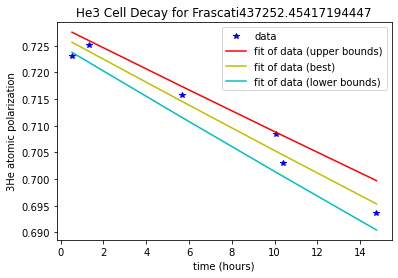

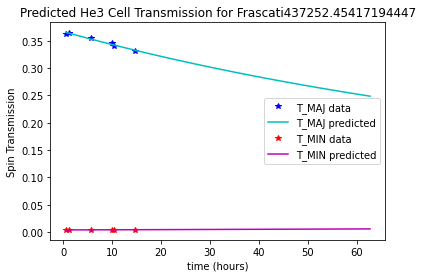

In [12]:
#Run this cell to sort files and get 3He decay curves (as applicable)

Contents = "not used"
if not os.path.exists(save_path):
    os.makedirs(save_path)

Detector_Panels, TransPanel, Slices = Instrument_Assignment(Instrument)

Sample_Names, Sample_Bases, Configs, BlockBeamCatalog, ScattCatalog, TransCatalog, Pol_TransCatalog, AlignDet_Trans, HE3_TransCatalog, start_number, filenumberlisting = AllSANS_SortDataAutomaticAlt(Detector_Panels, Instrument, UsePolCorr, SampleDescriptionKeywordsToExclude, TransPanel, input_path, YesNoManualHe3Entry, New_HE3_Files, MuValues, TeValues, Excluded_Filenumbers, Min_Filenumber, Max_Filenumber, Min_Scatt_Filenumber, Max_Scatt_Filenumber, Min_Trans_Filenumber, Max_Trans_Filenumber, ReAssignBlockBeam, ReAssignEmpty, ReAssignOpen, ReAssignSample, YesNoRenameEmpties)

AllSANS_ShareAlignDetTransCatalog(Detector_Panels, Instrument, TempDiffAllowedForSharingTrans, AlignDet_Trans, ScattCatalog)
AllSANS_ShareSampleBaseTransCatalog(Detector_Panels, Instrument, TransCatalog, ScattCatalog)
AllSANS_ShareEmptyPolBeamScattCatalog(ScattCatalog)
VSANS_SharePolTransCatalog(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, TempDiffAllowedForSharingTrans, Pol_TransCatalog, ScattCatalog, input_path)

AllSANS_ProcessHe3TransCatalog(Detector_Panels, Instrument, input_path, HE3_TransCatalog, BlockBeamCatalog, TransPanel)
AllSANS_ProcessPolTransCatalog(Detector_Panels, Instrument, input_path, Pol_TransCatalog, BlockBeamCatalog, TransPanel)
AllSANS_ProcessTransCatalog(Detector_Panels, Instrument, input_path, TransCatalog, BlockBeamCatalog, TransPanel)

Plex_Name, Plex = Plex_File(Detector_Panels, Instrument, input_path, start_number, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain)
HE3_Cell_Summary = HE3_DecayCurves(save_path, HE3_TransCatalog)



In [13]:
#Run this cell to fullt reduce date into images and associated text files (suitable to fitting with SasView)

AllSANS_PolarizationSupermirrorAndFlipper(Pol_TransCatalog, HE3_Cell_Summary, UsePolCorr)
Truest_PSM = vSANS_BestSuperMirrorPolarizationValue(UsePolCorr, PSM_Guess, YesNoBypassBestGuessPSM, Pol_TransCatalog)

vSANS_Record_DataProcessing(Detector_Panels, Instrument, YesNoManualHe3Entry, save_path, Contents, Plex_Name, ScattCatalog, BlockBeamCatalog, TransCatalog, Pol_TransCatalog, HE3_Cell_Summary)
He3_Evaluation(He3Only_Check, HE3_TransCatalog)


AllFullPolSlices, AllHalfPolSlices, AllUnpolSlices = VSANS_MakeSlices_and_SaveASCII(Detector_Panels, Instrument, SampleDescriptionKeywordsToExclude, UsePolCorr, YesNoManualHe3Entry, input_path, save_path, He3CorrectionType, YesNo_2DFilesPerDetector, YesNo_2DCombinedFiles, Absolute_Q_min, Absolute_Q_max, AverageQRanges, Calc_Q_From_Trans, HighResMinX, HighResMaxX, HighResMinY, HighResMaxY, ConvertHighResToSubset, HighResGain, HE3_Cell_Summary, Plex, Truest_PSM, Minimum_PSM, AlignDet_Trans, HE3_TransCatalog, start_number, He3Only_Check, ScattCatalog, BlockBeamCatalog, Configs, Sample_Names, TransCatalog, Pol_TransCatalog, MidddlePixelBorderHorizontal, MidddlePixelBorderVertical, SectorCutAngles, Slices)

AllFullPolResults, AllHalfPolResults, AllUnpolResults = vSANS_SaveSlices_And_Results(Slices, SectorCutAngles, save_path, YesNoShowPlots, YesNoSetPlotXRange, YesNoSetPlotYRange, PlotXmin, PlotXmax, PlotYmin, PlotYmax, AutoSubtractEmpty, UseMTCirc, He3Only_Check, Configs, Sample_Names, ScattCatalog, AllFullPolSlices, AllHalfPolSlices, AllUnpolSlices)

FullPol_BaseToSampleMap, HalfPol_BaseToSampleMap, Unpol_BaseToSampleMap = VSANS_CatergorizeSamplesAndBases(He3Only_Check, Configs, Sample_Bases, Sample_Names, ScattCatalog, AllFullPolSlices,AllHalfPolSlices, AllUnpolSlices)
VSANS_SaveComparativePlots(Slices, ScattCatalog, SectorCutAngles, save_path, FullPol_BaseToSampleMap, HalfPol_BaseToSampleMap, Unpol_BaseToSampleMap, AllFullPolSlices, AllHalfPolSlices, AllUnpolSlices, AllFullPolResults, AllHalfPolResults, AllUnpolResults, Configs, He3Only_Check, CompareUnpolCirc, CompareHalfPolSumCirc, CompareFullPolSumCirc, CompareFullPolStruc, CompareFullPolMagnetism)


  
Fe3O4NPs_4.9V_300.0K
UU, DU, DD, UD Trans: 0.3511   0.0099   0.3437   0.0096
3He Pol (Ave.) 0.9776741981604165
Sample Depol * PSM 0.9537042609481494
Flipping ratios (UU/DU, DD/UD): 35.3907 35.7252
  
Empty
UU, DU, DD, UD Trans: 0.3336   0.0054   0.3345   0.0055
3He Pol (Ave.) 0.974853233629796
Sample Depol * PSM 0.987206756925346
Flipping ratios (UU/DU, DD/UD): 61.4291 60.5957
 
Best measured PSM value (currently or previously measured) is 0.9985
 
Fe3O4NPs_4.9V_300.0K 4Gd300cmF1400cmM5.5Ang PSM is 0.9537042609481494
Empty 4Gd300cmF1400cmM5.5Ang PSM is 0.987206756925346
 
Saving text files and data plots in configuration 4Gd300cmF1400cmM5.5Ang ...
      GlassyCarbon_0.0V_300.0K
      AlignFe3O4NPs_4.9V_300.0K
      Fe3O4NPs_4.9V_300.0K
 
Saving comparative text files and data plots in configuration 4Gd300cmF1400cmM5.5Ang ...
